Mounted at /content/drive
Load pre-trained model


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



Initializing dataset
Loaded 5011 train images
Initializing dataset
Loaded 4950 test images


Starting epoch 1 / 20
Learning Rate for this epoch: 0.001
Epoch [1/20], Iter [5/209] Loss: 63.3436, average_loss: 68.7806
Epoch [1/20], Iter [10/209] Loss: 46.8555, average_loss: 60.5806
Epoch [1/20], Iter [15/209] Loss: 22.5046, average_loss: 50.3959
Epoch [1/20], Iter [20/209] Loss: 17.9624, average_loss: 42.6363
Epoch [1/20], Iter [25/209] Loss: 11.7584, average_loss: 36.8749
Epoch [1/20], Iter [30/209] Loss: 10.0238, average_loss: 32.5056
Epoch [1/20], Iter [35/209] Loss: 8.8770, average_loss: 29.3365
Epoch [1/20], Iter [40/209] Loss: 9.1780, average_loss: 26.9120
Epoch [1/20], Iter [45/209] Loss: 7.2115, average_loss: 24.8884
Epoch [1/20], Iter [50/209] Loss: 8.0803, average_loss: 23.1647
Epoch [1/20], Iter [55/209] Loss: 6.5024, average_loss: 21.7535
Epoch [1/20], Iter [60/209] Loss: 6.5817, average_loss: 20.5683
Epoch [1/20], Iter [65/209] Loss: 6.2623, average_loss: 19.5066
Epoch [1/20

/content/drive/.shortcut-targets-by-id/1-O2GC5PYI1Xf8kQQiqfhx46Whk0XtDXV/A-Courses-PhD/Term_17_Fall2020/CS498-DL/assignments/Assignment_03/My_assignment3_p2_starterkit/predict.py:99: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  ids = (ovr<=threshold).nonzero().squeeze()
  0%|          | 0/4950 [00:00<?, ?it/s]

AttributeError: ignored

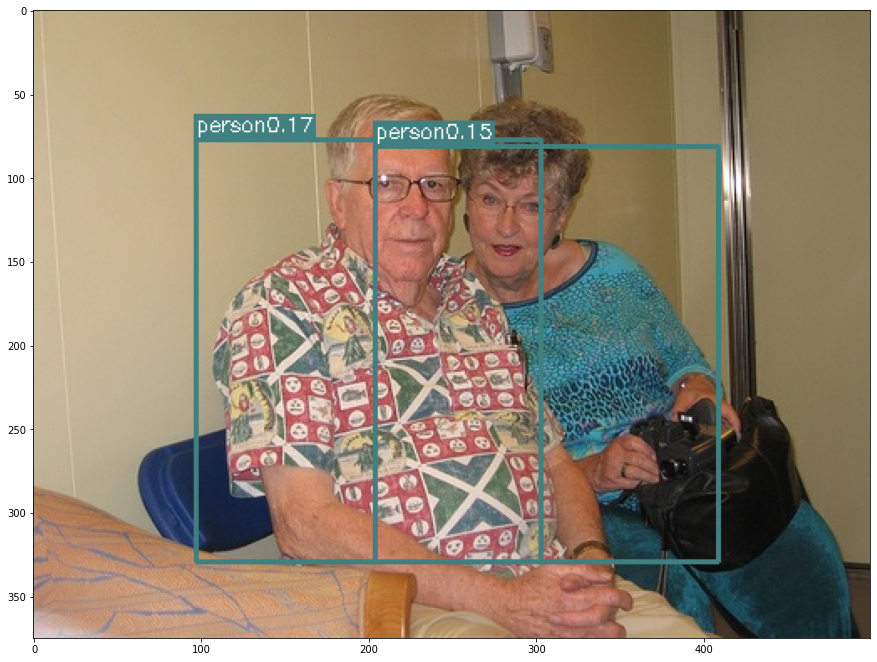

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=False)
os.chdir("/content/drive/My Drive/A-Courses-PhD/Term_17_Fall2020/CS498-DL/assignments/Assignment_03/My_assignment3_p2_starterkit")
#os.chdir("/content/drive/My Drive/CS498-DL/assignments/Assignment_03/My_assignment3_p1_starterkit")
first = 0

import os
import random

import cv2
import numpy as np

import torch
from torch.utils.data import DataLoader
from torchvision import models

from resnet_yolo import resnet50
from yolo_loss import YoloLoss
from dataset import VocDetectorDataset
from eval_voc import evaluate
from predict import predict_image
from config import VOC_CLASSES, COLORS
from kaggle_submission import output_submission_csv
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# YOLO network hyperparameters
B = 2  # number of bounding box predictions per cell
S = 14  # width/height of network output grid (larger than 7x7 from paper since we use a different network)

load_network_path = None
pretrained = True

# use to load a previously trained network
if load_network_path is not None:
    print('Loading saved network from {}'.format(load_network_path))
    net = resnet50().to(device)
    net.load_state_dict(torch.load(load_network_path))
else:
    print('Load pre-trained model')
    net = resnet50(pretrained=pretrained).to(device)
    
learning_rate = 0.001
num_epochs = 20
batch_size = 24

# Yolo loss component coefficients (as given in Yolo v1 paper)
lambda_coord = 5
lambda_noobj = 0.5
usegpu = 1

criterion = YoloLoss(S, B, lambda_coord, lambda_noobj,usegpu)
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

import shutil 
shutil.copyfile("PASCAL_Data/VOCtrainval_06-Nov-2007.tar", "/content/VOCtrainval_06-Nov-2007.tar")
!tar -xf "/content/VOCtrainval_06-Nov-2007.tar" -C "/content/" 
shutil.move("/content/VOCdevkit/", "/content/VOCdevkit_2007")

shutil.copyfile("PASCAL_Data/VOCtest_06-Nov-2007.tar", "/content/VOCtest_06-Nov-2007.tar")
!tar -xf "/content/VOCtest_06-Nov-2007.tar" -C "/content/" 
shutil.move("/content/VOCdevkit/VOC2007", "/content/VOCdevkit_2007/VOC2007test")

file_root_train = '/content/VOCdevkit_2007/VOC2007/JPEGImages/'
annotation_file_train = 'voc2007.txt'

train_dataset = VocDetectorDataset(root_img_dir=file_root_train,dataset_file=annotation_file_train,train=True, S=S)
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=4)
print('Loaded %d train images' % len(train_dataset))


file_root_test = '/content/VOCdevkit_2007/VOC2007test/JPEGImages/'
annotation_file_test = 'voc2007test.txt'

test_dataset = VocDetectorDataset(root_img_dir=file_root_test,dataset_file=annotation_file_test,train=False, S=S)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False,num_workers=4)
print('Loaded %d test images' % len(test_dataset))


best_test_loss = np.inf

for epoch in range(num_epochs):
    net.train()
    
    # Update learning rate late in training
    if epoch == 30 or epoch == 40:
        learning_rate /= 10.0

    for param_group in optimizer.param_groups:
        param_group['lr'] = learning_rate
    
    print('\n\nStarting epoch %d / %d' % (epoch + 1, num_epochs))
    print('Learning Rate for this epoch: {}'.format(learning_rate))
    
    total_loss = 0.
    
    for i, (images, target) in enumerate(train_loader):
        images, target = images.to(device), target.to(device)
        
        pred = net(images)
        loss = criterion(pred,target)
        total_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i+1) % 5 == 0:
            print('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f, average_loss: %.4f'
                  % (epoch+1, num_epochs, i+1, len(train_loader), loss.item(), total_loss / (i+1)))
    
    # evaluate the network on the test data
    with torch.no_grad():
        test_loss = 0.0
        net.eval()
        for i, (images, target) in enumerate(test_loader):
            images, target = images.to(device), target.to(device)

            pred = net(images)
            loss = criterion(pred,target)
            test_loss += loss.item()
        test_loss /= len(test_loader)
    
    if best_test_loss > test_loss:
        best_test_loss = test_loss
        print('Updating best test loss: %.5f' % best_test_loss)
        torch.save(net.state_dict(),'best_detector.pth')

    torch.save(net.state_dict(),'detector.pth')
    

net.eval()

# select random image from test set
image_name = random.choice(test_dataset.fnames)
image = cv2.imread(os.path.join(file_root_test, image_name))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print('predicting...')
result = predict_image(net, image_name, root_img_directory=file_root_test)
for left_up, right_bottom, class_name, _, prob in result:
    color = COLORS[VOC_CLASSES.index(class_name)]
    cv2.rectangle(image, left_up, right_bottom, color, 2)
    label = class_name + str(round(prob, 2))
    text_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
    p1 = (left_up[0], left_up[1] - text_size[1])
    cv2.rectangle(image, (p1[0] - 2 // 2, p1[1] - 2 - baseline), (p1[0] + text_size[0], p1[1] + text_size[1]),
                  color, -1)
    cv2.putText(image, label, (p1[0], p1[1] + baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, 8)

plt.figure(figsize = (15,15))
plt.imshow(image)


test_aps = evaluate(net, test_dataset_file=annotation_file_test)

output_submission_csv('my_solution.csv', test_aps)


In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=False)
os.chdir("/content/drive/My Drive/A-Courses-PhD/Term_17_Fall2020/CS498-DL/assignments/Assignment_03/My_assignment3_p2_starterkit")
#os.chdir("/content/drive/My Drive/CS498-DL/assignments/Assignment_03/My_assignment3_p1_starterkit")
first = 0

In [ ]:
import os
import random

import cv2
import numpy as np

import torch
from torch.utils.data import DataLoader
from torchvision import models

from resnet_yolo import resnet50
from yolo_loss import YoloLoss
from dataset import VocDetectorDataset
from eval_voc import evaluate
from predict import predict_image
from config import VOC_CLASSES, COLORS
from kaggle_submission import output_submission_csv
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Assignment3 Part2: Yolo Detection

We provide you a Yolo Detection network implementation, which is not finished. You are asked to complete the implementation by writing the loss function.

## What to do
You are asked to implement the loss function in ```yolo_loss.py```. You can use ```yolo_loss_debug_tool.ipynb``` to help you debug.

## What to submit
See the submission template for what to submit.

## Initialization

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# YOLO network hyperparameters
B = 2  # number of bounding box predictions per cell
S = 14  # width/height of network output grid (larger than 7x7 from paper since we use a different network)

To implement Yolo we will rely on a pretrained classifier as the backbone for our detection network. PyTorch offers a variety of models which are pretrained on ImageNet in the [`torchvision.models`](https://pytorch.org/docs/stable/torchvision/models.html) package. In particular, we will use the ResNet50 architecture as a base for our detector. This is different from the base architecture in the Yolo paper and also results in a different output grid size (14x14 instead of 7x7).

Models are typically pretrained on ImageNet since the dataset is very large (> 1million images) and widely used. The pretrained model provides a very useful weight initialization for our detector, so that the network is able to learn quickly and effictively.

In [ ]:
load_network_path = None
pretrained = True

# use to load a previously trained network
if load_network_path is not None:
    print('Loading saved network from {}'.format(load_network_path))
    net = resnet50().to(device)
    net.load_state_dict(torch.load(load_network_path))
else:
    print('Load pre-trained model')
    net = resnet50(pretrained=pretrained).to(device)

In [ ]:
learning_rate = 0.001
num_epochs = 50
batch_size = 24

# Yolo loss component coefficients (as given in Yolo v1 paper)
lambda_coord = 5
lambda_noobj = 0.5

In [ ]:
criterion = YoloLoss(S, B, lambda_coord, lambda_noobj)
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

## Reading Pascal Data

Since Pascal is a small dataset (5000 in train+val) we have combined the train and val splits to train our detector. This is not typically a good practice, but we will make an exception in this case to be able to get reasonable detection results with a comparatively small object detection dataset.

The train dataset loader also using a variety of data augmentation techniques including random shift, scaling, crop, and flips. Data augmentation is slightly more complicated for detection dataset since the bounding box annotations must be kept consistent through the transformations.

Since the output of the dector network we train is an SxSx(B*5+C), we use an encoder to convert the original bounding box coordinates into relative grid bounding box coordinates corresponding to the the expected output. We also use a decoder which allows us to convert the opposite direction into image coordinate bounding boxes.

In [ ]:
import shutil 
shutil.copyfile("VOCtrainval_06-Nov-2007.tar", "/content/VOCtrainval_06-Nov-2007.tar")
!tar -xf "/content/VOCtrainval_06-Nov-2007.tar" -C "/content/" 
shutil.move("/content/VOCdevkit/", "/content/VOCdevkit_2007")

shutil.copyfile("VOCtest_06-Nov-2007.tar", "/content/VOCtest_06-Nov-2007.tar")
!tar -xf "/content/VOCtest_06-Nov-2007.tar" -C "/content/" 
shutil.move("/content/VOCdevkit/VOC2007", "/content/VOCdevkit_2007/VOC2007test")

In [ ]:
file_root_train = '/content/VOCdevkit_2007/VOC2007/JPEGImages/'
annotation_file_train = 'voc2007.txt'

train_dataset = VocDetectorDataset(root_img_dir=file_root_train,dataset_file=annotation_file_train,train=True, S=S)
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=4)
print('Loaded %d train images' % len(train_dataset))

In [ ]:
file_root_test = '/content/VOCdevkit_2007/VOC2007test/JPEGImages/'
annotation_file_test = 'voc2007test.txt'

test_dataset = VocDetectorDataset(root_img_dir=file_root_test,dataset_file=annotation_file_test,train=False, S=S)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False,num_workers=4)
print('Loaded %d test images' % len(test_dataset))

## Train detector

In [63]:
best_test_loss = np.inf

for epoch in range(num_epochs):
    net.train()
    
    # Update learning rate late in training
    if epoch == 30 or epoch == 40:
        learning_rate /= 10.0

    for param_group in optimizer.param_groups:
        param_group['lr'] = learning_rate
    
    print('\n\nStarting epoch %d / %d' % (epoch + 1, num_epochs))
    print('Learning Rate for this epoch: {}'.format(learning_rate))
    
    total_loss = 0.
    
    for i, (images, target) in enumerate(train_loader):
        images, target = images.to(device), target.to(device)
        
        pred = net(images)
        loss = criterion(pred,target)
        total_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i+1) % 5 == 0:
            print('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f, average_loss: %.4f'
                  % (epoch+1, num_epochs, i+1, len(train_loader), loss.item(), total_loss / (i+1)))
    
    # evaluate the network on the test data
    with torch.no_grad():
        test_loss = 0.0
        net.eval()
        for i, (images, target) in enumerate(test_loader):
            images, target = images.to(device), target.to(device)

            pred = net(images)
            loss = criterion(pred,target)
            test_loss += loss.item()
        test_loss /= len(test_loader)
    
    if best_test_loss > test_loss:
        best_test_loss = test_loss
        print('Updating best test loss: %.5f' % best_test_loss)
        torch.save(net.state_dict(),'best_detector.pth')

    torch.save(net.state_dict(),'detector.pth')
    




Starting epoch 1 / 20
Learning Rate for this epoch: 0.001
Epoch [1/20], Iter [5/209] Loss: 2.7219, average_loss: 2.4121
Epoch [1/20], Iter [10/209] Loss: 2.1151, average_loss: 2.4033
Epoch [1/20], Iter [15/209] Loss: 2.4664, average_loss: 2.3950
Epoch [1/20], Iter [20/209] Loss: 2.0343, average_loss: 2.3339
Epoch [1/20], Iter [25/209] Loss: 2.3830, average_loss: 2.3156
Epoch [1/20], Iter [30/209] Loss: 2.8816, average_loss: 2.3174
Epoch [1/20], Iter [35/209] Loss: 1.8785, average_loss: 2.2969
Epoch [1/20], Iter [40/209] Loss: 2.2584, average_loss: 2.2686
Epoch [1/20], Iter [45/209] Loss: 1.7714, average_loss: 2.2631
Epoch [1/20], Iter [50/209] Loss: 1.9886, average_loss: 2.2501
Epoch [1/20], Iter [55/209] Loss: 2.4476, average_loss: 2.2581
Epoch [1/20], Iter [60/209] Loss: 2.5724, average_loss: 2.2492
Epoch [1/20], Iter [65/209] Loss: 3.1225, average_loss: 2.2541
Epoch [1/20], Iter [70/209] Loss: 1.7297, average_loss: 2.2558
Epoch [1/20], Iter [75/209] Loss: 1.8447, average_loss: 2.2

# View example predictions

predicting...


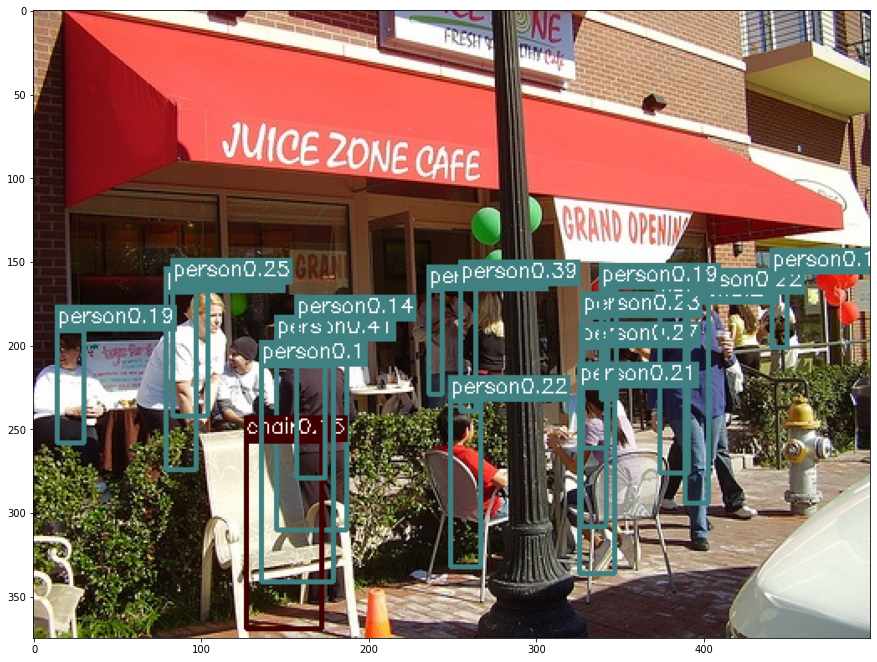

In [65]:
net.eval()

# select random image from test set
image_name = random.choice(test_dataset.fnames)
image = cv2.imread(os.path.join(file_root_test, image_name))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print('predicting...')
result = predict_image(net, image_name, root_img_directory=file_root_test)
for left_up, right_bottom, class_name, _, prob in result:
    color = COLORS[VOC_CLASSES.index(class_name)]
    cv2.rectangle(image, left_up, right_bottom, color, 2)
    label = class_name + str(round(prob, 2))
    text_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
    p1 = (left_up[0], left_up[1] - text_size[1])
    cv2.rectangle(image, (p1[0] - 2 // 2, p1[1] - 2 - baseline), (p1[0] + text_size[0], p1[1] + text_size[1]),
                  color, -1)
    cv2.putText(image, label, (p1[0], p1[1] + baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, 8)

plt.figure(figsize = (15,15))
plt.imshow(image)


## Evaluate on Test

To evaluate detection results we use mAP (mean of average precision over each class)

In [59]:
import sys
import torch
import numpy as np
from tqdm import tqdm
from collections import defaultdict

from predict import *

from config import VOC_CLASSES


# https://github.com/rbgirshick/py-faster-rcnn/blob/master/lib/datasets/voc_eval.py
def voc_ap(rec, prec, use_07_metric=False):
    """ ap = voc_ap(rec, prec, [use_07_metric])
    Compute VOC AP given precision and recall.
    If use_07_metric is true, uses the
    VOC 07 11 point method (default:False).
    """
    if use_07_metric:
        # 11 point metric
        ap = 0.
        for t in np.arange(0., 1.1, 0.1):
            if np.sum(rec >= t) == 0:
                p = 0
            else:
                p = np.max(prec[rec >= t])
            ap = ap + p / 11.
    else:
        # correct AP calculation
        # first append sentinel values at the end
        mrec = np.concatenate(([0.], rec, [1.]))
        mpre = np.concatenate(([0.], prec, [0.]))

        # compute the precision envelope
        for i in range(mpre.size - 1, 0, -1):
            mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

        # to calculate area under PR curve, look for points
        # where X axis (recall) changes value
        i = np.where(mrec[1:] != mrec[:-1])[0]

        # and sum (\Delta recall) * prec
        ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap


def voc_eval(preds, target, VOC_CLASSES=VOC_CLASSES, threshold=0.5, use_07_metric=False):
    '''
    preds {'cat':[[image_id,confidence,x1,y1,x2,y2],...],'dog':[[],...]}
    target {(image_id,class):[[],]}
    '''
    aps = []
    for i, class_ in enumerate(VOC_CLASSES):
        pred = preds[class_]  # [[image_id,confidence,x1,y1,x2,y2],...]
        if len(pred) == 0: # No predictions made for this class
            ap = 0.0
            print('---class {} ap {}--- (no predictions for this class)'.format(class_, ap))
            aps += [ap]
            continue 
        image_ids = [x[0] for x in pred]
        confidence = np.array([float(x[1]) for x in pred])
        BB = np.array([x[2:] for x in pred])
        # sort by confidence
        sorted_ind = np.argsort(-confidence)
        sorted_scores = np.sort(-confidence)
        BB = BB[sorted_ind, :]
        image_ids = [image_ids[x] for x in sorted_ind]

        # go down dets and mark TPs and FPs
        npos = 0.
        for (key1, key2) in target:
            if key2 == class_:
                npos += len(target[(key1, key2)])
        nd = len(image_ids)
        tp = np.zeros(nd)
        fp = np.zeros(nd)
        for d, image_id in enumerate(image_ids):
            bb = BB[d]
            if (image_id, class_) in target:
                BBGT = target[(image_id, class_)]
                for bbgt in BBGT:
                    # compute overlaps
                    # intersection
                    ixmin = np.maximum(bbgt[0], bb[0])
                    iymin = np.maximum(bbgt[1], bb[1])
                    ixmax = np.minimum(bbgt[2], bb[2])
                    iymax = np.minimum(bbgt[3], bb[3])
                    iw = np.maximum(ixmax - ixmin + 1., 0.)
                    ih = np.maximum(iymax - iymin + 1., 0.)
                    inters = iw * ih

                    union = (bb[2] - bb[0] + 1.) * (bb[3] - bb[1] + 1.) + (bbgt[2] - bbgt[0] + 1.) * (
                    bbgt[3] - bbgt[1] + 1.) - inters
                    if union == 0:
                        print(bb, bbgt)

                    overlaps = inters / union
                    if overlaps > threshold:
                        tp[d] = 1
                        BBGT.remove(bbgt)  # bbox has already been used
                        if len(BBGT) == 0:
                            del target[(image_id, class_)]  # delete things that don't have bbox 
                        break
                fp[d] = 1 - tp[d]
            else:
                fp[d] = 1
        fp = np.cumsum(fp)
        tp = np.cumsum(tp)
        rec = tp / float(npos)
        prec = tp / np.maximum(tp + fp, np.finfo(np.float64).eps)
        ap = voc_ap(rec, prec, use_07_metric)
        print('---class {} ap {}---'.format(class_, ap))
        aps += [ap]
    print('---map {}---'.format(np.mean(aps)))
    return aps

    
    
def evaluate(model, test_dataset_file, test_loader=None):
    targets = defaultdict(list)
    preds = defaultdict(list)
    image_list = []  # image path list

    f = open(test_dataset_file)
    lines = f.readlines()
    file_list = []
    for line in lines:
        splited = line.strip().split()
        file_list.append(splited)
    f.close()
    
    # Collect target predictions for test set
    for index, image_file in enumerate(file_list):
        image_id = image_file[0]

        image_list.append(image_id)
        num_obj = (len(image_file) - 1) // 5
        for i in range(num_obj):
            x1 = int(image_file[1 + 5 * i])
            y1 = int(image_file[2 + 5 * i])
            x2 = int(image_file[3 + 5 * i])
            y2 = int(image_file[4 + 5 * i])
            c = int(image_file[5 + 5 * i])
            class_name = VOC_CLASSES[c]
            targets[(image_id, class_name)].append([x1, y1, x2, y2])

    
    print('---Evaluate model on test samples---')
    sys.stdout.flush()
    model.eval()
    for image_path in tqdm(image_list):
        result = predict_image(model, image_path, root_img_directory='/content/VOCdevkit_2007/VOC2007test/JPEGImages/')
        for (x1, y1), (x2, y2), class_name, image_id, prob in result:  # image_id is actually image_path
            preds[class_name].append([image_id, prob, x1, y1, x2, y2])
            

    aps = voc_eval(preds, targets, VOC_CLASSES=VOC_CLASSES)
    return aps
    

In [ ]:
image.shape[0]
image[0]

In [66]:
import cv2

def predict_image(model, image_name, root_img_directory=''):
    """
    Predict output for a single image

    :param model: detector model for inference
    :param image_name: image file name e.g. '0000000.jpg'
    :param root_img_directory:
    :return: List of lists containing:
        - (x1, y1)
        - (x2, y2)
        - predicted class name
        - image name
        - predicted class probability
    """

    result = []
    image = cv2.imread(os.path.join(root_img_directory + image_name))
    print(root_img_directory)
    print(root_img_directory + image_name)
    print(os.path.join(root_img_directory + image_name))
    h = image.shape[0]
    w = image.shape[1]
    #h, w, _ = image.shape
    img = cv2.resize(image, (YOLO_IMG_DIM, YOLO_IMG_DIM))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mean = VOC_IMG_MEAN
    img = img - np.array(mean, dtype=np.float32)

    transform = transforms.Compose([transforms.ToTensor(), ])
    img = transform(img)
    with torch.no_grad():
        img = Variable(img[None, :, :, :])
        img = img.cuda()

        pred = model(img)  # 1xSxSx(B*5+C)
        pred = pred.cpu()
        boxes, cls_indexs, probs = decoder(pred)

        for i, box in enumerate(boxes):
            x1 = int(box[0] * w)
            x2 = int(box[2] * w)
            y1 = int(box[1] * h)
            y2 = int(box[3] * h)
            cls_index = cls_indexs[i]
            cls_index = int(cls_index)  # convert LongTensor to int
            prob = probs[i]
            prob = float(prob)
            result.append([(x1, y1), (x2, y2), VOC_CLASSES[cls_index], image_name, prob])
    return result



In [ ]:
test_aps = evaluate(net, test_dataset_file=annotation_file_test)
output_submission_csv('my_solution.csv', test_aps)

---Evaluate model on test samples---




  0%|          | 0/4950 [00:00<?, ?it/s]

  0%|          | 3/4950 [00:00<03:45, 21.92it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002824.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002824.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000473.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000473.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000358.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000358.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006052.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006052.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004758.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004758.jpg




  0%|          | 6/4950 [00:00<03:43, 22.13it/s]

  0%|          | 9/4950 [00:00<03:36, 22.81it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003385.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003385.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003494.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003494.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002128.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002128.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007962.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007962.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003583.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003583.jpg




  0%|          | 12/4950 [00:00<03:31, 23.38it/s]

  0%|          | 15/4950 [00:00<03:25, 24.02it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003922.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003922.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009725.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009725.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002850.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002850.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001921.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001921.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009818.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009818.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001959.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001959.jpg




  0%|          | 18/4950 [00:00<03:17, 25.01it/s]

  0%|          | 21/4950 [00:00<03:14, 25.34it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005505.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005505.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005651.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005651.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003909.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003909.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000106.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000106.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001222.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001222.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000361.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000361.jpg




  0%|          | 24/4950 [00:00<03:09, 26.02it/s]

  1%|          | 27/4950 [00:01<03:06, 26.44it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002250.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002250.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004417.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004417.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001183.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001183.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000418.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000418.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000841.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000841.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001871.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001871.jpg




  1%|          | 30/4950 [00:01<03:02, 26.95it/s]

  1%|          | 33/4950 [00:01<03:00, 27.31it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000421.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000421.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003978.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003978.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009951.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009951.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003172.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003172.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001912.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001912.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003368.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003368.jpg




  1%|          | 36/4950 [00:01<03:01, 27.12it/s]

  1%|          | 39/4950 [00:01<02:58, 27.46it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009065.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009065.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003602.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003602.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007686.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007686.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002993.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002993.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005196.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005196.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004043.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004043.jpg




  1%|          | 42/4950 [00:01<02:56, 27.77it/s]

  1%|          | 45/4950 [00:01<02:57, 27.65it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006970.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006970.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009934.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009934.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009475.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009475.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006795.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006795.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005503.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005503.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008715.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008715.jpg




  1%|          | 48/4950 [00:01<02:55, 27.99it/s]

  1%|          | 51/4950 [00:01<02:53, 28.21it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007231.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007231.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004829.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004829.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003490.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003490.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003718.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003718.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005798.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005798.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002007.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002007.jpg




  1%|          | 54/4950 [00:02<02:56, 27.69it/s]

  1%|          | 57/4950 [00:02<02:56, 27.70it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002663.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002663.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004049.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004049.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009559.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009559.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007332.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007332.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009003.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009003.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007698.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007698.jpg




  1%|          | 60/4950 [00:02<02:54, 28.03it/s]

  1%|▏         | 63/4950 [00:02<02:52, 28.28it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006051.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006051.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006999.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006999.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001449.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001449.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009090.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009090.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003309.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003309.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008210.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008210.jpg




  1%|▏         | 66/4950 [00:02<02:53, 28.12it/s]

  1%|▏         | 69/4950 [00:02<02:53, 28.14it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005200.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005200.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009069.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009069.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007917.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007917.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001458.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001458.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001039.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001039.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009892.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009892.jpg




  1%|▏         | 72/4950 [00:02<02:54, 27.92it/s]

  2%|▏         | 75/4950 [00:02<02:53, 28.06it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004547.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004547.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005291.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005291.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006875.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006875.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005280.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005280.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002447.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002447.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001031.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001031.jpg




  2%|▏         | 78/4950 [00:02<02:57, 27.46it/s]

  2%|▏         | 81/4950 [00:03<02:53, 28.04it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001757.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001757.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001552.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001552.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009381.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009381.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002296.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002296.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005525.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005525.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002154.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002154.jpg




  2%|▏         | 84/4950 [00:03<02:56, 27.62it/s]

  2%|▏         | 87/4950 [00:03<02:52, 28.12it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008946.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008946.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001003.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001003.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003523.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003523.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003158.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003158.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008077.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008077.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007426.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007426.jpg




  2%|▏         | 90/4950 [00:03<02:52, 28.23it/s]

  2%|▏         | 93/4950 [00:03<02:50, 28.56it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009043.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009043.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001589.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001589.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009795.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009795.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009522.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009522.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002922.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002922.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001202.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001202.jpg




  2%|▏         | 96/4950 [00:03<02:49, 28.71it/s]

  2%|▏         | 99/4950 [00:03<02:50, 28.39it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004216.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004216.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008555.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008555.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005184.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005184.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006280.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006280.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009563.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009563.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004804.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004804.jpg




  2%|▏         | 102/4950 [00:03<02:53, 28.01it/s]

  2%|▏         | 105/4950 [00:03<02:54, 27.82it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001506.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001506.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007061.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007061.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009081.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009081.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000176.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000176.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001897.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001897.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002231.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002231.jpg




  2%|▏         | 108/4950 [00:03<02:52, 28.09it/s]

  2%|▏         | 111/4950 [00:04<02:58, 27.07it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006785.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006785.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003533.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003533.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008145.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008145.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008156.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008156.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000584.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000584.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001122.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001122.jpg




  2%|▏         | 114/4950 [00:04<02:56, 27.47it/s]

  2%|▏         | 117/4950 [00:04<02:52, 27.98it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009889.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009889.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002961.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002961.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004712.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004712.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003584.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003584.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005142.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005142.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003361.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003361.jpg




  2%|▏         | 120/4950 [00:04<02:55, 27.52it/s]

  2%|▏         | 123/4950 [00:04<02:56, 27.39it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000188.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000188.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005504.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005504.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008937.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008937.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007406.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007406.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003402.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003402.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000573.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000573.jpg




  3%|▎         | 126/4950 [00:04<02:57, 27.18it/s]

  3%|▎         | 129/4950 [00:04<02:56, 27.39it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007918.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007918.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006477.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006477.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000283.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000283.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007115.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007115.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008650.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008650.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000423.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000423.jpg




  3%|▎         | 132/4950 [00:04<02:53, 27.78it/s]

  3%|▎         | 135/4950 [00:04<02:51, 28.02it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001794.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001794.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001271.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001271.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007707.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007707.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003348.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003348.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007357.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007357.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008897.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008897.jpg




  3%|▎         | 138/4950 [00:05<02:52, 27.94it/s]

  3%|▎         | 141/4950 [00:05<02:51, 28.07it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007338.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007338.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003840.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003840.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009257.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009257.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004180.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004180.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003893.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003893.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002629.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002629.jpg




  3%|▎         | 144/4950 [00:05<02:50, 28.18it/s]

  3%|▎         | 148/4950 [00:05<02:46, 28.78it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002752.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002752.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007532.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007532.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001558.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001558.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005966.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005966.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009510.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009510.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000272.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000272.jpg




  3%|▎         | 151/4950 [00:05<02:49, 28.29it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004254.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004254.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009864.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009864.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005575.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005575.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008861.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008861.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009854.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009854.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002686.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002686.jpg




  3%|▎         | 154/4950 [00:05<02:51, 28.03it/s]

  3%|▎         | 157/4950 [00:05<02:47, 28.55it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004762.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004762.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008682.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008682.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006809.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006809.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001681.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001681.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006143.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006143.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004996.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004996.jpg




  3%|▎         | 160/4950 [00:05<02:50, 28.09it/s]

  3%|▎         | 163/4950 [00:05<02:47, 28.54it/s]

  3%|▎         | 166/4950 [00:06<02:45, 28.96it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000181.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000181.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006837.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006837.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002018.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002018.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003653.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003653.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001356.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001356.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006688.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006688.jpg
/content/VOCdevk



  3%|▎         | 169/4950 [00:06<02:49, 28.18it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009017.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009017.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007019.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007019.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007784.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007784.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000557.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000557.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008668.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008668.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008289.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008289.jpg




  3%|▎         | 173/4950 [00:06<02:46, 28.69it/s]

  4%|▎         | 176/4950 [00:06<02:44, 29.00it/s]

  4%|▎         | 179/4950 [00:06<02:44, 29.06it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000217.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000217.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000681.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000681.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007960.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007960.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006333.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006333.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007347.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007347.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008812.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008812.jpg




  4%|▎         | 182/4950 [00:06<02:45, 28.79it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006710.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006710.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001180.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001180.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006354.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006354.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005602.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005602.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005862.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005862.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002655.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002655.jpg
/content/VOCdevk



  4%|▍         | 186/4950 [00:06<02:43, 29.19it/s]

  4%|▍         | 189/4950 [00:06<02:41, 29.41it/s]

  4%|▍         | 192/4950 [00:06<02:42, 29.23it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005076.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005076.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007505.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007505.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005275.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005275.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004847.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004847.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004465.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004465.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008972.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008972.jpg




  4%|▍         | 195/4950 [00:07<02:45, 28.72it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000745.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000745.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003341.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003341.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005022.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005022.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002389.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002389.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000568.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000568.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006906.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006906.jpg




  4%|▍         | 198/4950 [00:07<02:48, 28.21it/s]

  4%|▍         | 201/4950 [00:07<02:45, 28.65it/s]

  4%|▍         | 204/4950 [00:07<02:45, 28.70it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009791.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009791.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000998.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000998.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006967.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006967.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008786.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008786.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006522.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006522.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007549.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007549.jpg




  4%|▍         | 207/4950 [00:07<02:44, 28.81it/s]

  4%|▍         | 210/4950 [00:07<02:43, 28.90it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005834.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005834.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003527.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003527.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000639.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000639.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004090.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004090.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000271.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000271.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002005.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002005.jpg



 15%|█▌        | 758/4950 [00:39<02:26, 28.58it/s]

  4%|▍         | 213/4950 [00:07<02:45, 28.62it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003428.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003428.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008994.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008994.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000893.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000893.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003607.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003607.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001067.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001067.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009248.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009248.jpg




  4%|▍         | 216/4950 [00:07<02:49, 27.91it/s]

  4%|▍         | 219/4950 [00:07<02:48, 28.00it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008954.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008954.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000506.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000506.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009014.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009014.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003447.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003447.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007858.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007858.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002344.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002344.jpg




  4%|▍         | 222/4950 [00:07<02:48, 28.07it/s]

  5%|▍         | 225/4950 [00:08<02:46, 28.43it/s]

  5%|▍         | 228/4950 [00:08<02:46, 28.28it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004071.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004071.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005978.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005978.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004635.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004635.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007456.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007456.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000779.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000779.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002379.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002379.jpg




  5%|▍         | 231/4950 [00:08<02:46, 28.38it/s]

  5%|▍         | 234/4950 [00:08<02:46, 28.41it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000182.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000182.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000994.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000994.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009474.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009474.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000405.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000405.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005745.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005745.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002729.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002729.jpg




  5%|▍         | 237/4950 [00:08<02:47, 28.08it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009811.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009811.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003502.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003502.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000773.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000773.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002828.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002828.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005929.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005929.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002370.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002370.jpg
/content/VOCdevk



  5%|▍         | 241/4950 [00:08<02:44, 28.67it/s]

  5%|▍         | 245/4950 [00:08<02:40, 29.23it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006054.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006054.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007710.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007710.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001044.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001044.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007333.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007333.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004899.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004899.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009914.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009914.jpg
/content/VOCdevk



  5%|▌         | 248/4950 [00:08<02:40, 29.32it/s]

  5%|▌         | 251/4950 [00:08<02:39, 29.44it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008233.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008233.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009486.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009486.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009030.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009030.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001591.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001591.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007922.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007922.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000940.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000940.jpg




  5%|▌         | 254/4950 [00:09<02:43, 28.66it/s]

  5%|▌         | 257/4950 [00:09<02:44, 28.61it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009041.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009041.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005074.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005074.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000916.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000916.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006407.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006407.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007888.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007888.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002430.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002430.jpg




  5%|▌         | 260/4950 [00:09<02:46, 28.24it/s]

  5%|▌         | 263/4950 [00:09<02:43, 28.72it/s]

  5%|▌         | 266/4950 [00:09<02:41, 29.02it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007161.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007161.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001131.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001131.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004407.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004407.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008464.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008464.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008977.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008977.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000432.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000432.jpg




  5%|▌         | 269/4950 [00:09<02:41, 28.90it/s]

  5%|▌         | 272/4950 [00:09<02:40, 29.19it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008779.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008779.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004385.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004385.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002079.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002079.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002038.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002038.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005296.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005296.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008781.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008781.jpg




  6%|▌         | 275/4950 [00:09<02:40, 29.18it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003062.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003062.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004107.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004107.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002638.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002638.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004900.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004900.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000247.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000247.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002805.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002805.jpg
/content/VOCdevk



  6%|▌         | 279/4950 [00:09<02:38, 29.53it/s]

  6%|▌         | 282/4950 [00:10<02:37, 29.58it/s]

  6%|▌         | 285/4950 [00:10<02:37, 29.53it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007628.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007628.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009626.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009626.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007891.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007891.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008348.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008348.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008603.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008603.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008703.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008703.jpg




  6%|▌         | 288/4950 [00:10<02:42, 28.72it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000297.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000297.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009912.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009912.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001491.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001491.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001873.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001873.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001823.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001823.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005965.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005965.jpg




  6%|▌         | 291/4950 [00:10<02:41, 28.93it/s]

  6%|▌         | 294/4950 [00:10<02:42, 28.58it/s]

  6%|▌         | 297/4950 [00:10<02:41, 28.86it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007645.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007645.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003248.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003248.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000295.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000295.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003405.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003405.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007096.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007096.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008493.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008493.jpg




  6%|▌         | 300/4950 [00:10<02:39, 29.18it/s]

  6%|▌         | 303/4950 [00:10<02:40, 29.00it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004267.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004267.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002929.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002929.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008059.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008059.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006454.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006454.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002756.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002756.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004688.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004688.jpg




  6%|▌         | 306/4950 [00:10<02:38, 29.22it/s]

  6%|▌         | 309/4950 [00:10<02:38, 29.28it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005473.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005473.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002885.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002885.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002464.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002464.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000575.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000575.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007804.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007804.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008479.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008479.jpg




  6%|▋         | 312/4950 [00:11<02:37, 29.41it/s]

  6%|▋         | 315/4950 [00:11<02:37, 29.43it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004099.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004099.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001377.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001377.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001702.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001702.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009357.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009357.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006885.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006885.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002431.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002431.jpg




  6%|▋         | 318/4950 [00:11<02:41, 28.72it/s]

  6%|▋         | 321/4950 [00:11<02:40, 28.79it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009716.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009716.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003903.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003903.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001516.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001516.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001473.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001473.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009648.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009648.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009137.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009137.jpg
/content/VOCdevk



  7%|▋         | 324/4950 [00:11<02:39, 29.09it/s]

  7%|▋         | 328/4950 [00:11<02:35, 29.63it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005890.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005890.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001567.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001567.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002408.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002408.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003514.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003514.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005163.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005163.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005847.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005847.jpg
/content/VOCdevk



  7%|▋         | 331/4950 [00:11<02:35, 29.72it/s]

  7%|▋         | 334/4950 [00:11<02:35, 29.59it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000558.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000558.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006620.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006620.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006642.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006642.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004000.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004000.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009846.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009846.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007881.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007881.jpg




  7%|▋         | 337/4950 [00:11<02:37, 29.38it/s]

  7%|▋         | 341/4950 [00:12<02:34, 29.91it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006059.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006059.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005744.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005744.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008649.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008649.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009765.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009765.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004317.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004317.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007265.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007265.jpg
/content/VOCdevk



  7%|▋         | 344/4950 [00:12<02:33, 29.93it/s]

  7%|▋         | 347/4950 [00:12<02:37, 29.28it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002271.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002271.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004311.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004311.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007069.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007069.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005060.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005060.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008637.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008637.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009871.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009871.jpg




  7%|▋         | 351/4950 [00:12<02:34, 29.85it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004235.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004235.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009635.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009635.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004573.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004573.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007131.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007131.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003334.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003334.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007272.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007272.jpg
/content/VOCdevk



  7%|▋         | 355/4950 [00:12<02:31, 30.28it/s]

  7%|▋         | 359/4950 [00:12<02:31, 30.29it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002072.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002072.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000897.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000897.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002674.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002674.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001379.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001379.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008155.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008155.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002861.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002861.jpg




  7%|▋         | 363/4950 [00:12<02:33, 29.85it/s]

  7%|▋         | 366/4950 [00:12<02:35, 29.40it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001424.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001424.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008412.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008412.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001916.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001916.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008111.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008111.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002982.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002982.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002860.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002860.jpg




  7%|▋         | 369/4950 [00:13<02:37, 29.09it/s]

  8%|▊         | 372/4950 [00:13<02:36, 29.19it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006248.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006248.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007894.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007894.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009225.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009225.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003099.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003099.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002252.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002252.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004415.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004415.jpg




  8%|▊         | 376/4950 [00:13<02:37, 29.07it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006895.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006895.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007169.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007169.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008918.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008918.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004478.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004478.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006504.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006504.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007173.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007173.jpg




  8%|▊         | 379/4950 [00:13<02:40, 28.43it/s]

  8%|▊         | 383/4950 [00:13<02:36, 29.25it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002299.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002299.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000386.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000386.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003785.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003785.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008684.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008684.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001998.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001998.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006126.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006126.jpg
/content/VOCdevk



  8%|▊         | 387/4950 [00:13<02:34, 29.63it/s]

  8%|▊         | 390/4950 [00:13<02:34, 29.56it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003715.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003715.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001956.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001956.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007306.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007306.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003544.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003544.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001181.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001181.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005362.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005362.jpg




  8%|▊         | 393/4950 [00:13<02:34, 29.48it/s]

  8%|▊         | 396/4950 [00:13<02:34, 29.55it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008055.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008055.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007893.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007893.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006489.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006489.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006122.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006122.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009154.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009154.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004729.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004729.jpg




  8%|▊         | 399/4950 [00:14<02:34, 29.46it/s]

  8%|▊         | 402/4950 [00:14<02:36, 29.14it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004669.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004669.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004456.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004456.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001538.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001538.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003315.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003315.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006087.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006087.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006072.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006072.jpg




  8%|▊         | 405/4950 [00:14<02:34, 29.34it/s]

  8%|▊         | 408/4950 [00:14<02:39, 28.56it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003196.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003196.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001743.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001743.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001994.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001994.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004268.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004268.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007989.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007989.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001666.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001666.jpg




  8%|▊         | 411/4950 [00:14<02:37, 28.73it/s]

  8%|▊         | 414/4950 [00:14<02:37, 28.74it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000231.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000231.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004161.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004161.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006340.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006340.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002930.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002930.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001631.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001631.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007507.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007507.jpg




  8%|▊         | 417/4950 [00:14<02:38, 28.55it/s]

  8%|▊         | 420/4950 [00:14<02:36, 28.87it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008916.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008916.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004664.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004664.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000769.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000769.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004817.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004817.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002654.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002654.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008246.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008246.jpg
/content/VOCdevk



  9%|▊         | 423/4950 [00:14<02:35, 29.08it/s]

  9%|▊         | 426/4950 [00:14<02:36, 28.99it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006342.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006342.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007501.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007501.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005595.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005595.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009346.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009346.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007975.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007975.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002983.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002983.jpg
/content/VOCdevk



  9%|▊         | 430/4950 [00:15<02:33, 29.48it/s]

  9%|▉         | 434/4950 [00:15<02:31, 29.79it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009552.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009552.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007142.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007142.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005973.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005973.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002206.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002206.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007994.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007994.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003630.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003630.jpg




  9%|▉         | 437/4950 [00:15<02:35, 29.10it/s]

  9%|▉         | 441/4950 [00:15<02:32, 29.52it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004875.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004875.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009893.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009893.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009223.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009223.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003901.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003901.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007782.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007782.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003125.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003125.jpg




  9%|▉         | 444/4950 [00:15<02:32, 29.51it/s]

  9%|▉         | 448/4950 [00:15<02:31, 29.81it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005675.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005675.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000914.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000914.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003666.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003666.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006801.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006801.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001373.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001373.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002381.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002381.jpg
/content/VOCdevk



  9%|▉         | 451/4950 [00:15<02:31, 29.69it/s]

  9%|▉         | 455/4950 [00:15<02:30, 29.91it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007973.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007973.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001663.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001663.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008657.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008657.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007400.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007400.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001081.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001081.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006327.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006327.jpg
/content/VOCdevk



  9%|▉         | 458/4950 [00:16<02:31, 29.59it/s]

  9%|▉         | 461/4950 [00:16<02:32, 29.42it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001779.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001779.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000378.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000378.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006109.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006109.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000835.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000835.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006002.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006002.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001634.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001634.jpg




  9%|▉         | 464/4950 [00:16<02:33, 29.20it/s]

  9%|▉         | 467/4950 [00:16<02:35, 28.78it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002837.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002837.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000643.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000643.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005891.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005891.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005750.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005750.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002809.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002809.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006634.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006634.jpg




  9%|▉         | 470/4950 [00:16<02:35, 28.74it/s]

 10%|▉         | 473/4950 [00:16<02:34, 29.03it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000655.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000655.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006328.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006328.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005232.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005232.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001047.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001047.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000168.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000168.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004906.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004906.jpg
/content/VOCdevk



 10%|▉         | 476/4950 [00:16<02:33, 29.16it/s]

 10%|▉         | 479/4950 [00:16<02:32, 29.23it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000505.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000505.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004586.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004586.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000324.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000324.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000467.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000467.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005464.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005464.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003746.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003746.jpg




 10%|▉         | 482/4950 [00:16<02:34, 28.86it/s]

 10%|▉         | 486/4950 [00:16<02:33, 29.06it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003201.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003201.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000490.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000490.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008887.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008887.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000533.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000533.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009601.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009601.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009539.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009539.jpg




 10%|▉         | 489/4950 [00:17<02:37, 28.37it/s]

 10%|▉         | 493/4950 [00:17<02:33, 29.04it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000475.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000475.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001363.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001363.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005804.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005804.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002746.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002746.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000696.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000696.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002895.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002895.jpg




 10%|█         | 496/4950 [00:17<02:35, 28.60it/s]

 10%|█         | 499/4950 [00:17<02:35, 28.66it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006494.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006494.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008642.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008642.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003212.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003212.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009001.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009001.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003515.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003515.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000310.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000310.jpg




 10%|█         | 502/4950 [00:17<02:33, 28.91it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007267.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007267.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001029.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001029.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009489.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009489.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006360.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006360.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002200.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002200.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005477.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005477.jpg




 10%|█         | 505/4950 [00:17<02:36, 28.34it/s]

 10%|█         | 509/4950 [00:17<02:33, 28.93it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001700.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001700.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009554.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009554.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006388.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006388.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006920.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006920.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006582.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006582.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006882.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006882.jpg
/content/VOCdevk



 10%|█         | 512/4950 [00:17<02:34, 28.74it/s]

 10%|█         | 516/4950 [00:18<02:31, 29.30it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005540.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005540.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009328.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009328.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009953.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009953.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003689.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003689.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005604.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005604.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007750.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007750.jpg
/content/VOCdevk



 10%|█         | 519/4950 [00:18<02:30, 29.48it/s]

 11%|█         | 522/4950 [00:18<02:30, 29.43it/s]

 11%|█         | 525/4950 [00:18<02:29, 29.60it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008402.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008402.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001235.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001235.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000683.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000683.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004822.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004822.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007797.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007797.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008704.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008704.jpg




 11%|█         | 528/4950 [00:18<02:29, 29.60it/s]

 11%|█         | 531/4950 [00:18<02:29, 29.54it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009363.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009363.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005233.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005233.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007171.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007171.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009093.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009093.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003166.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003166.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001648.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001648.jpg




 11%|█         | 534/4950 [00:18<02:32, 28.88it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007452.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007452.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006121.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006121.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005494.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005494.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009941.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009941.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006310.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006310.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006742.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006742.jpg




 11%|█         | 538/4950 [00:18<02:30, 29.26it/s]

 11%|█         | 542/4950 [00:18<02:28, 29.77it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002422.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002422.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006881.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006881.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008623.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008623.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002010.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002010.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005810.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005810.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002243.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002243.jpg
/content/VOCdevk



 11%|█         | 545/4950 [00:19<02:28, 29.71it/s]

 11%|█         | 549/4950 [00:19<02:28, 29.59it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009701.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009701.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003119.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003119.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002538.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002538.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006913.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006913.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003595.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003595.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008825.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008825.jpg




 11%|█         | 552/4950 [00:19<02:28, 29.61it/s]

 11%|█         | 556/4950 [00:19<02:26, 29.94it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000353.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000353.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009672.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009672.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008800.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008800.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005942.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005942.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000875.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000875.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007693.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007693.jpg
/content/VOCdevk



 11%|█▏        | 560/4950 [00:19<02:25, 30.21it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001891.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001891.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009799.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009799.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000319.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000319.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002144.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002144.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006356.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006356.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006640.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006640.jpg
/content/VOCdevk



 11%|█▏        | 564/4950 [00:19<02:23, 30.52it/s]

 11%|█▏        | 568/4950 [00:19<02:22, 30.74it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007646.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007646.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005886.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005886.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002356.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002356.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004522.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004522.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001540.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001540.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003598.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003598.jpg
/content/VOCdevk



 12%|█▏        | 572/4950 [00:19<02:22, 30.74it/s]

 12%|█▏        | 576/4950 [00:20<02:23, 30.46it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001238.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001238.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001518.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001518.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001572.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001572.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005158.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005158.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003853.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003853.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001621.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001621.jpg




 12%|█▏        | 580/4950 [00:20<02:22, 30.62it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002552.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002552.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008743.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008743.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009820.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009820.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001895.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001895.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005488.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005488.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008078.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008078.jpg
/content/VOCdevk



 12%|█▏        | 584/4950 [00:20<02:22, 30.66it/s]

 12%|█▏        | 588/4950 [00:20<02:24, 30.15it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001448.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001448.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002608.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002608.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004965.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004965.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007913.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007913.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000108.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000108.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004620.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004620.jpg
/content/VOCdevk



 12%|█▏        | 592/4950 [00:20<02:24, 30.22it/s]

 12%|█▏        | 596/4950 [00:20<02:23, 30.39it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/004410.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005771.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005771.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000576.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000576.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001953.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001953.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002780.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002780.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003289.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003289.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005793.jpg
/content/VOCdevk



 12%|█▏        | 600/4950 [00:20<02:23, 30.42it/s]

 12%|█▏        | 604/4950 [00:20<02:21, 30.68it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006774.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006774.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000054.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000054.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005227.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005227.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002509.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002509.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006676.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006676.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007796.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007796.jpg
/content/VOCdevk



 12%|█▏        | 608/4950 [00:21<02:22, 30.54it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002925.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002925.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002130.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002130.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006728.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006728.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000838.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000838.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002242.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002242.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009891.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009891.jpg
/content/VOCdevk



 12%|█▏        | 612/4950 [00:21<02:22, 30.51it/s]

 12%|█▏        | 616/4950 [00:21<02:22, 30.39it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000725.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000725.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003925.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003925.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007221.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007221.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005941.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005941.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003035.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003035.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009535.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009535.jpg




 13%|█▎        | 620/4950 [00:21<02:24, 29.88it/s]

 13%|█▎        | 623/4950 [00:21<02:25, 29.84it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006255.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006255.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001991.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001991.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000759.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000759.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003707.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003707.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000179.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000179.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003446.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003446.jpg




 13%|█▎        | 627/4950 [00:21<02:23, 30.08it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008950.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008950.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002057.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002057.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003383.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003383.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002289.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002289.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007785.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007785.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008583.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008583.jpg
/content/VOCdevk



 13%|█▎        | 631/4950 [00:21<02:23, 30.19it/s]

 13%|█▎        | 635/4950 [00:21<02:22, 30.32it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000595.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000595.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000623.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000623.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005572.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005572.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009383.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009383.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000817.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000817.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002522.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002522.jpg
/content/VOCdevk



 13%|█▎        | 639/4950 [00:22<02:20, 30.64it/s]

 13%|█▎        | 643/4950 [00:22<02:20, 30.59it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006390.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006390.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000410.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000410.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002487.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002487.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000927.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000927.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007770.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007770.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004979.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004979.jpg




 13%|█▎        | 647/4950 [00:22<02:22, 30.24it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006818.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006818.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002905.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002905.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002515.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002515.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005459.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005459.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008238.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008238.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004865.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004865.jpg
/content/VOCdevk



 13%|█▎        | 651/4950 [00:22<02:23, 29.89it/s]

 13%|█▎        | 654/4950 [00:22<02:23, 29.88it/s]

 13%|█▎        | 657/4950 [00:22<02:24, 29.63it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003864.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003864.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003619.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003619.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001880.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001880.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008646.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008646.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009109.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009109.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001798.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001798.jpg




 13%|█▎        | 660/4950 [00:22<02:25, 29.52it/s]

 13%|█▎        | 663/4950 [00:22<02:25, 29.54it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005706.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005706.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001710.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001710.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001993.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001993.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006721.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006721.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004251.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004251.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002216.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002216.jpg




 13%|█▎        | 666/4950 [00:23<02:25, 29.49it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004798.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004798.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003829.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003829.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003340.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003340.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006157.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006157.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008500.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008500.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001796.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001796.jpg
/content/VOCdevk



 14%|█▎        | 670/4950 [00:23<02:23, 29.85it/s]

 14%|█▎        | 673/4950 [00:23<02:25, 29.44it/s]

 14%|█▎        | 676/4950 [00:23<02:26, 29.25it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002573.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002573.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007043.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007043.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007405.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007405.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008689.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008689.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005870.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005870.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004184.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004184.jpg




 14%|█▎        | 679/4950 [00:23<02:26, 29.22it/s]

 14%|█▍        | 682/4950 [00:23<02:25, 29.34it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006102.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006102.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002217.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002217.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009651.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009651.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007137.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007137.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005520.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005520.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003393.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003393.jpg




 14%|█▍        | 685/4950 [00:23<02:25, 29.41it/s]

 14%|█▍        | 688/4950 [00:23<02:25, 29.32it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001788.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001788.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005010.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005010.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002394.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002394.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001329.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001329.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003702.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003702.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007929.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007929.jpg




 14%|█▍        | 692/4950 [00:23<02:22, 29.81it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007717.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007717.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000139.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000139.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007849.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007849.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007252.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007252.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001737.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001737.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005250.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005250.jpg
/content/VOCdevk



 14%|█▍        | 695/4950 [00:23<02:22, 29.83it/s]

 14%|█▍        | 699/4950 [00:24<02:21, 30.05it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006040.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006040.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006980.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006980.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004766.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004766.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004619.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004619.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007542.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007542.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000062.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000062.jpg
/content/VOCdevk



 14%|█▍        | 703/4950 [00:24<02:20, 30.26it/s]

 14%|█▍        | 707/4950 [00:24<02:21, 30.08it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000301.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000301.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000603.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000603.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006977.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006977.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007577.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007577.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007188.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007188.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009936.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009936.jpg




 14%|█▍        | 711/4950 [00:24<02:23, 29.58it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002597.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002597.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005482.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005482.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000076.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000076.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003870.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003870.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009084.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009084.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006683.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006683.jpg
/content/VOCdevk



 14%|█▍        | 715/4950 [00:24<02:21, 29.85it/s]

 15%|█▍        | 719/4950 [00:24<02:20, 30.17it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006268.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006268.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009804.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009804.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005589.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005589.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007198.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007198.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004513.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004513.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008406.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008406.jpg
/content/VOCdevk



 15%|█▍        | 723/4950 [00:24<02:19, 30.40it/s]

 15%|█▍        | 727/4950 [00:25<02:18, 30.59it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003287.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003287.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002150.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002150.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004940.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004940.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003789.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003789.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006508.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006508.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002821.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002821.jpg
/content/VOCdevk



 15%|█▍        | 731/4950 [00:25<02:18, 30.49it/s]

 15%|█▍        | 735/4950 [00:25<02:19, 30.22it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002740.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002740.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006929.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006929.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000202.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000202.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007769.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007769.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006749.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006749.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001476.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001476.jpg
/content/VOCdevk



 15%|█▍        | 739/4950 [00:25<02:19, 30.21it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004621.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004621.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008056.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008056.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004316.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004316.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005935.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005935.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007053.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007053.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001245.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001245.jpg
/content/VOCdevk



 15%|█▌        | 743/4950 [00:25<02:20, 30.02it/s]

 15%|█▌        | 747/4950 [00:25<02:18, 30.25it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003739.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003739.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009544.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009544.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001090.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001090.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006816.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006816.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001319.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001319.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008974.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008974.jpg
/content/VOCdevk



 15%|█▌        | 751/4950 [00:25<02:18, 30.24it/s]

 15%|█▌        | 755/4950 [00:25<02:22, 29.46it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002416.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002416.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006608.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006608.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000274.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000274.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006861.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006861.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009172.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009172.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006720.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006720.jpg




 15%|█▌        | 759/4950 [00:26<02:21, 29.53it/s]

 15%|█▌        | 762/4950 [00:26<02:24, 29.02it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004575.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004575.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001456.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001456.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000781.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000781.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007015.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007015.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005643.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005643.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009231.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009231.jpg




 15%|█▌        | 765/4950 [00:26<02:23, 29.11it/s]

 16%|█▌        | 768/4950 [00:26<02:23, 29.17it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002840.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002840.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005721.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005721.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006244.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006244.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005342.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005342.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008992.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008992.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005251.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005251.jpg




 16%|█▌        | 771/4950 [00:26<02:26, 28.52it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003364.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003364.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004183.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004183.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007817.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007817.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004061.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004061.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009026.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009026.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005170.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005170.jpg




 16%|█▌        | 774/4950 [00:26<02:26, 28.59it/s]

 16%|█▌        | 777/4950 [00:26<02:25, 28.77it/s]

 16%|█▌        | 780/4950 [00:26<02:24, 28.91it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002650.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002650.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009400.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009400.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001767.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001767.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000167.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000167.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002728.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002728.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003831.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003831.jpg




 16%|█▌        | 783/4950 [00:26<02:24, 28.87it/s]

 16%|█▌        | 786/4950 [00:27<02:24, 28.81it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003187.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003187.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002628.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002628.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003329.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003329.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006186.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006186.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007447.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007447.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009258.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009258.jpg




 16%|█▌        | 789/4950 [00:27<02:23, 28.95it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001786.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001786.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009570.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009570.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002313.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002313.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004048.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004048.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006402.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006402.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001210.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001210.jpg
/content/VOCdevk



 16%|█▌        | 793/4950 [00:27<02:22, 29.22it/s]

 16%|█▌        | 796/4950 [00:27<02:22, 29.15it/s]

 16%|█▌        | 799/4950 [00:27<02:22, 29.12it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002698.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002698.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006581.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006581.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005192.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005192.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007850.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007850.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004181.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004181.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005972.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005972.jpg




 16%|█▌        | 802/4950 [00:27<02:21, 29.27it/s]

 16%|█▋        | 805/4950 [00:27<02:20, 29.43it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004921.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004921.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009167.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009167.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009593.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009593.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007581.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007581.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001155.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001155.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007273.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007273.jpg




 16%|█▋        | 808/4950 [00:27<02:22, 29.12it/s]

 16%|█▋        | 811/4950 [00:27<02:22, 29.13it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001108.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001108.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001762.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001762.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002365.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002365.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002639.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002639.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005466.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005466.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009835.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009835.jpg




 16%|█▋        | 814/4950 [00:28<02:22, 28.96it/s]

 17%|█▋        | 817/4950 [00:28<02:22, 29.08it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009206.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009206.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001874.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001874.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007860.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007860.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009256.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009256.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000452.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000452.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004821.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004821.jpg




 17%|█▋        | 820/4950 [00:28<02:22, 28.99it/s]

 17%|█▋        | 823/4950 [00:28<02:22, 29.02it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008590.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008590.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007102.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007102.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006649.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006649.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007488.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007488.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009787.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009787.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009751.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009751.jpg




 17%|█▋        | 826/4950 [00:28<02:22, 28.97it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006552.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006552.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009369.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009369.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004444.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004444.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004277.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004277.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004678.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004678.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008206.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008206.jpg




 17%|█▋        | 829/4950 [00:28<02:25, 28.39it/s]

 17%|█▋        | 832/4950 [00:28<02:26, 28.02it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005361.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005361.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004780.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004780.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009033.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009033.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009505.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009505.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000001.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000001.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000040.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000040.jpg




 17%|█▋        | 835/4950 [00:28<02:26, 28.08it/s]

 17%|█▋        | 838/4950 [00:28<02:24, 28.55it/s]

 17%|█▋        | 841/4950 [00:28<02:23, 28.57it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001469.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001469.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006991.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006991.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003574.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003574.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008765.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008765.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003738.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003738.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008361.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008361.jpg




 17%|█▋        | 844/4950 [00:29<02:23, 28.64it/s]



/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004919.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004919.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007759.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007759.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008041.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008041.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008394.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008394.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004038.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004038.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009696.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009696.jpg


 17%|█▋        | 847/4950 [00:29<02:23, 28.68it/s]

 17%|█▋        | 850/4950 [00:29<02:22, 28.71it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008659.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008659.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005165.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005165.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005529.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005529.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000715.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000715.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005882.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005882.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009021.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009021.jpg




 17%|█▋        | 853/4950 [00:29<02:24, 28.36it/s]

 17%|█▋        | 856/4950 [00:29<02:23, 28.48it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006211.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006211.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007462.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007462.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005610.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005610.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003222.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003222.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009680.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009680.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006775.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006775.jpg




 17%|█▋        | 859/4950 [00:29<02:23, 28.50it/s]

 17%|█▋        | 862/4950 [00:29<02:22, 28.60it/s]

 17%|█▋        | 865/4950 [00:29<02:22, 28.73it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004414.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004414.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006986.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006986.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004680.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004680.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009922.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009922.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000291.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000291.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009203.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009203.jpg




 18%|█▊        | 868/4950 [00:29<02:22, 28.57it/s]



/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004667.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004667.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000572.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000572.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001508.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001508.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006496.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006496.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002557.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002557.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007874.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007874.jpg


 18%|█▊        | 871/4950 [00:30<02:23, 28.48it/s]

 18%|█▊        | 874/4950 [00:30<02:21, 28.84it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008851.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008851.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003613.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003613.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001670.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001670.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002434.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002434.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008473.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008473.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003815.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003815.jpg
/content/VOCdevk



 18%|█▊        | 878/4950 [00:30<02:18, 29.34it/s]

 18%|█▊        | 881/4950 [00:30<02:18, 29.41it/s]

 18%|█▊        | 884/4950 [00:30<02:17, 29.48it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006007.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006007.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007805.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007805.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001812.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001812.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005848.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005848.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006110.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006110.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007906.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007906.jpg




 18%|█▊        | 887/4950 [00:30<02:19, 29.17it/s]

 18%|█▊        | 890/4950 [00:30<02:18, 29.41it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007871.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007871.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009338.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009338.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008455.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008455.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005109.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005109.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004266.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004266.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006733.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006733.jpg




 18%|█▊        | 893/4950 [00:30<02:17, 29.46it/s]

 18%|█▊        | 896/4950 [00:30<02:17, 29.45it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004398.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004398.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000795.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000795.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008231.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008231.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005313.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005313.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006031.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006031.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003914.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003914.jpg




 18%|█▊        | 899/4950 [00:30<02:18, 29.27it/s]



/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001282.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001282.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002294.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002294.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001135.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001135.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008354.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008354.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006796.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006796.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003482.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003482.jpg


 18%|█▊        | 902/4950 [00:31<02:19, 28.94it/s]

 18%|█▊        | 906/4950 [00:31<02:17, 29.41it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004245.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004245.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001428.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001428.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002089.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002089.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001883.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001883.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001220.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001220.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001583.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001583.jpg
/content/VOCdevk



 18%|█▊        | 909/4950 [00:31<02:18, 29.15it/s]

 18%|█▊        | 913/4950 [00:31<02:16, 29.65it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008022.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008022.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008678.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008678.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007977.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007977.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003227.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003227.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007463.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007463.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007001.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007001.jpg
/content/VOCdevk



 19%|█▊        | 916/4950 [00:31<02:15, 29.74it/s]

 19%|█▊        | 919/4950 [00:31<02:16, 29.52it/s]

 19%|█▊        | 922/4950 [00:31<02:15, 29.63it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009750.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009750.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001495.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001495.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003823.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003823.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004489.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004489.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008070.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008070.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000399.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000399.jpg




 19%|█▊        | 925/4950 [00:31<02:16, 29.47it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004157.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004157.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008418.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008418.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005403.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005403.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008705.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008705.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000157.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000157.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001570.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001570.jpg
/content/VOCdevk



 19%|█▉        | 929/4950 [00:31<02:15, 29.77it/s]

 19%|█▉        | 932/4950 [00:32<02:14, 29.80it/s]

 19%|█▉        | 935/4950 [00:32<02:14, 29.85it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007661.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007661.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004759.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004759.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003962.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003962.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002031.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002031.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001218.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001218.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003224.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003224.jpg




 19%|█▉        | 938/4950 [00:32<02:15, 29.53it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008010.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008010.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008480.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008480.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005238.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005238.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004388.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004388.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007726.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007726.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003190.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003190.jpg




 19%|█▉        | 941/4950 [00:32<02:19, 28.72it/s]

 19%|█▉        | 944/4950 [00:32<02:19, 28.64it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005428.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005428.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004937.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004937.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008821.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008821.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004827.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004827.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006057.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006057.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001429.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001429.jpg




 19%|█▉        | 947/4950 [00:32<02:25, 27.57it/s]

 19%|█▉        | 950/4950 [00:32<02:22, 28.10it/s]

 19%|█▉        | 953/4950 [00:32<02:21, 28.27it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005390.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005390.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009243.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009243.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008436.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008436.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002053.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002053.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002498.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002498.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002676.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002676.jpg




 19%|█▉        | 956/4950 [00:32<02:20, 28.38it/s]

 19%|█▉        | 959/4950 [00:33<02:18, 28.77it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004182.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004182.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006737.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006737.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008614.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008614.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008632.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008632.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000495.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000495.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004024.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004024.jpg




 19%|█▉        | 962/4950 [00:33<02:17, 28.91it/s]

 19%|█▉        | 965/4950 [00:33<02:16, 29.19it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005187.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005187.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009140.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009140.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006951.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006951.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002017.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002017.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005256.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005256.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007587.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007587.jpg




 20%|█▉        | 968/4950 [00:33<02:20, 28.38it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005299.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005299.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005557.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005557.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006380.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006380.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009396.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009396.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003230.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003230.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003152.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003152.jpg




 20%|█▉        | 971/4950 [00:33<02:20, 28.39it/s]

 20%|█▉        | 974/4950 [00:33<02:19, 28.47it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008641.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008641.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005300.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005300.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004289.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004289.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007440.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007440.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008183.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008183.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005172.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005172.jpg




 20%|█▉        | 977/4950 [00:33<02:21, 28.13it/s]

 20%|█▉        | 980/4950 [00:33<02:19, 28.42it/s]

 20%|█▉        | 983/4950 [00:33<02:19, 28.43it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005446.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005446.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008672.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008672.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003766.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003766.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008073.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008073.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003475.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003475.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005261.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005261.jpg




 20%|█▉        | 986/4950 [00:33<02:19, 28.40it/s]

 20%|█▉        | 989/4950 [00:34<02:18, 28.63it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003266.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003266.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001370.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001370.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007190.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007190.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008401.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008401.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004172.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004172.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007195.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007195.jpg




 20%|██        | 992/4950 [00:34<02:19, 28.31it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009514.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009514.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006053.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006053.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009444.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009444.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008877.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008877.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002580.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002580.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004299.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004299.jpg




 20%|██        | 995/4950 [00:34<02:18, 28.63it/s]

 20%|██        | 998/4950 [00:34<02:19, 28.24it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002971.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002971.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009298.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009298.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001764.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001764.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002612.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002612.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008123.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008123.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009310.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009310.jpg




 20%|██        | 1001/4950 [00:34<02:19, 28.38it/s]

 20%|██        | 1004/4950 [00:34<02:21, 27.93it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006873.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006873.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006311.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006311.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000587.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000587.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002576.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002576.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004175.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004175.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009317.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009317.jpg




 20%|██        | 1007/4950 [00:34<02:20, 27.99it/s]

 20%|██        | 1011/4950 [00:34<02:17, 28.64it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001321.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001321.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006591.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006591.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006490.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006490.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005118.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005118.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007202.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007202.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000758.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000758.jpg
/content/VOCdevk



 20%|██        | 1014/4950 [00:34<02:18, 28.52it/s]

 21%|██        | 1017/4950 [00:35<02:18, 28.48it/s]

 21%|██        | 1020/4950 [00:35<02:16, 28.87it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004677.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004677.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006644.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006644.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007747.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007747.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009503.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009503.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008128.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008128.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006263.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006263.jpg




 21%|██        | 1023/4950 [00:35<02:16, 28.80it/s]

 21%|██        | 1026/4950 [00:35<02:16, 28.70it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000604.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000604.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002032.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002032.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002574.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002574.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000600.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000600.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002839.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002839.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001403.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001403.jpg




 21%|██        | 1029/4950 [00:35<02:17, 28.54it/s]

 21%|██        | 1032/4950 [00:35<02:15, 28.88it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008866.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008866.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009657.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009657.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006744.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006744.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006973.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006973.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001046.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001046.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009564.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009564.jpg




 21%|██        | 1035/4950 [00:35<02:18, 28.29it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009294.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009294.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002959.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002959.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000316.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000316.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009130.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009130.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001275.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001275.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008421.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008421.jpg




 21%|██        | 1038/4950 [00:35<02:18, 28.16it/s]

 21%|██        | 1041/4950 [00:35<02:17, 28.41it/s]

 21%|██        | 1044/4950 [00:36<02:15, 28.84it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001616.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001616.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000223.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000223.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006960.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006960.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000569.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000569.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003221.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003221.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002161.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002161.jpg




 21%|██        | 1047/4950 [00:36<02:14, 28.91it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006082.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006082.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000703.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000703.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007380.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007380.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005492.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005492.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006423.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006423.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006653.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006653.jpg
/content/VOCdevk



 21%|██        | 1051/4950 [00:36<02:13, 29.24it/s]

 21%|██▏       | 1054/4950 [00:36<02:13, 29.23it/s]

 21%|██▏       | 1057/4950 [00:36<02:12, 29.41it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001659.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001659.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001574.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001574.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001502.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001502.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002985.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002985.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002532.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002532.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003812.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003812.jpg




 21%|██▏       | 1060/4950 [00:36<02:14, 28.93it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005808.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005808.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001839.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001839.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008491.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008491.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004988.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004988.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001295.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001295.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007345.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007345.jpg




 21%|██▏       | 1063/4950 [00:36<02:14, 28.91it/s]

 22%|██▏       | 1066/4950 [00:36<02:13, 29.04it/s]

 22%|██▏       | 1069/4950 [00:36<02:12, 29.25it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009435.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009435.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003693.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003693.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006154.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006154.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001251.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001251.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007595.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007595.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003687.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003687.jpg




 22%|██▏       | 1072/4950 [00:36<02:15, 28.67it/s]

 22%|██▏       | 1075/4950 [00:37<02:13, 28.97it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004469.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004469.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009028.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009028.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006555.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006555.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000365.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000365.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004065.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004065.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007124.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007124.jpg




 22%|██▏       | 1078/4950 [00:37<02:13, 28.95it/s]

 22%|██▏       | 1081/4950 [00:37<02:12, 29.17it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008038.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008038.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005059.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005059.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007848.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007848.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005255.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005255.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006723.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006723.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002159.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002159.jpg




 22%|██▏       | 1084/4950 [00:37<02:15, 28.54it/s]

 22%|██▏       | 1087/4950 [00:37<02:13, 28.89it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002614.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002614.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002283.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002283.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002040.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002040.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005180.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005180.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002620.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002620.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001297.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001297.jpg




 22%|██▏       | 1091/4950 [00:37<02:11, 29.38it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006331.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006331.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002075.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002075.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009447.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009447.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004225.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004225.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001244.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001244.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005946.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005946.jpg
/content/VOCdevk



 22%|██▏       | 1094/4950 [00:37<02:14, 28.76it/s]

 22%|██▏       | 1097/4950 [00:37<02:12, 29.03it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009062.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009062.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009237.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009237.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000718.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000718.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003904.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003904.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004602.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004602.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005898.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005898.jpg
/content/VOCdevk



 22%|██▏       | 1101/4950 [00:37<02:10, 29.39it/s]

 22%|██▏       | 1105/4950 [00:38<02:09, 29.69it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007415.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007415.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009643.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009643.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003381.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003381.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004725.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004725.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002981.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002981.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001016.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001016.jpg
/content/VOCdevk



 22%|██▏       | 1108/4950 [00:38<02:10, 29.52it/s]

 22%|██▏       | 1112/4950 [00:38<02:09, 29.73it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005137.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005137.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001040.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001040.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005692.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005692.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001070.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001070.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009253.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009253.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005580.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005580.jpg
/content/VOCdevk



 23%|██▎       | 1115/4950 [00:38<02:09, 29.52it/s]

 23%|██▎       | 1118/4950 [00:38<02:09, 29.60it/s]

 23%|██▎       | 1121/4950 [00:38<02:09, 29.50it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003568.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003568.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007644.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007644.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008343.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008343.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004744.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004744.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002790.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002790.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003967.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003967.jpg




 23%|██▎       | 1124/4950 [00:38<02:12, 28.97it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007143.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007143.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007658.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007658.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003319.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003319.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002950.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002950.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007617.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007617.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006160.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006160.jpg




 23%|██▎       | 1128/4950 [00:38<02:10, 29.32it/s]

 23%|██▎       | 1131/4950 [00:38<02:10, 29.18it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007206.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007206.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000751.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000751.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004764.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004764.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009376.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009376.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000230.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000230.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003976.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003976.jpg




 23%|██▎       | 1134/4950 [00:39<02:10, 29.14it/s]

 23%|██▎       | 1138/4950 [00:39<02:09, 29.54it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004930.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004930.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005449.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005449.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004402.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004402.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000002.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000002.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006426.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006426.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006685.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006685.jpg




 23%|██▎       | 1141/4950 [00:39<02:09, 29.43it/s]

 23%|██▎       | 1144/4950 [00:39<02:09, 29.41it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002973.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002973.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007861.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007861.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000067.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000067.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007499.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007499.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004001.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004001.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000762.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000762.jpg




 23%|██▎       | 1147/4950 [00:39<02:12, 28.68it/s]

 23%|██▎       | 1150/4950 [00:39<02:13, 28.39it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001167.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001167.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001629.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001629.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002656.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002656.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004461.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004461.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006178.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006178.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001530.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001530.jpg




 23%|██▎       | 1153/4950 [00:39<02:14, 28.14it/s]

 23%|██▎       | 1157/4950 [00:39<02:11, 28.84it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005040.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005040.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002028.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002028.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002890.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002890.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009916.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009916.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007500.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007500.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005321.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005321.jpg




 23%|██▎       | 1160/4950 [00:39<02:12, 28.51it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002295.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002295.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007434.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007434.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005501.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005501.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003959.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003959.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009720.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009720.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002945.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002945.jpg




 23%|██▎       | 1163/4950 [00:40<02:13, 28.39it/s]

 24%|██▎       | 1166/4950 [00:40<02:12, 28.66it/s]

 24%|██▎       | 1169/4950 [00:40<02:10, 28.88it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004377.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004377.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000586.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000586.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002882.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002882.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003171.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003171.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009921.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009921.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002507.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002507.jpg




 24%|██▎       | 1172/4950 [00:40<02:11, 28.70it/s]

 24%|██▎       | 1175/4950 [00:40<02:10, 29.03it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007027.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007027.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008981.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008981.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003775.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003775.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003267.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003267.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001120.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001120.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004564.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004564.jpg




 24%|██▍       | 1178/4950 [00:40<02:10, 28.85it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006085.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006085.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009341.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009341.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002482.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002482.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005088.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005088.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008448.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008448.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004337.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004337.jpg




 24%|██▍       | 1181/4950 [00:40<02:14, 28.00it/s]

 24%|██▍       | 1184/4950 [00:40<02:13, 28.27it/s]

 24%|██▍       | 1187/4950 [00:40<02:12, 28.32it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004447.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004447.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001032.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001032.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008167.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008167.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008547.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008547.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005844.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005844.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006568.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006568.jpg




 24%|██▍       | 1190/4950 [00:41<02:12, 28.33it/s]

 24%|██▍       | 1193/4950 [00:41<02:11, 28.57it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003357.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003357.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004813.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004813.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007051.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007051.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001296.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001296.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002877.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002877.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001243.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001243.jpg




 24%|██▍       | 1196/4950 [00:41<02:10, 28.79it/s]

 24%|██▍       | 1199/4950 [00:41<02:10, 28.70it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008818.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008818.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008998.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008998.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008501.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008501.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007983.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007983.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001983.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001983.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009425.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009425.jpg




 24%|██▍       | 1202/4950 [00:41<02:11, 28.58it/s]

 24%|██▍       | 1205/4950 [00:41<02:10, 28.79it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001803.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001803.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008124.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008124.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001716.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001716.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006394.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006394.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008560.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008560.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003535.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003535.jpg




 24%|██▍       | 1208/4950 [00:41<02:15, 27.59it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008134.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008134.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005982.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005982.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004989.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004989.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003333.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003333.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007719.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007719.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000216.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000216.jpg




 24%|██▍       | 1211/4950 [00:41<02:14, 27.79it/s]

 25%|██▍       | 1214/4950 [00:41<02:11, 28.34it/s]

 25%|██▍       | 1217/4950 [00:41<02:11, 28.39it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005009.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005009.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007944.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007944.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009473.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009473.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000644.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000644.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007136.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007136.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001163.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001163.jpg




 25%|██▍       | 1220/4950 [00:42<02:10, 28.50it/s]

 25%|██▍       | 1223/4950 [00:42<02:10, 28.60it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003520.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003520.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001500.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001500.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003232.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003232.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007382.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007382.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004342.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004342.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001804.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001804.jpg




 25%|██▍       | 1226/4950 [00:42<02:09, 28.72it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005690.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005690.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003559.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003559.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009083.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009083.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005733.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005733.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001658.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001658.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003982.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003982.jpg




 25%|██▍       | 1229/4950 [00:42<02:10, 28.50it/s]

 25%|██▍       | 1232/4950 [00:42<02:10, 28.43it/s]

 25%|██▍       | 1235/4950 [00:42<02:09, 28.73it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001974.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001974.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005490.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005490.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006127.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006127.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006278.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006278.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001513.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001513.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000487.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000487.jpg




 25%|██▌       | 1239/4950 [00:42<02:08, 28.91it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001381.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001381.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000701.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000701.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008011.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008011.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008816.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008816.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005766.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005766.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006941.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006941.jpg




 25%|██▌       | 1242/4950 [00:42<02:11, 28.11it/s]

 25%|██▌       | 1245/4950 [00:42<02:09, 28.64it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002849.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002849.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005294.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005294.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008938.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008938.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006526.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006526.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002769.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002769.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000437.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000437.jpg
/content/VOCdevk



 25%|██▌       | 1249/4950 [00:43<02:06, 29.15it/s]

 25%|██▌       | 1252/4950 [00:43<02:06, 29.18it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000562.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000562.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009653.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009653.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002813.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002813.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002681.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002681.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006890.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006890.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009301.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009301.jpg




 25%|██▌       | 1255/4950 [00:43<02:07, 29.05it/s]

 25%|██▌       | 1258/4950 [00:43<02:05, 29.30it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006191.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006191.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004593.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004593.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002316.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002316.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005240.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005240.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000844.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000844.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003761.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003761.jpg




 25%|██▌       | 1261/4950 [00:43<02:05, 29.33it/s]

 26%|██▌       | 1265/4950 [00:43<02:04, 29.62it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009793.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009793.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003701.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003701.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009838.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009838.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000465.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000465.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008520.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008520.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000792.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000792.jpg




 26%|██▌       | 1268/4950 [00:43<02:05, 29.26it/s]

 26%|██▌       | 1271/4950 [00:43<02:06, 29.09it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008212.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008212.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004739.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004739.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008697.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008697.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009786.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009786.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000665.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000665.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009529.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009529.jpg




 26%|██▌       | 1274/4950 [00:43<02:07, 28.93it/s]

 26%|██▌       | 1277/4950 [00:44<02:07, 28.79it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000864.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000864.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003481.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003481.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006563.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006563.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000986.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000986.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002726.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002726.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006870.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006870.jpg




 26%|██▌       | 1280/4950 [00:44<02:07, 28.79it/s]

 26%|██▌       | 1283/4950 [00:44<02:06, 28.99it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009715.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009715.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000360.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000360.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005197.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005197.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007047.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007047.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006715.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006715.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001103.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001103.jpg




 26%|██▌       | 1286/4950 [00:44<02:07, 28.85it/s]

 26%|██▌       | 1289/4950 [00:44<02:06, 28.89it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003460.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003460.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009582.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009582.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008270.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008270.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007316.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007316.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001599.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001599.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001291.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001291.jpg




 26%|██▌       | 1292/4950 [00:44<02:07, 28.64it/s]

 26%|██▌       | 1296/4950 [00:44<02:05, 29.04it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004843.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004843.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006193.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006193.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000402.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000402.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003880.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003880.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007428.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007428.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000870.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000870.jpg




 26%|██▌       | 1299/4950 [00:44<02:07, 28.64it/s]



/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000775.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000775.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003060.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003060.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008176.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008176.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007044.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007044.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005432.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005432.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007326.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007326.jpg


 26%|██▋       | 1302/4950 [00:44<02:07, 28.67it/s]

 26%|██▋       | 1305/4950 [00:45<02:08, 28.36it/s]

 26%|██▋       | 1308/4950 [00:45<02:07, 28.66it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006384.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006384.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008574.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008574.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008288.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008288.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004217.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004217.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002149.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002149.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007948.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007948.jpg




 26%|██▋       | 1311/4950 [00:45<02:06, 28.69it/s]

 27%|██▋       | 1314/4950 [00:45<02:05, 28.94it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004249.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004249.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001380.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001380.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006008.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006008.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004775.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004775.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007464.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007464.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002644.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002644.jpg




 27%|██▋       | 1317/4950 [00:45<02:06, 28.72it/s]

 27%|██▋       | 1320/4950 [00:45<02:05, 28.97it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001117.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001117.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006693.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006693.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008804.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008804.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003095.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003095.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004115.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004115.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001753.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001753.jpg




 27%|██▋       | 1323/4950 [00:45<02:06, 28.74it/s]

 27%|██▋       | 1326/4950 [00:45<02:05, 28.76it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008457.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008457.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006537.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006537.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000094.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000094.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000783.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000783.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007387.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007387.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000511.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000511.jpg




 27%|██▋       | 1329/4950 [00:45<02:09, 27.87it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009633.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009633.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001620.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001620.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002229.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002229.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000567.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000567.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001975.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001975.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004116.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004116.jpg




 27%|██▋       | 1332/4950 [00:45<02:10, 27.79it/s]

 27%|██▋       | 1335/4950 [00:46<02:09, 27.94it/s]



/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009806.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009806.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000807.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000807.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007471.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007471.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004529.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004529.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008092.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008092.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007120.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007120.jpg


 27%|██▋       | 1338/4950 [00:46<02:07, 28.43it/s]

 27%|██▋       | 1341/4950 [00:46<02:05, 28.67it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004736.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004736.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004670.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004670.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002970.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002970.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002528.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002528.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008050.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008050.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009509.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009509.jpg




 27%|██▋       | 1344/4950 [00:46<02:06, 28.49it/s]

 27%|██▋       | 1347/4950 [00:46<02:06, 28.41it/s]



/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007014.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007014.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008118.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008118.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002046.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002046.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000116.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000116.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006113.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006113.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005218.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005218.jpg


 27%|██▋       | 1350/4950 [00:46<02:06, 28.44it/s]

 27%|██▋       | 1353/4950 [00:46<02:06, 28.41it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006641.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006641.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006851.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006851.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007156.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007156.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007386.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007386.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000082.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000082.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000884.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000884.jpg




 27%|██▋       | 1356/4950 [00:46<02:05, 28.53it/s]

 27%|██▋       | 1359/4950 [00:46<02:05, 28.64it/s]

 28%|██▊       | 1362/4950 [00:47<02:04, 28.88it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008143.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008143.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005000.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005000.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000368.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000368.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004608.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004608.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000614.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000614.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005959.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005959.jpg




 28%|██▊       | 1365/4950 [00:47<02:04, 28.91it/s]

 28%|██▊       | 1368/4950 [00:47<02:04, 28.86it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004888.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004888.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002610.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002610.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007262.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007262.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001006.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001006.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008714.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008714.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008367.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008367.jpg




 28%|██▊       | 1371/4950 [00:47<02:06, 28.29it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005777.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005777.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003540.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003540.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002314.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002314.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007714.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007714.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005950.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005950.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009395.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009395.jpg




 28%|██▊       | 1374/4950 [00:47<02:10, 27.48it/s]

 28%|██▊       | 1377/4950 [00:47<02:07, 28.11it/s]

 28%|██▊       | 1380/4950 [00:47<02:06, 28.33it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004072.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004072.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001173.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001173.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009462.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009462.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006633.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006633.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002894.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002894.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005671.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005671.jpg




 28%|██▊       | 1383/4950 [00:47<02:05, 28.53it/s]



/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007409.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007409.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001687.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001687.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007509.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007509.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006317.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006317.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005458.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005458.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007151.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007151.jpg


 28%|██▊       | 1386/4950 [00:47<02:04, 28.61it/s]

 28%|██▊       | 1389/4950 [00:47<02:04, 28.65it/s]

 28%|██▊       | 1392/4950 [00:48<02:03, 28.81it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001134.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001134.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005149.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005149.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008182.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008182.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003418.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003418.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004577.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004577.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006399.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006399.jpg




 28%|██▊       | 1395/4950 [00:48<02:04, 28.61it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006594.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006594.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007028.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007028.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009660.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009660.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005967.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005967.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005921.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005921.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003033.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003033.jpg




 28%|██▊       | 1398/4950 [00:48<02:04, 28.50it/s]

 28%|██▊       | 1401/4950 [00:48<02:03, 28.69it/s]

 28%|██▊       | 1404/4950 [00:48<02:02, 28.93it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002771.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002771.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004381.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004381.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006015.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006015.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008045.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008045.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000071.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000071.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005353.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005353.jpg




 28%|██▊       | 1407/4950 [00:48<02:02, 28.83it/s]

 28%|██▊       | 1410/4950 [00:48<02:02, 28.95it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002455.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002455.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004335.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004335.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005528.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005528.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002660.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002660.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009387.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009387.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004765.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004765.jpg




 29%|██▊       | 1414/4950 [00:48<02:00, 29.44it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005753.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005753.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005080.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005080.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007643.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007643.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008129.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008129.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002936.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002936.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008339.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008339.jpg




 29%|██▊       | 1417/4950 [00:48<02:03, 28.60it/s]

 29%|██▊       | 1420/4950 [00:49<02:02, 28.81it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007945.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007945.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001034.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001034.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000886.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000886.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006115.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006115.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002035.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002035.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002363.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002363.jpg




 29%|██▊       | 1423/4950 [00:49<02:03, 28.59it/s]

 29%|██▉       | 1427/4950 [00:49<02:00, 29.28it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005366.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005366.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006510.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006510.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003347.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003347.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008278.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008278.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001856.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001856.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004860.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004860.jpg
/content/VOCdevk



 29%|██▉       | 1430/4950 [00:49<02:00, 29.22it/s]

 29%|██▉       | 1434/4950 [00:49<01:58, 29.74it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007632.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007632.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003756.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003756.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005204.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005204.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003080.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003080.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009152.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009152.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001664.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001664.jpg
/content/VOCdevk



 29%|██▉       | 1438/4950 [00:49<01:56, 30.03it/s]

 29%|██▉       | 1442/4950 [00:49<01:55, 30.30it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003850.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003850.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005694.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005694.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000984.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000984.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005277.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005277.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005512.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005512.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009300.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009300.jpg
/content/VOCdevk



 29%|██▉       | 1446/4950 [00:49<01:55, 30.32it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002421.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002421.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004784.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004784.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000287.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000287.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001369.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001369.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009103.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009103.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001178.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001178.jpg
/content/VOCdevk



 29%|██▉       | 1450/4950 [00:50<01:54, 30.53it/s]

 29%|██▉       | 1454/4950 [00:50<01:56, 30.13it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004435.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004435.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006915.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006915.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005876.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005876.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000624.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000624.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002506.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002506.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001471.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001471.jpg
/content/VOCdevk



 29%|██▉       | 1458/4950 [00:50<01:57, 29.84it/s]

 30%|██▉       | 1461/4950 [00:50<01:57, 29.78it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001189.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001189.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002264.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002264.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004206.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004206.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005435.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005435.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004126.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004126.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001984.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001984.jpg




 30%|██▉       | 1464/4950 [00:50<01:59, 29.26it/s]

 30%|██▉       | 1467/4950 [00:50<01:59, 29.26it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008340.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008340.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002336.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002336.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003153.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003153.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008996.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008996.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009364.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009364.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009352.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009352.jpg




 30%|██▉       | 1470/4950 [00:50<02:00, 29.00it/s]

 30%|██▉       | 1473/4950 [00:50<01:58, 29.23it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004103.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004103.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004022.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004022.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001344.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001344.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006984.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006984.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006957.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006957.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001805.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001805.jpg




 30%|██▉       | 1476/4950 [00:50<02:00, 28.78it/s]

 30%|██▉       | 1479/4950 [00:51<01:59, 29.06it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008192.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008192.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006558.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006558.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005712.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005712.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005739.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005739.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006812.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006812.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003235.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003235.jpg




 30%|██▉       | 1482/4950 [00:51<01:59, 28.94it/s]

 30%|███       | 1485/4950 [00:51<01:59, 29.10it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002236.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002236.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002550.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002550.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006764.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006764.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000440.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000440.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005316.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005316.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000983.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000983.jpg




 30%|███       | 1488/4950 [00:51<01:59, 29.02it/s]

 30%|███       | 1491/4950 [00:51<01:59, 28.94it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001065.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001065.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001179.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001179.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008185.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008185.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000114.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000114.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004173.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004173.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000043.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000043.jpg




 30%|███       | 1494/4950 [00:51<02:02, 28.28it/s]

 30%|███       | 1497/4950 [00:51<02:00, 28.59it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009145.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009145.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003592.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003592.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004313.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004313.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000925.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000925.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000944.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000944.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002999.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002999.jpg




 30%|███       | 1500/4950 [00:51<02:01, 28.32it/s]

 30%|███       | 1503/4950 [00:51<02:00, 28.69it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007516.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007516.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007659.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007659.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005402.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005402.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001007.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001007.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000790.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000790.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008259.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008259.jpg




 30%|███       | 1506/4950 [00:51<02:01, 28.28it/s]

 30%|███       | 1509/4950 [00:52<02:00, 28.64it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005354.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005354.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006604.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006604.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000447.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000447.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004187.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004187.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008597.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008597.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007087.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007087.jpg




 31%|███       | 1513/4950 [00:52<01:57, 29.20it/s]

 31%|███       | 1516/4950 [00:52<01:57, 29.22it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002073.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002073.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004041.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004041.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004716.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004716.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006807.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006807.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007539.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007539.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009803.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009803.jpg




 31%|███       | 1519/4950 [00:52<01:58, 29.03it/s]

 31%|███       | 1522/4950 [00:52<01:57, 29.11it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007264.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007264.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009561.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009561.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004855.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004855.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002907.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002907.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005103.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005103.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005994.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005994.jpg




 31%|███       | 1525/4950 [00:52<01:58, 29.02it/s]

 31%|███       | 1529/4950 [00:52<01:55, 29.50it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009305.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009305.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007949.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007949.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000981.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000981.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003414.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003414.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004363.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004363.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003545.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003545.jpg




 31%|███       | 1532/4950 [00:52<01:57, 29.06it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008889.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008889.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009607.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009607.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006372.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006372.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005553.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005553.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003251.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003251.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001735.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001735.jpg




 31%|███       | 1535/4950 [00:52<02:01, 28.18it/s]

 31%|███       | 1538/4950 [00:53<02:00, 28.29it/s]

 31%|███       | 1541/4950 [00:53<01:59, 28.43it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004366.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004366.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007993.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007993.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003495.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003495.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004252.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004252.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001560.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001560.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002588.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002588.jpg




 31%|███       | 1544/4950 [00:53<01:59, 28.46it/s]



/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007444.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007444.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009495.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009495.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001748.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001748.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003046.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003046.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003731.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003731.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005849.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005849.jpg


 31%|███▏      | 1547/4950 [00:53<01:59, 28.55it/s]

 31%|███▏      | 1550/4950 [00:53<01:59, 28.41it/s]



/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000053.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000053.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003006.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003006.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002511.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002511.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001114.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001114.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009757.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009757.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007399.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007399.jpg


 31%|███▏      | 1553/4950 [00:53<01:58, 28.72it/s]

 31%|███▏      | 1556/4950 [00:53<01:58, 28.60it/s]

 31%|███▏      | 1559/4950 [00:53<01:58, 28.65it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005287.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005287.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007852.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007852.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008187.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008187.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005502.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005502.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005907.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005907.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004964.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004964.jpg




 32%|███▏      | 1562/4950 [00:53<01:59, 28.37it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007203.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007203.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006368.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006368.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002898.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002898.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000103.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000103.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000570.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000570.jpg




 32%|███▏      | 1565/4950 [00:54<02:34, 21.90it/s]

 32%|███▏      | 1568/4950 [00:54<02:23, 23.59it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001910.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001910.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002799.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002799.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002078.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002078.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006938.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006938.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007392.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007392.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001051.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001051.jpg




 32%|███▏      | 1571/4950 [00:54<02:16, 24.70it/s]

 32%|███▏      | 1574/4950 [00:54<02:11, 25.74it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004810.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004810.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008908.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008908.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000687.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000687.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009397.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009397.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003534.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003534.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003394.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003394.jpg




 32%|███▏      | 1577/4950 [00:54<02:08, 26.26it/s]

 32%|███▏      | 1580/4950 [00:54<02:04, 27.02it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000191.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000191.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000457.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000457.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002246.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002246.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006334.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006334.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007478.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007478.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002033.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002033.jpg




 32%|███▏      | 1583/4950 [00:54<02:02, 27.43it/s]

 32%|███▏      | 1587/4950 [00:54<01:58, 28.32it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002517.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002517.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000585.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000585.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005974.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005974.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002556.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002556.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006365.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006365.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005401.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005401.jpg
/content/VOCdevk



 32%|███▏      | 1590/4950 [00:55<01:58, 28.32it/s]

 32%|███▏      | 1593/4950 [00:55<01:57, 28.57it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004880.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004880.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001814.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001814.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007315.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007315.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007862.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007862.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003851.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003851.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001979.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001979.jpg




 32%|███▏      | 1596/4950 [00:55<01:58, 28.25it/s]

 32%|███▏      | 1599/4950 [00:55<01:57, 28.44it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008396.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008396.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005562.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005562.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002754.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002754.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000866.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000866.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009149.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009149.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003641.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003641.jpg




 32%|███▏      | 1602/4950 [00:55<01:56, 28.66it/s]

 32%|███▏      | 1605/4950 [00:55<01:55, 29.02it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007354.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007354.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000144.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000144.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001961.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001961.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001048.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001048.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002400.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002400.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003563.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003563.jpg




 32%|███▏      | 1608/4950 [00:55<01:55, 28.96it/s]

 33%|███▎      | 1611/4950 [00:55<01:57, 28.33it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009188.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009188.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005442.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005442.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008157.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008157.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007277.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007277.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006231.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006231.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006815.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006815.jpg




 33%|███▎      | 1614/4950 [00:55<01:56, 28.60it/s]

 33%|███▎      | 1618/4950 [00:55<01:55, 28.86it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006081.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006081.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002823.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002823.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008325.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008325.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004026.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004026.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003304.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003304.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005333.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005333.jpg




 33%|███▎      | 1621/4950 [00:56<01:54, 29.19it/s]

 33%|███▎      | 1624/4950 [00:56<01:53, 29.20it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006745.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006745.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000988.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000988.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008239.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008239.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008194.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008194.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003388.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003388.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004504.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004504.jpg
/content/VOCdevk



 33%|███▎      | 1627/4950 [00:56<01:53, 29.34it/s]

 33%|███▎      | 1631/4950 [00:56<01:52, 29.41it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007627.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007627.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002380.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002380.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004125.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004125.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009501.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009501.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007896.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007896.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007582.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007582.jpg




 33%|███▎      | 1634/4950 [00:56<01:52, 29.49it/s]

 33%|███▎      | 1637/4950 [00:56<01:53, 29.12it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002974.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002974.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005986.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005986.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007965.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007965.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009895.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009895.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004227.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004227.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003432.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003432.jpg




 33%|███▎      | 1640/4950 [00:56<01:53, 29.15it/s]

 33%|███▎      | 1644/4950 [00:56<01:51, 29.54it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009675.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009675.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000659.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000659.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002406.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002406.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004086.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004086.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002731.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002731.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009708.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009708.jpg
/content/VOCdevk



 33%|███▎      | 1647/4950 [00:56<01:51, 29.51it/s]

 33%|███▎      | 1650/4950 [00:57<01:52, 29.45it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007961.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007961.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007589.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007589.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004166.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004166.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005880.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005880.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009861.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009861.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004521.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004521.jpg




 33%|███▎      | 1654/4950 [00:57<01:50, 29.91it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008839.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008839.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003132.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003132.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002617.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002617.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003723.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003723.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002013.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002013.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007179.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007179.jpg
/content/VOCdevk



 33%|███▎      | 1658/4950 [00:57<01:49, 30.15it/s]

 34%|███▎      | 1662/4950 [00:57<01:48, 30.20it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003841.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003841.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004285.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004285.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007774.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007774.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006790.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006790.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003068.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003068.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007207.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007207.jpg
/content/VOCdevk



 34%|███▎      | 1666/4950 [00:57<01:50, 29.76it/s]

 34%|███▎      | 1669/4950 [00:57<01:50, 29.71it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005166.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005166.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003652.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003652.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001859.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001859.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002103.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002103.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007404.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007404.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009074.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009074.jpg




 34%|███▍      | 1672/4950 [00:57<01:51, 29.28it/s]

 34%|███▍      | 1675/4950 [00:57<01:51, 29.34it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006152.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006152.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000957.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000957.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001575.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001575.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008486.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008486.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005468.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005468.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007218.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007218.jpg




 34%|███▍      | 1678/4950 [00:58<01:54, 28.56it/s]

 34%|███▍      | 1681/4950 [00:58<01:54, 28.67it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004970.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004970.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008451.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008451.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001844.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001844.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003295.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003295.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004892.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004892.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000821.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000821.jpg




 34%|███▍      | 1684/4950 [00:58<01:53, 28.85it/s]

 34%|███▍      | 1687/4950 [00:58<01:52, 29.08it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002469.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002469.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009928.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009928.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003252.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003252.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000252.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000252.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004427.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004427.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008782.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008782.jpg




 34%|███▍      | 1690/4950 [00:58<01:51, 29.17it/s]

 34%|███▍      | 1693/4950 [00:58<01:52, 29.04it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007472.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007472.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009430.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009430.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005162.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005162.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001578.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001578.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006663.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006663.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004603.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004603.jpg




 34%|███▍      | 1696/4950 [00:58<01:52, 28.98it/s]

 34%|███▍      | 1699/4950 [00:58<01:52, 28.92it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005083.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005083.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006467.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006467.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001392.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001392.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000196.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000196.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008855.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008855.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007684.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007684.jpg




 34%|███▍      | 1702/4950 [00:58<01:51, 29.06it/s]

 34%|███▍      | 1706/4950 [00:58<01:50, 29.42it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009183.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009183.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002100.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002100.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005642.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005642.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003676.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003676.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001909.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001909.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005896.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005896.jpg
/content/VOCdevk



 35%|███▍      | 1709/4950 [00:59<01:53, 28.60it/s]

 35%|███▍      | 1712/4950 [00:59<01:51, 28.94it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004040.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004040.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002822.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002822.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006460.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006460.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006614.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006614.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007557.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007557.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006756.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006756.jpg




 35%|███▍      | 1715/4950 [00:59<01:52, 28.75it/s]

 35%|███▍      | 1718/4950 [00:59<01:51, 28.89it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005206.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005206.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004914.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004914.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003557.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003557.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009345.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009345.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003485.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003485.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000924.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000924.jpg




 35%|███▍      | 1721/4950 [00:59<01:53, 28.48it/s]

 35%|███▍      | 1724/4950 [00:59<01:52, 28.57it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004642.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004642.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009572.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009572.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000205.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000205.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006571.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006571.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002582.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002582.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004590.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004590.jpg




 35%|███▍      | 1727/4950 [00:59<01:53, 28.44it/s]

 35%|███▍      | 1730/4950 [00:59<01:52, 28.66it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001626.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001626.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001313.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001313.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005936.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005936.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005977.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005977.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005301.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005301.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000634.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000634.jpg




 35%|███▌      | 1733/4950 [00:59<01:53, 28.39it/s]

 35%|███▌      | 1736/4950 [01:00<01:51, 28.74it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008846.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008846.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005684.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005684.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009606.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009606.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007778.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007778.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006101.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006101.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004889.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004889.jpg




 35%|███▌      | 1739/4950 [01:00<01:54, 28.05it/s]

 35%|███▌      | 1742/4950 [01:00<01:53, 28.15it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000833.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000833.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005667.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005667.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006804.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006804.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003744.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003744.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000237.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000237.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006060.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006060.jpg




 35%|███▌      | 1745/4950 [01:00<01:54, 28.07it/s]

 35%|███▌      | 1748/4950 [01:00<01:53, 28.22it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004006.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004006.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002909.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002909.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008540.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008540.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009311.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009311.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004328.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004328.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004144.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004144.jpg




 35%|███▌      | 1751/4950 [01:00<01:53, 28.29it/s]

 35%|███▌      | 1754/4950 [01:00<01:53, 28.11it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002631.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002631.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006713.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006713.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001454.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001454.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006921.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006921.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008578.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008578.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005034.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005034.jpg




 35%|███▌      | 1757/4950 [01:00<01:53, 28.05it/s]

 36%|███▌      | 1760/4950 [01:00<01:52, 28.28it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000734.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000734.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001997.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001997.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005147.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005147.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007978.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007978.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006763.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006763.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004614.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004614.jpg




 36%|███▌      | 1763/4950 [01:00<01:53, 28.16it/s]

 36%|███▌      | 1766/4950 [01:01<01:53, 28.07it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009023.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009023.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005665.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005665.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007106.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007106.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006491.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006491.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008471.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008471.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003136.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003136.jpg




 36%|███▌      | 1769/4950 [01:01<01:52, 28.36it/s]

 36%|███▌      | 1772/4950 [01:01<01:51, 28.60it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005031.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005031.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008006.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008006.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000240.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000240.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006405.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006405.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008903.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008903.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007552.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007552.jpg




 36%|███▌      | 1775/4950 [01:01<01:50, 28.84it/s]

 36%|███▌      | 1778/4950 [01:01<01:50, 28.75it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001988.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001988.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000413.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000413.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003728.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003728.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004079.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004079.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001668.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001668.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009274.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009274.jpg




 36%|███▌      | 1781/4950 [01:01<01:49, 28.85it/s]

 36%|███▌      | 1784/4950 [01:01<01:49, 28.98it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005678.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005678.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001331.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001331.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001728.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001728.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001527.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001527.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003456.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003456.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007652.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007652.jpg




 36%|███▌      | 1788/4950 [01:01<01:47, 29.42it/s]

 36%|███▌      | 1791/4950 [01:01<01:46, 29.53it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009280.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009280.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009569.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009569.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004078.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004078.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001401.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001401.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003601.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003601.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001267.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001267.jpg




 36%|███▌      | 1794/4950 [01:02<01:48, 29.15it/s]

 36%|███▋      | 1797/4950 [01:02<01:48, 29.18it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003345.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003345.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008102.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008102.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003724.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003724.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000175.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000175.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005479.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005479.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008629.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008629.jpg




 36%|███▋      | 1800/4950 [01:02<01:47, 29.26it/s]

 36%|███▋      | 1803/4950 [01:02<01:47, 29.38it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006173.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006173.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008964.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008964.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002652.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002652.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000239.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000239.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001098.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001098.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001584.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001584.jpg
/content/VOCdevk



 36%|███▋      | 1806/4950 [01:02<01:46, 29.43it/s]

 37%|███▋      | 1809/4950 [01:02<01:46, 29.46it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008763.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008763.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005376.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005376.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008487.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008487.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001213.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001213.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007634.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007634.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002203.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002203.jpg




 37%|███▋      | 1812/4950 [01:02<01:48, 28.86it/s]

 37%|███▋      | 1815/4950 [01:02<01:47, 29.10it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004485.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004485.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000641.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000641.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004613.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004613.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008787.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008787.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000708.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000708.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003942.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003942.jpg




 37%|███▋      | 1819/4950 [01:02<01:46, 29.49it/s]

 37%|███▋      | 1823/4950 [01:03<01:45, 29.73it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000539.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000539.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001774.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001774.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001672.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001672.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000056.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000056.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007135.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007135.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000097.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000097.jpg
/content/VOCdevk



 37%|███▋      | 1826/4950 [01:03<01:46, 29.23it/s]

 37%|███▋      | 1829/4950 [01:03<01:46, 29.39it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002414.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002414.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008658.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008658.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002622.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002622.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002862.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002862.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001751.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001751.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005221.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005221.jpg




 37%|███▋      | 1832/4950 [01:03<01:45, 29.45it/s]

 37%|███▋      | 1836/4950 [01:03<01:44, 29.76it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004018.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004018.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008201.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008201.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009901.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009901.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002789.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002789.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004375.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004375.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001704.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001704.jpg
/content/VOCdevk



 37%|███▋      | 1839/4950 [01:03<01:46, 29.33it/s]

 37%|███▋      | 1842/4950 [01:03<01:46, 29.30it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005778.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005778.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001285.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001285.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002123.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002123.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005661.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005661.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009390.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009390.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006487.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006487.jpg




 37%|███▋      | 1845/4950 [01:03<01:46, 29.09it/s]

 37%|███▋      | 1848/4950 [01:03<01:46, 29.12it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005289.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005289.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007127.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007127.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009061.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009061.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000436.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000436.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001256.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001256.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007348.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007348.jpg




 37%|███▋      | 1851/4950 [01:04<01:47, 28.93it/s]

 37%|███▋      | 1854/4950 [01:04<01:46, 28.97it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008058.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008058.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006996.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006996.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008417.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008417.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005099.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005099.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002189.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002189.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008531.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008531.jpg




 38%|███▊      | 1857/4950 [01:04<01:49, 28.19it/s]

 38%|███▊      | 1860/4950 [01:04<01:50, 28.03it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009931.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009931.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006574.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006574.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009814.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009814.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003943.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003943.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009010.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009010.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007982.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007982.jpg




 38%|███▊      | 1863/4950 [01:04<01:50, 27.95it/s]

 38%|███▊      | 1866/4950 [01:04<01:51, 27.78it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008196.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008196.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003378.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003378.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006500.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006500.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000357.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000357.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009025.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009025.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002748.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002748.jpg




 38%|███▊      | 1869/4950 [01:04<01:49, 28.05it/s]

 38%|███▊      | 1872/4950 [01:04<01:49, 28.00it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007757.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007757.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001943.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001943.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008507.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008507.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003037.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003037.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009450.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009450.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002548.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002548.jpg




 38%|███▊      | 1875/4950 [01:04<01:51, 27.46it/s]

 38%|███▊      | 1878/4950 [01:04<01:50, 27.75it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002818.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002818.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000058.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000058.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005474.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005474.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000084.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000084.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007504.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007504.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009012.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009012.jpg




 38%|███▊      | 1881/4950 [01:05<01:50, 27.75it/s]

 38%|███▊      | 1884/4950 [01:05<01:52, 27.22it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004981.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004981.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000135.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000135.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003517.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003517.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001035.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001035.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005356.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005356.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003014.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003014.jpg




 38%|███▊      | 1887/4950 [01:05<01:50, 27.74it/s]

 38%|███▊      | 1890/4950 [01:05<01:49, 27.83it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005770.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005770.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008834.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008834.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003246.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003246.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001965.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001965.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004330.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004330.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002297.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002297.jpg




 38%|███▊      | 1893/4950 [01:05<01:49, 27.88it/s]

 38%|███▊      | 1896/4950 [01:05<01:48, 28.13it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005357.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005357.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004448.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004448.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000227.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000227.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009642.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009642.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000472.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000472.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004945.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004945.jpg




 38%|███▊      | 1899/4950 [01:05<01:48, 28.10it/s]

 38%|███▊      | 1902/4950 [01:05<01:47, 28.29it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009050.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009050.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001452.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001452.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009056.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009056.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003668.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003668.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000115.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000115.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001150.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001150.jpg




 38%|███▊      | 1905/4950 [01:05<01:47, 28.22it/s]

 39%|███▊      | 1908/4950 [01:06<01:47, 28.30it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004975.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004975.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009906.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009906.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001019.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001019.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005670.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005670.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004893.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004893.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001696.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001696.jpg




 39%|███▊      | 1911/4950 [01:06<01:50, 27.57it/s]

 39%|███▊      | 1914/4950 [01:06<01:48, 28.02it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002530.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002530.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009297.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009297.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001568.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001568.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004941.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004941.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002085.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002085.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003682.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003682.jpg




 39%|███▊      | 1917/4950 [01:06<01:47, 28.16it/s]

 39%|███▉      | 1920/4950 [01:06<01:47, 28.17it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007609.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007609.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000932.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000932.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004340.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004340.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004132.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004132.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009662.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009662.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004684.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004684.jpg




 39%|███▉      | 1923/4950 [01:06<01:46, 28.35it/s]

 39%|███▉      | 1926/4950 [01:06<01:45, 28.61it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005456.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005456.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006376.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006376.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006345.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006345.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009264.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009264.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008674.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008674.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000674.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000674.jpg




 39%|███▉      | 1929/4950 [01:06<01:46, 28.26it/s]

 39%|███▉      | 1932/4950 [01:06<01:49, 27.66it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005339.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005339.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005969.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005969.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000939.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000939.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008993.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008993.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003278.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003278.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008543.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008543.jpg




 39%|███▉      | 1935/4950 [01:07<01:51, 27.12it/s]

 39%|███▉      | 1938/4950 [01:07<01:52, 26.79it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008511.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008511.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004151.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004151.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000852.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000852.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007453.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007453.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001889.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001889.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009452.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009452.jpg




 39%|███▉      | 1941/4950 [01:07<01:52, 26.72it/s]

 39%|███▉      | 1944/4950 [01:07<01:50, 27.27it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008039.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008039.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001820.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001820.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008094.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008094.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003131.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003131.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005774.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005774.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007192.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007192.jpg




 39%|███▉      | 1947/4950 [01:07<01:48, 27.65it/s]

 39%|███▉      | 1950/4950 [01:07<01:47, 27.80it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008832.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008832.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008696.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008696.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005148.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005148.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004745.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004745.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007255.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007255.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009948.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009948.jpg




 39%|███▉      | 1953/4950 [01:07<01:47, 27.93it/s]

 40%|███▉      | 1956/4950 [01:07<01:45, 28.31it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009436.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009436.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008850.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008850.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000556.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000556.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009070.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009070.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009146.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009146.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004820.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004820.jpg




 40%|███▉      | 1959/4950 [01:07<01:46, 28.16it/s]

 40%|███▉      | 1963/4950 [01:08<01:43, 28.77it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008516.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008516.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000260.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000260.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008152.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008152.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003742.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003742.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009770.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009770.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008488.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008488.jpg
/content/VOCdevk



 40%|███▉      | 1966/4950 [01:08<01:44, 28.56it/s]


/content/VOCdevkit_2007/VOC2007test/JPEGImages/000602.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005157.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005157.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008824.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008824.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008135.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008135.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006979.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006979.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002918.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002918.jpg




 40%|███▉      | 1969/4950 [01:08<01:47, 27.81it/s]

 40%|███▉      | 1972/4950 [01:08<01:46, 27.87it/s]

 40%|███▉      | 1975/4950 [01:08<01:44, 28.44it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007281.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007281.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004819.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004819.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009682.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009682.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006469.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006469.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008736.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008736.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006545.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006545.jpg




 40%|███▉      | 1978/4950 [01:08<01:44, 28.54it/s]

 40%|████      | 1981/4950 [01:08<01:42, 28.85it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004763.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004763.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002581.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002581.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000538.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000538.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005837.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005837.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008393.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008393.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003291.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003291.jpg




 40%|████      | 1984/4950 [01:08<01:42, 29.02it/s]



/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000145.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000145.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003076.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003076.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001111.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001111.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008912.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008912.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009689.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009689.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006969.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006969.jpg


 40%|████      | 1987/4950 [01:08<01:42, 28.83it/s]

 40%|████      | 1990/4950 [01:08<01:41, 29.13it/s]

 40%|████      | 1993/4950 [01:09<01:41, 29.22it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003526.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003526.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009372.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009372.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006788.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006788.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009960.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009960.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007181.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007181.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004578.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004578.jpg
/content/VOCdevk



 40%|████      | 1996/4950 [01:09<01:41, 29.14it/s]

 40%|████      | 1999/4950 [01:09<01:43, 28.61it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005746.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005746.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006253.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006253.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005049.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005049.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004918.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004918.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000309.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000309.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007907.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007907.jpg




 40%|████      | 2002/4950 [01:09<01:42, 28.65it/s]

 41%|████      | 2005/4950 [01:09<01:41, 28.91it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001133.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001133.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003209.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003209.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000199.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000199.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004851.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004851.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003070.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003070.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001355.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001355.jpg




 41%|████      | 2008/4950 [01:09<01:43, 28.56it/s]

 41%|████      | 2011/4950 [01:09<01:42, 28.65it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006093.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006093.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006897.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006897.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003569.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003569.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004210.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004210.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009875.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009875.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002719.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002719.jpg




 41%|████      | 2014/4950 [01:09<01:42, 28.68it/s]

 41%|████      | 2017/4950 [01:09<01:42, 28.55it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009506.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009506.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000724.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000724.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003079.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003079.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003225.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003225.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000910.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000910.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001606.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001606.jpg




 41%|████      | 2020/4950 [01:10<01:43, 28.21it/s]

 41%|████      | 2023/4950 [01:10<01:43, 28.18it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003245.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003245.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002485.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002485.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006539.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006539.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001033.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001033.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005098.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005098.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002897.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002897.jpg




 41%|████      | 2026/4950 [01:10<01:46, 27.42it/s]

 41%|████      | 2029/4950 [01:10<01:44, 27.88it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000068.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000068.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004154.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004154.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006420.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006420.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003952.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003952.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001095.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001095.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002486.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002486.jpg




 41%|████      | 2032/4950 [01:10<01:44, 27.87it/s]

 41%|████      | 2035/4950 [01:10<01:43, 28.27it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005623.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005623.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000315.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000315.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009924.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009924.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002341.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002341.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000226.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000226.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009909.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009909.jpg




 41%|████      | 2038/4950 [01:10<01:43, 28.10it/s]

 41%|████      | 2041/4950 [01:10<01:42, 28.37it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000422.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000422.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008510.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008510.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004462.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004462.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008420.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008420.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008373.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008373.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006080.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006080.jpg




 41%|████▏     | 2044/4950 [01:10<01:43, 27.97it/s]

 41%|████▏     | 2047/4950 [01:10<01:42, 28.33it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008548.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008548.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004030.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004030.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003777.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003777.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003867.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003867.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007870.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007870.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000213.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000213.jpg




 41%|████▏     | 2050/4950 [01:11<01:42, 28.28it/s]

 41%|████▏     | 2053/4950 [01:11<01:42, 28.37it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008579.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008579.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005751.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005751.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002115.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002115.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000743.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000743.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008027.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008027.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004550.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004550.jpg




 42%|████▏     | 2056/4950 [01:11<01:43, 27.83it/s]

 42%|████▏     | 2059/4950 [01:11<01:42, 28.25it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006461.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006461.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006779.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006779.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006359.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006359.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003794.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003794.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005927.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005927.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004480.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004480.jpg




 42%|████▏     | 2062/4950 [01:11<01:41, 28.41it/s]

 42%|████▏     | 2065/4950 [01:11<01:42, 28.09it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009321.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009321.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000243.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000243.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004460.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004460.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003454.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003454.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004640.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004640.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005545.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005545.jpg




 42%|████▏     | 2068/4950 [01:11<01:43, 27.90it/s]

 42%|████▏     | 2071/4950 [01:11<01:42, 28.22it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009513.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009513.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008875.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008875.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005309.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005309.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005444.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005444.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004861.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004861.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001398.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001398.jpg




 42%|████▏     | 2074/4950 [01:11<01:41, 28.29it/s]

 42%|████▏     | 2077/4950 [01:12<01:41, 28.25it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002239.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002239.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002418.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002418.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006414.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006414.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005201.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005201.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002996.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002996.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003804.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003804.jpg




 42%|████▏     | 2080/4950 [01:12<01:41, 28.37it/s]

 42%|████▏     | 2083/4950 [01:12<01:40, 28.53it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007401.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007401.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008537.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008537.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002029.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002029.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006022.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006022.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002258.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002258.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008379.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008379.jpg




 42%|████▏     | 2086/4950 [01:12<01:41, 28.17it/s]

 42%|████▏     | 2089/4950 [01:12<01:42, 27.88it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009866.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009866.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009608.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009608.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002980.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002980.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004952.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004952.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007178.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007178.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003277.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003277.jpg




 42%|████▏     | 2092/4950 [01:12<01:41, 28.02it/s]

 42%|████▏     | 2095/4950 [01:12<01:40, 28.47it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000290.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000290.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007286.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007286.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008090.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008090.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009201.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009201.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005558.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005558.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009265.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009265.jpg




 42%|████▏     | 2098/4950 [01:12<01:39, 28.55it/s]

 42%|████▏     | 2101/4950 [01:12<01:40, 28.34it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001503.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001503.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005915.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005915.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001625.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001625.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005425.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005425.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004027.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004027.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006907.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006907.jpg




 43%|████▎     | 2104/4950 [01:12<01:40, 28.27it/s]

 43%|████▎     | 2107/4950 [01:13<01:41, 28.08it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000502.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000502.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001487.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001487.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004282.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004282.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002911.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002911.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004118.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004118.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007239.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007239.jpg




 43%|████▎     | 2110/4950 [01:13<01:40, 28.38it/s]

 43%|████▎     | 2113/4950 [01:13<01:42, 27.76it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001349.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001349.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004858.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004858.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001422.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001422.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009171.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009171.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008662.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008662.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001919.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001919.jpg




 43%|████▎     | 2116/4950 [01:13<01:40, 28.08it/s]

 43%|████▎     | 2119/4950 [01:13<01:39, 28.58it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006256.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006256.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006083.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006083.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003561.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003561.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005082.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005082.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009771.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009771.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004934.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004934.jpg




 43%|████▎     | 2122/4950 [01:13<01:38, 28.76it/s]

 43%|████▎     | 2125/4950 [01:13<01:37, 29.04it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003819.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003819.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004511.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004511.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002424.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002424.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000031.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000031.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005727.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005727.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007341.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007341.jpg




 43%|████▎     | 2128/4950 [01:13<01:37, 28.84it/s]

 43%|████▎     | 2131/4950 [01:13<01:37, 28.81it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001193.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001193.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000277.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000277.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004240.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004240.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002777.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002777.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007228.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007228.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001867.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001867.jpg




 43%|████▎     | 2134/4950 [01:14<01:38, 28.70it/s]

 43%|████▎     | 2137/4950 [01:14<01:38, 28.63it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002991.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002991.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007660.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007660.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006771.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006771.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000968.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000968.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008165.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008165.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002426.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002426.jpg




 43%|████▎     | 2140/4950 [01:14<01:38, 28.55it/s]

 43%|████▎     | 2143/4950 [01:14<01:38, 28.36it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003173.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003173.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002711.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002711.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006905.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006905.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009899.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009899.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009483.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009483.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003610.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003610.jpg




 43%|████▎     | 2146/4950 [01:14<01:38, 28.42it/s]

 43%|████▎     | 2149/4950 [01:14<01:37, 28.71it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008314.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008314.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004633.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004633.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007689.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007689.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000553.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000553.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007368.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007368.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002733.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002733.jpg




 43%|████▎     | 2152/4950 [01:14<01:37, 28.80it/s]

 44%|████▎     | 2155/4950 [01:14<01:37, 28.64it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006228.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006228.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009759.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009759.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005748.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005748.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004443.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004443.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003542.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003542.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005276.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005276.jpg




 44%|████▎     | 2158/4950 [01:14<01:39, 28.16it/s]

 44%|████▎     | 2161/4950 [01:14<01:37, 28.60it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001949.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001949.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001096.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001096.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008158.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008158.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009110.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009110.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003203.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003203.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006557.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006557.jpg




 44%|████▎     | 2164/4950 [01:15<01:38, 28.24it/s]

 44%|████▍     | 2167/4950 [01:15<01:37, 28.50it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006119.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006119.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001389.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001389.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003281.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003281.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006997.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006997.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006982.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006982.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000651.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000651.jpg




 44%|████▍     | 2170/4950 [01:15<01:37, 28.50it/s]

 44%|████▍     | 2173/4950 [01:15<01:37, 28.51it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004883.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004883.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007512.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007512.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007806.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007806.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000314.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000314.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009595.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009595.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009624.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009624.jpg




 44%|████▍     | 2177/4950 [01:15<01:34, 29.27it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002908.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002908.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001030.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001030.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004533.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004533.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001116.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001116.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005626.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005626.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005498.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005498.jpg
/content/VOCdevk



 44%|████▍     | 2181/4950 [01:15<01:33, 29.65it/s]

 44%|████▍     | 2184/4950 [01:15<01:33, 29.61it/s]

 44%|████▍     | 2187/4950 [01:15<01:33, 29.69it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002177.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002177.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008328.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008328.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003040.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003040.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009451.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009451.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008795.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008795.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006116.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006116.jpg




 44%|████▍     | 2190/4950 [01:15<01:33, 29.39it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004213.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004213.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007879.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007879.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009226.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009226.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000722.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000722.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004483.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004483.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006992.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006992.jpg
/content/VOCdevk



 44%|████▍     | 2194/4950 [01:16<01:32, 29.91it/s]

 44%|████▍     | 2198/4950 [01:16<01:31, 29.95it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005322.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005322.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002127.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002127.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005317.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005317.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006378.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006378.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004288.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004288.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004757.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004757.jpg




 44%|████▍     | 2201/4950 [01:16<01:34, 29.06it/s]

 45%|████▍     | 2204/4950 [01:16<01:34, 29.19it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001511.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001511.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008631.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008631.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009232.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009232.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001722.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001722.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009102.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009102.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007545.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007545.jpg




 45%|████▍     | 2207/4950 [01:16<01:33, 29.22it/s]

 45%|████▍     | 2210/4950 [01:16<01:34, 29.12it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008808.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008808.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007725.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007725.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009827.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009827.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001968.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001968.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000922.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000922.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007317.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007317.jpg




 45%|████▍     | 2213/4950 [01:16<01:34, 29.01it/s]

 45%|████▍     | 2217/4950 [01:16<01:32, 29.54it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001863.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001863.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000963.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000963.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008286.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008286.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003257.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003257.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008949.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008949.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001437.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001437.jpg
/content/VOCdevk



 45%|████▍     | 2220/4950 [01:16<01:33, 29.27it/s]

 45%|████▍     | 2224/4950 [01:17<01:31, 29.65it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001359.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001359.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005167.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005167.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009616.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009616.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007701.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007701.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006324.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006324.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001694.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001694.jpg
/content/VOCdevk



 45%|████▍     | 2227/4950 [01:17<01:32, 29.50it/s]

 45%|████▌     | 2230/4950 [01:17<01:32, 29.51it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001660.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001660.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002309.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002309.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008440.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008440.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002071.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002071.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004374.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004374.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006993.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006993.jpg




 45%|████▌     | 2233/4950 [01:17<01:31, 29.59it/s]

 45%|████▌     | 2236/4950 [01:17<01:31, 29.64it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006227.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006227.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001697.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001697.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001217.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001217.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005802.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005802.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000087.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000087.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009856.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009856.jpg




 45%|████▌     | 2239/4950 [01:17<01:31, 29.51it/s]

 45%|████▌     | 2243/4950 [01:17<01:31, 29.69it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008071.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008071.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006942.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006942.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005538.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005538.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004290.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004290.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005797.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005797.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005560.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005560.jpg




 45%|████▌     | 2246/4950 [01:17<01:32, 29.19it/s]

 45%|████▌     | 2249/4950 [01:17<01:31, 29.39it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001879.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001879.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004378.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004378.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003813.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003813.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003474.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003474.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007981.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007981.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009547.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009547.jpg




 45%|████▌     | 2252/4950 [01:18<01:34, 28.42it/s]

 46%|████▌     | 2255/4950 [01:18<01:33, 28.73it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008694.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008694.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003833.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003833.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009134.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009134.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001946.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001946.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007107.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007107.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001783.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001783.jpg




 46%|████▌     | 2258/4950 [01:18<01:34, 28.51it/s]

 46%|████▌     | 2261/4950 [01:18<01:35, 28.01it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006145.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006145.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004957.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004957.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002141.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002141.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002679.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002679.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003198.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003198.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003839.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003839.jpg




 46%|████▌     | 2264/4950 [01:18<01:35, 28.27it/s]

 46%|████▌     | 2267/4950 [01:18<01:34, 28.41it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007739.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007739.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004050.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004050.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000442.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000442.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007529.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007529.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008619.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008619.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002825.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002825.jpg




 46%|████▌     | 2270/4950 [01:18<01:34, 28.28it/s]

 46%|████▌     | 2273/4950 [01:18<01:34, 28.24it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001546.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001546.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005646.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005646.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007837.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007837.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007531.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007531.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004523.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004523.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006294.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006294.jpg




 46%|████▌     | 2276/4950 [01:18<01:33, 28.52it/s]

 46%|████▌     | 2279/4950 [01:19<01:33, 28.59it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004007.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004007.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007242.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007242.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009630.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009630.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000273.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000273.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007237.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007237.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008255.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008255.jpg




 46%|████▌     | 2282/4950 [01:19<01:34, 28.22it/s]

 46%|████▌     | 2285/4950 [01:19<01:34, 28.20it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007307.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007307.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006573.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006573.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006787.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006787.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002081.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002081.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004731.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004731.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008308.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008308.jpg




 46%|████▌     | 2288/4950 [01:19<01:34, 28.17it/s]

 46%|████▋     | 2291/4950 [01:19<01:33, 28.36it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005266.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005266.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003547.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003547.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009009.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009009.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001255.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001255.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001257.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001257.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001196.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001196.jpg




 46%|████▋     | 2294/4950 [01:19<01:33, 28.34it/s]

 46%|████▋     | 2297/4950 [01:19<01:33, 28.51it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006823.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006823.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004062.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004062.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006014.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006014.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008193.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008193.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001705.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001705.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002830.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002830.jpg




 46%|████▋     | 2300/4950 [01:19<01:34, 28.17it/s]

 47%|████▋     | 2303/4950 [01:19<01:33, 28.23it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007800.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007800.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005924.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005924.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007290.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007290.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004332.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004332.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005394.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005394.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003927.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003927.jpg




 47%|████▋     | 2306/4950 [01:19<01:33, 28.23it/s]

 47%|████▋     | 2309/4950 [01:20<01:33, 28.36it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005243.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005243.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002510.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002510.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005506.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005506.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009431.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009431.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001415.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001415.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000326.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000326.jpg




 47%|████▋     | 2312/4950 [01:20<01:33, 28.26it/s]

 47%|████▋     | 2315/4950 [01:20<01:32, 28.38it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008447.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008447.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004658.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004658.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006298.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006298.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007669.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007669.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000014.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000014.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008893.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008893.jpg




 47%|████▋     | 2318/4950 [01:20<01:32, 28.42it/s]

 47%|████▋     | 2322/4950 [01:20<01:30, 29.11it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005632.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005632.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002703.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002703.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006998.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006998.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004696.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004696.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008459.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008459.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008025.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008025.jpg
/content/VOCdevk



 47%|████▋     | 2325/4950 [01:20<01:29, 29.28it/s]

 47%|████▋     | 2329/4950 [01:20<01:28, 29.72it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000891.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000891.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005833.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005833.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009850.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009850.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002968.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002968.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008267.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008267.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005286.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005286.jpg
/content/VOCdevk



 47%|████▋     | 2332/4950 [01:20<01:28, 29.54it/s]

 47%|████▋     | 2336/4950 [01:21<01:27, 29.94it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002705.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002705.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006686.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006686.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008896.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008896.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007304.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007304.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003989.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003989.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009266.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009266.jpg
/content/VOCdevk



 47%|████▋     | 2339/4950 [01:21<01:27, 29.78it/s]

 47%|████▋     | 2343/4950 [01:21<01:26, 30.11it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006518.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006518.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009553.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009553.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003730.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003730.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004874.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004874.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009426.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009426.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000393.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000393.jpg
/content/VOCdevk



 47%|████▋     | 2347/4950 [01:21<01:26, 30.16it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008435.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008435.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001358.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001358.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008589.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008589.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008234.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008234.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006854.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006854.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007303.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007303.jpg
/content/VOCdevk



 47%|████▋     | 2351/4950 [01:21<01:27, 29.74it/s]

 48%|████▊     | 2354/4950 [01:21<01:27, 29.72it/s]

 48%|████▊     | 2357/4950 [01:21<01:27, 29.67it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001300.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001300.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007593.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007593.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006511.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006511.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004838.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004838.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002964.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002964.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003873.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003873.jpg




 48%|████▊     | 2361/4950 [01:21<01:26, 29.83it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005493.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005493.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006386.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006386.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002473.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002473.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008863.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008863.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009610.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009610.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005656.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005656.jpg
/content/VOCdevk



 48%|████▊     | 2365/4950 [01:21<01:25, 30.15it/s]

 48%|████▊     | 2369/4950 [01:22<01:24, 30.57it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002397.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002397.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002339.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002339.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006651.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006651.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009204.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009204.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007588.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007588.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002227.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002227.jpg
/content/VOCdevk



 48%|████▊     | 2373/4950 [01:22<01:25, 30.11it/s]

 48%|████▊     | 2377/4950 [01:22<01:25, 30.23it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003795.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003795.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000105.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000105.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002211.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002211.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005089.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005089.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006204.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006204.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001967.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001967.jpg
/content/VOCdevk



 48%|████▊     | 2381/4950 [01:22<01:25, 29.93it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005842.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005842.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003055.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003055.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009714.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009714.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003263.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003263.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005775.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005775.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009332.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009332.jpg
/content/VOCdevk



 48%|████▊     | 2385/4950 [01:22<01:25, 30.16it/s]

 48%|████▊     | 2389/4950 [01:22<01:24, 30.44it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003741.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003741.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007635.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007635.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000383.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000383.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004112.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004112.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009008.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009008.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008104.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008104.jpg
/content/VOCdevk



 48%|████▊     | 2393/4950 [01:22<01:24, 30.35it/s]

 48%|████▊     | 2397/4950 [01:23<01:24, 30.24it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000801.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000801.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009575.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009575.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006567.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006567.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003353.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003353.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009525.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009525.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002577.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002577.jpg




 49%|████▊     | 2401/4950 [01:23<01:23, 30.41it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006090.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006090.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004473.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004473.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008791.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008791.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000877.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000877.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006316.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006316.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009798.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009798.jpg
/content/VOCdevk



 49%|████▊     | 2405/4950 [01:23<01:24, 29.97it/s]

 49%|████▊     | 2408/4950 [01:23<01:24, 29.96it/s]

 49%|████▊     | 2411/4950 [01:23<01:25, 29.87it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008906.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008906.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001585.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001585.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002304.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002304.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000630.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000630.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004557.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004557.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005666.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005666.jpg
/content/VOCdevk



 49%|████▉     | 2415/4950 [01:23<01:24, 30.12it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007829.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007829.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007895.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007895.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000658.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000658.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004703.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004703.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000631.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000631.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006453.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006453.jpg
/content/VOCdevk



 49%|████▉     | 2419/4950 [01:23<01:24, 29.85it/s]

 49%|████▉     | 2422/4950 [01:23<01:25, 29.74it/s]

 49%|████▉     | 2425/4950 [01:23<01:24, 29.79it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007789.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007789.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009815.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009815.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004560.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004560.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008508.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008508.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004445.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004445.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004343.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004343.jpg




 49%|████▉     | 2428/4950 [01:24<01:29, 28.30it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001719.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001719.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000342.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000342.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005120.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005120.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003532.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003532.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001925.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001925.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008777.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008777.jpg




 49%|████▉     | 2431/4950 [01:24<01:28, 28.31it/s]

 49%|████▉     | 2434/4950 [01:24<01:28, 28.53it/s]

 49%|████▉     | 2437/4950 [01:24<01:27, 28.74it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009319.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009319.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009927.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009927.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008080.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008080.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008291.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008291.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006554.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006554.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008377.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008377.jpg




 49%|████▉     | 2440/4950 [01:24<01:28, 28.22it/s]

 49%|████▉     | 2443/4950 [01:24<01:27, 28.63it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001533.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001533.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001619.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001619.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008018.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008018.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009344.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009344.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008895.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008895.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004422.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004422.jpg




 49%|████▉     | 2446/4950 [01:24<01:26, 28.86it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005872.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005872.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008136.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008136.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003298.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003298.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000737.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000737.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002750.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002750.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002044.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002044.jpg
/content/VOCdevk



 49%|████▉     | 2450/4950 [01:24<01:25, 29.36it/s]

 50%|████▉     | 2454/4950 [01:24<01:24, 29.52it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005772.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005772.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005578.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005578.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003843.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003843.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001720.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001720.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002451.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002451.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000580.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000580.jpg




 50%|████▉     | 2457/4950 [01:25<01:25, 29.30it/s]

 50%|████▉     | 2460/4950 [01:25<01:24, 29.36it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006397.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006397.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007703.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007703.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005087.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005087.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006811.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006811.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007331.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007331.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003581.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003581.jpg




 50%|████▉     | 2463/4950 [01:25<01:25, 28.97it/s]

 50%|████▉     | 2466/4950 [01:25<01:25, 29.03it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008761.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008761.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007160.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007160.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006077.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006077.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003825.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003825.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006441.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006441.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002787.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002787.jpg




 50%|████▉     | 2469/4950 [01:25<01:26, 28.70it/s]

 50%|████▉     | 2472/4950 [01:25<01:25, 29.05it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006843.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006843.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001744.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001744.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008719.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008719.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005426.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005426.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007952.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007952.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003892.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003892.jpg




 50%|█████     | 2475/4950 [01:25<01:25, 28.93it/s]

 50%|█████     | 2478/4950 [01:25<01:24, 29.22it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008600.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008600.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001197.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001197.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007175.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007175.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009612.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009612.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007240.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007240.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007158.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007158.jpg




 50%|█████     | 2481/4950 [01:25<01:24, 29.14it/s]

 50%|█████     | 2484/4950 [01:26<01:24, 29.18it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008527.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008527.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005178.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005178.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008389.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008389.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009031.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009031.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001416.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001416.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003858.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003858.jpg




 50%|█████     | 2487/4950 [01:26<01:25, 28.86it/s]

 50%|█████     | 2490/4950 [01:26<01:24, 29.07it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004807.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004807.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003071.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003071.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007783.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007783.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000883.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000883.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006326.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006326.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009355.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009355.jpg




 50%|█████     | 2493/4950 [01:26<01:25, 28.75it/s]

 50%|█████     | 2497/4950 [01:26<01:23, 29.28it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001551.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001551.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008227.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008227.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005051.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005051.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003069.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003069.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002386.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002386.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008792.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008792.jpg




 51%|█████     | 2500/4950 [01:26<01:25, 28.67it/s]

 51%|█████     | 2504/4950 [01:26<01:23, 29.18it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004401.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004401.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002888.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002888.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006743.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006743.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008830.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008830.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004922.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004922.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000172.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000172.jpg




 51%|█████     | 2507/4950 [01:26<01:23, 29.34it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003241.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003241.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005460.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005460.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005594.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005594.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003900.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003900.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000978.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000978.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003513.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003513.jpg
/content/VOCdevk



 51%|█████     | 2511/4950 [01:26<01:21, 29.79it/s]

 51%|█████     | 2514/4950 [01:27<01:21, 29.83it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008154.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008154.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002026.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002026.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000611.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000611.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006780.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006780.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008544.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008544.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001886.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001886.jpg
/content/VOCdevk



 51%|█████     | 2518/4950 [01:27<01:20, 30.19it/s]

 51%|█████     | 2522/4950 [01:27<01:20, 30.15it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003888.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003888.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009536.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009536.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004545.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004545.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003683.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003683.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004440.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004440.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000693.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000693.jpg




 51%|█████     | 2526/4950 [01:27<01:22, 29.36it/s]

 51%|█████     | 2530/4950 [01:27<01:21, 29.72it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000673.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000673.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000345.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000345.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001232.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001232.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004492.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004492.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000350.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000350.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005216.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005216.jpg
/content/VOCdevk



 51%|█████     | 2533/4950 [01:27<01:22, 29.28it/s]

 51%|█████     | 2536/4950 [01:27<01:21, 29.47it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007990.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007990.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000445.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000445.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005548.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005548.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007310.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007310.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006092.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006092.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004308.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004308.jpg




 51%|█████▏    | 2539/4950 [01:27<01:21, 29.53it/s]

 51%|█████▏    | 2543/4950 [01:28<01:20, 29.89it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006451.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006451.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003764.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003764.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007378.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007378.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003836.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003836.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000692.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000692.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009956.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009956.jpg
/content/VOCdevk



 51%|█████▏    | 2546/4950 [01:28<01:21, 29.66it/s]

 51%|█████▏    | 2549/4950 [01:28<01:20, 29.68it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005021.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005021.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000008.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000008.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006047.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006047.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008515.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008515.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008681.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008681.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006659.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006659.jpg




 52%|█████▏    | 2552/4950 [01:28<01:22, 29.16it/s]

 52%|█████▏    | 2555/4950 [01:28<01:21, 29.36it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003726.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003726.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001276.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001276.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008110.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008110.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004862.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004862.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009589.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009589.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007846.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007846.jpg




 52%|█████▏    | 2558/4950 [01:28<01:21, 29.43it/s]

 52%|█████▏    | 2561/4950 [01:28<01:21, 29.46it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006729.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006729.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008000.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008000.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006086.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006086.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001866.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001866.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007584.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007584.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002402.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002402.jpg




 52%|█████▏    | 2564/4950 [01:28<01:21, 29.41it/s]

 52%|█████▏    | 2567/4950 [01:28<01:21, 29.15it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008489.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008489.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005944.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005944.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008081.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008081.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005673.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005673.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008554.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008554.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004569.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004569.jpg




 52%|█████▏    | 2570/4950 [01:28<01:21, 29.17it/s]

 52%|█████▏    | 2573/4950 [01:29<01:21, 29.20it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008126.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008126.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006498.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006498.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009962.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009962.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003560.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003560.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000649.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000649.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001924.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001924.jpg




 52%|█████▏    | 2576/4950 [01:29<01:22, 28.91it/s]

 52%|█████▏    | 2579/4950 [01:29<01:21, 29.18it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002446.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002446.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002148.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002148.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000478.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000478.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006898.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006898.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009775.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009775.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002921.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002921.jpg




 52%|█████▏    | 2582/4950 [01:29<01:21, 28.99it/s]

 52%|█████▏    | 2585/4950 [01:29<01:21, 28.90it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000409.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000409.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002857.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002857.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001549.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001549.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000527.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000527.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006954.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006954.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005619.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005619.jpg




 52%|█████▏    | 2588/4950 [01:29<01:21, 28.87it/s]

 52%|█████▏    | 2591/4950 [01:29<01:21, 28.81it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002225.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002225.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009241.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009241.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007541.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007541.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001613.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001613.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007083.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007083.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003512.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003512.jpg




 52%|█████▏    | 2594/4950 [01:29<01:21, 29.08it/s]

 52%|█████▏    | 2598/4950 [01:29<01:19, 29.45it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006287.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006287.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000811.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000811.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008599.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008599.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000678.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000678.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005703.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005703.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008708.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008708.jpg
/content/VOCdevk



 53%|█████▎    | 2601/4950 [01:29<01:19, 29.60it/s]

 53%|█████▎    | 2605/4950 [01:30<01:18, 30.01it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007395.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007395.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006525.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006525.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002948.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002948.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006863.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006863.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005096.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005096.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008798.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008798.jpg
/content/VOCdevk



 53%|█████▎    | 2609/4950 [01:30<01:18, 29.76it/s]


/content/VOCdevkit_2007/VOC2007test/JPEGImages/001261.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001261.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007986.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007986.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000346.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000346.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003389.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003389.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008922.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008922.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009890.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009890.jpg




 53%|█████▎    | 2612/4950 [01:30<01:20, 29.04it/s]

 53%|█████▎    | 2615/4950 [01:30<01:20, 29.15it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003633.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003633.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006364.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006364.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005581.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005581.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004650.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004650.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002137.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002137.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001712.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001712.jpg




 53%|█████▎    | 2618/4950 [01:30<01:20, 28.84it/s]

 53%|█████▎    | 2621/4950 [01:30<01:21, 28.69it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003215.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003215.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003387.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003387.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008827.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008827.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002449.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002449.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002113.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002113.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008337.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008337.jpg




 53%|█████▎    | 2624/4950 [01:30<01:21, 28.53it/s]

 53%|█████▎    | 2627/4950 [01:30<01:21, 28.65it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005943.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005943.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003476.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003476.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005809.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005809.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008304.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008304.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003578.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003578.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003312.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003312.jpg




 53%|█████▎    | 2630/4950 [01:30<01:21, 28.45it/s]

 53%|█████▎    | 2633/4950 [01:31<01:20, 28.83it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004198.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004198.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003940.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003940.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006517.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006517.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007000.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007000.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004114.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004114.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001942.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001942.jpg




 53%|█████▎    | 2636/4950 [01:31<01:20, 28.86it/s]

 53%|█████▎    | 2639/4950 [01:31<01:21, 28.32it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001447.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001447.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006232.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006232.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002591.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002591.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000979.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000979.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005689.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005689.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005100.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005100.jpg




 53%|█████▎    | 2642/4950 [01:31<01:22, 28.12it/s]

 53%|█████▎    | 2645/4950 [01:31<01:21, 28.45it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006217.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006217.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001665.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001665.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003448.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003448.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007364.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007364.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004833.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004833.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007111.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007111.jpg




 53%|█████▎    | 2648/4950 [01:31<01:22, 28.02it/s]

 54%|█████▎    | 2651/4950 [01:31<01:20, 28.41it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007610.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007610.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007469.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007469.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004350.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004350.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006431.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006431.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003286.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003286.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000869.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000869.jpg




 54%|█████▎    | 2654/4950 [01:31<01:21, 28.29it/s]

 54%|█████▎    | 2657/4950 [01:31<01:20, 28.59it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005377.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005377.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007822.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007822.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003081.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003081.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003226.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003226.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001876.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001876.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001307.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001307.jpg




 54%|█████▎    | 2660/4950 [01:32<01:21, 28.08it/s]

 54%|█████▍    | 2663/4950 [01:32<01:19, 28.61it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009047.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009047.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008347.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008347.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007510.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007510.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004645.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004645.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004458.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004458.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002642.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002642.jpg




 54%|█████▍    | 2666/4950 [01:32<01:19, 28.67it/s]

 54%|█████▍    | 2669/4950 [01:32<01:18, 28.93it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001054.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001054.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000049.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000049.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000185.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000185.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004646.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004646.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003130.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003130.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002453.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002453.jpg




 54%|█████▍    | 2672/4950 [01:32<01:19, 28.50it/s]

 54%|█████▍    | 2675/4950 [01:32<01:19, 28.57it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004109.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004109.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009132.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009132.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006531.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006531.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008400.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008400.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008120.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008120.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006544.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006544.jpg




 54%|█████▍    | 2678/4950 [01:32<01:21, 27.94it/s]

 54%|█████▍    | 2681/4950 [01:32<01:20, 28.30it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005922.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005922.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009492.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009492.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009548.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009548.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002254.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002254.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000299.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000299.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004917.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004917.jpg




 54%|█████▍    | 2684/4950 [01:32<01:21, 27.96it/s]

 54%|█████▍    | 2688/4950 [01:33<01:18, 28.79it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001037.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001037.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000183.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000183.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003647.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003647.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006034.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006034.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009669.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009669.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003206.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003206.jpg




 54%|█████▍    | 2691/4950 [01:33<01:18, 28.77it/s]

 54%|█████▍    | 2694/4950 [01:33<01:19, 28.55it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003928.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003928.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007199.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007199.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001792.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001792.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007866.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007866.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004167.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004167.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002672.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002672.jpg




 54%|█████▍    | 2697/4950 [01:33<01:18, 28.61it/s]

 55%|█████▍    | 2701/4950 [01:33<01:17, 29.18it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000070.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000070.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009705.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009705.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000079.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000079.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009142.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009142.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000803.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000803.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003440.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003440.jpg
/content/VOCdevk



 55%|█████▍    | 2704/4950 [01:33<01:16, 29.23it/s]

 55%|█████▍    | 2707/4950 [01:33<01:16, 29.31it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004980.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004980.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002131.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002131.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001128.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001128.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008298.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008298.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007412.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007412.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003902.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003902.jpg




 55%|█████▍    | 2710/4950 [01:33<01:18, 28.70it/s]

 55%|█████▍    | 2713/4950 [01:33<01:16, 29.07it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008207.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008207.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004835.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004835.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002262.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002262.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004891.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004891.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008915.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008915.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006853.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006853.jpg




 55%|█████▍    | 2716/4950 [01:34<01:17, 28.71it/s]

 55%|█████▍    | 2719/4950 [01:34<01:17, 28.93it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008928.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008928.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009404.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009404.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004176.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004176.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008028.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008028.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000267.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000267.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005495.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005495.jpg




 55%|█████▍    | 2722/4950 [01:34<01:17, 28.81it/s]

 55%|█████▌    | 2726/4950 [01:34<01:15, 29.54it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004925.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004925.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008693.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008693.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007807.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007807.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009096.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009096.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007164.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007164.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004353.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004353.jpg
/content/VOCdevk



 55%|█████▌    | 2730/4950 [01:34<01:14, 29.84it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005758.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005758.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004568.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004568.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008567.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008567.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001973.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001973.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008902.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008902.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000333.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000333.jpg
/content/VOCdevk



 55%|█████▌    | 2734/4950 [01:34<01:13, 30.19it/s]

 55%|█████▌    | 2738/4950 [01:34<01:13, 30.08it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008014.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008014.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006303.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006303.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004188.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004188.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009742.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009742.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008566.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008566.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008446.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008446.jpg
/content/VOCdevk



 55%|█████▌    | 2742/4950 [01:34<01:13, 29.99it/s]

 55%|█████▌    | 2746/4950 [01:34<01:13, 30.05it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000836.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000836.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001813.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001813.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005677.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005677.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002160.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002160.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000706.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000706.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001340.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001340.jpg




 56%|█████▌    | 2750/4950 [01:35<01:13, 29.95it/s]

 56%|█████▌    | 2753/4950 [01:35<01:13, 29.78it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001671.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001671.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004741.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004741.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000085.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000085.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000330.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000330.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005800.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005800.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003328.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003328.jpg




 56%|█████▌    | 2756/4950 [01:35<01:14, 29.48it/s]



/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002736.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002736.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007013.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007013.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004711.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004711.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004809.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004809.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002084.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002084.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002575.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002575.jpg


 56%|█████▌    | 2759/4950 [01:35<01:15, 29.15it/s]

 56%|█████▌    | 2762/4950 [01:35<01:15, 28.90it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009683.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009683.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003665.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003665.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003573.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003573.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005295.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005295.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007145.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007145.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002087.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002087.jpg




 56%|█████▌    | 2765/4950 [01:35<01:16, 28.57it/s]

 56%|█████▌    | 2768/4950 [01:35<01:16, 28.35it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005900.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005900.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008321.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008321.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005551.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005551.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009736.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009736.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003234.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003234.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004927.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004927.jpg




 56%|█████▌    | 2771/4950 [01:35<01:16, 28.40it/s]

 56%|█████▌    | 2774/4950 [01:35<01:16, 28.39it/s]

 56%|█████▌    | 2777/4950 [01:36<01:16, 28.50it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004871.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004871.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004260.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004260.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005141.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005141.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006068.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006068.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007638.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007638.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009127.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009127.jpg




 56%|█████▌    | 2780/4950 [01:36<01:15, 28.59it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004904.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004904.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000206.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000206.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007641.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007641.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005002.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005002.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008198.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008198.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008625.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008625.jpg
/content/VOCdevk



 56%|█████▌    | 2784/4950 [01:36<01:15, 28.79it/s]

 56%|█████▋    | 2787/4950 [01:36<01:14, 29.14it/s]

 56%|█████▋    | 2790/4950 [01:36<01:14, 29.11it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007738.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007738.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001929.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001929.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004751.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004751.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008789.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008789.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006199.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006199.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004128.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004128.jpg




 56%|█████▋    | 2794/4950 [01:36<01:12, 29.61it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002716.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002716.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006791.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006791.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008669.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008669.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002979.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002979.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003143.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003143.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009731.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009731.jpg




 57%|█████▋    | 2797/4950 [01:36<01:15, 28.60it/s]

 57%|█████▋    | 2800/4950 [01:36<01:14, 28.74it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008734.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008734.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009263.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009263.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004475.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004475.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003503.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003503.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009888.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009888.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009847.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009847.jpg




 57%|█████▋    | 2803/4950 [01:36<01:14, 28.66it/s]

 57%|█████▋    | 2806/4950 [01:37<01:14, 28.91it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002050.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002050.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009511.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009511.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000327.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000327.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004211.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004211.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004357.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004357.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008924.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008924.jpg




 57%|█████▋    | 2809/4950 [01:37<01:14, 28.64it/s]

 57%|█████▋    | 2812/4950 [01:37<01:14, 28.75it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002346.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002346.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001505.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001505.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006514.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006514.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001354.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001354.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002188.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002188.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005237.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005237.jpg




 57%|█████▋    | 2815/4950 [01:37<01:14, 28.58it/s]

 57%|█████▋    | 2818/4950 [01:37<01:13, 28.93it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004567.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004567.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004139.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004139.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002871.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002871.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008161.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008161.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004772.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004772.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004029.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004029.jpg
/content/VOCdevk



 57%|█████▋    | 2821/4950 [01:37<01:12, 29.21it/s]

 57%|█████▋    | 2824/4950 [01:37<01:12, 29.17it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004324.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004324.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009442.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009442.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007209.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007209.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001482.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001482.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009739.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009739.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005767.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005767.jpg




 57%|█████▋    | 2827/4950 [01:37<01:15, 28.10it/s]

 57%|█████▋    | 2830/4950 [01:37<01:14, 28.49it/s]

 57%|█████▋    | 2833/4950 [01:38<01:13, 28.92it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008215.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008215.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009302.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009302.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001900.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001900.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005612.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005612.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002396.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002396.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004036.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004036.jpg




 57%|█████▋    | 2836/4950 [01:38<01:13, 28.71it/s]

 57%|█████▋    | 2839/4950 [01:38<01:13, 28.81it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009176.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009176.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004348.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004348.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004681.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004681.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003001.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003001.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005869.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005869.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000234.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000234.jpg




 57%|█████▋    | 2842/4950 [01:38<01:14, 28.23it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002475.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002475.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009574.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009574.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001819.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001819.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008146.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008146.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004531.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004531.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008133.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008133.jpg




 57%|█████▋    | 2845/4950 [01:38<01:14, 28.32it/s]

 58%|█████▊    | 2848/4950 [01:38<01:13, 28.55it/s]

 58%|█████▊    | 2851/4950 [01:38<01:13, 28.53it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004690.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004690.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007430.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007430.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004908.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004908.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004226.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004226.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005452.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005452.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001188.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001188.jpg




 58%|█████▊    | 2854/4950 [01:38<01:14, 28.13it/s]



/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003571.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003571.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004589.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004589.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004320.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004320.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001242.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001242.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004119.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004119.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004501.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004501.jpg


 58%|█████▊    | 2857/4950 [01:38<01:13, 28.59it/s]

 58%|█████▊    | 2860/4950 [01:38<01:13, 28.53it/s]

 58%|█████▊    | 2863/4950 [01:39<01:12, 28.91it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000542.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000542.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002432.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002432.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003734.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003734.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002092.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002092.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008643.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008643.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007495.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007495.jpg




 58%|█████▊    | 2866/4950 [01:39<01:12, 28.94it/s]

 58%|█████▊    | 2869/4950 [01:39<01:12, 28.59it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009453.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009453.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007235.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007235.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000471.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000471.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009366.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009366.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000784.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000784.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001913.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001913.jpg




 58%|█████▊    | 2872/4950 [01:39<01:12, 28.48it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005347.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005347.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008565.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008565.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007583.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007583.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009092.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009092.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005724.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005724.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008256.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008256.jpg




 58%|█████▊    | 2875/4950 [01:39<01:12, 28.68it/s]

 58%|█████▊    | 2878/4950 [01:39<01:12, 28.69it/s]

 58%|█████▊    | 2881/4950 [01:39<01:12, 28.71it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007630.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007630.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005902.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005902.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006412.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006412.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008561.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008561.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002531.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002531.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005939.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005939.jpg




 58%|█████▊    | 2884/4950 [01:39<01:12, 28.50it/s]



/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009943.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009943.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005070.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005070.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006147.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006147.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005265.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005265.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000096.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000096.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007700.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007700.jpg


 58%|█████▊    | 2887/4950 [01:39<01:11, 28.84it/s]

 58%|█████▊    | 2890/4950 [01:40<01:11, 29.00it/s]



/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001339.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001339.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001162.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001162.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002892.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002892.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009602.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009602.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002781.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002781.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005053.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005053.jpg


 58%|█████▊    | 2893/4950 [01:40<01:12, 28.54it/s]

 59%|█████▊    | 2896/4950 [01:40<01:11, 28.75it/s]

 59%|█████▊    | 2899/4950 [01:40<01:11, 28.64it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006613.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006613.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007936.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007936.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005997.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005997.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009697.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009697.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009766.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009766.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002338.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002338.jpg




 59%|█████▊    | 2902/4950 [01:40<01:10, 28.96it/s]

 59%|█████▊    | 2905/4950 [01:40<01:10, 28.97it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006024.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006024.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004199.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004199.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007550.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007550.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008474.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008474.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001957.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001957.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004358.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004358.jpg




 59%|█████▊    | 2908/4950 [01:40<01:11, 28.43it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004666.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004666.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008015.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008015.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003123.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003123.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001831.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001831.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000721.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000721.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000652.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000652.jpg




 59%|█████▉    | 2911/4950 [01:40<01:11, 28.48it/s]

 59%|█████▉    | 2914/4950 [01:40<01:10, 28.78it/s]

 59%|█████▉    | 2917/4950 [01:40<01:10, 28.89it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008762.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008762.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004724.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004724.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006817.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006817.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008383.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008383.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002059.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002059.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009198.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009198.jpg




 59%|█████▉    | 2920/4950 [01:41<01:11, 28.48it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003755.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003755.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000942.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000942.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003938.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003938.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003616.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003616.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002235.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002235.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003275.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003275.jpg




 59%|█████▉    | 2923/4950 [01:41<01:11, 28.36it/s]

 59%|█████▉    | 2926/4950 [01:41<01:11, 28.20it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000390.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000390.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004236.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004236.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007337.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007337.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006566.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006566.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003882.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003882.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006834.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006834.jpg
/content/VOCdevk



 59%|█████▉    | 2930/4950 [01:41<01:11, 28.34it/s]

 59%|█████▉    | 2933/4950 [01:41<01:10, 28.69it/s]



/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004394.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004394.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003643.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003643.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005117.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005117.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002692.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002692.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007063.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007063.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006925.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006925.jpg


 59%|█████▉    | 2936/4950 [01:41<01:10, 28.64it/s]

 59%|█████▉    | 2939/4950 [01:41<01:10, 28.72it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002398.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002398.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001157.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001157.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002624.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002624.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001336.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001336.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008352.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008352.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005447.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005447.jpg




 59%|█████▉    | 2942/4950 [01:41<01:11, 28.15it/s]

 60%|█████▉    | 2946/4950 [01:41<01:09, 28.78it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009760.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009760.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000618.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000618.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000389.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000389.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003626.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003626.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002688.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002688.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008656.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008656.jpg
/content/VOCdevk



 60%|█████▉    | 2949/4950 [01:42<01:09, 28.74it/s]

 60%|█████▉    | 2952/4950 [01:42<01:08, 28.99it/s]

 60%|█████▉    | 2955/4950 [01:42<01:09, 28.91it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004472.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004472.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004755.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004755.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009849.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009849.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002351.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002351.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006856.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006856.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002360.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002360.jpg




 60%|█████▉    | 2958/4950 [01:42<01:09, 28.77it/s]

 60%|█████▉    | 2961/4950 [01:42<01:08, 28.86it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000960.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000960.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008481.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008481.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006013.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006013.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001645.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001645.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003026.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003026.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007126.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007126.jpg




 60%|█████▉    | 2964/4950 [01:42<01:08, 28.92it/s]

 60%|█████▉    | 2967/4950 [01:42<01:08, 29.00it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004056.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004056.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002526.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002526.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004234.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004234.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004355.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004355.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006655.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006655.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003473.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003473.jpg




 60%|██████    | 2970/4950 [01:42<01:09, 28.48it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001391.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001391.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006872.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006872.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006164.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006164.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005211.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005211.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005225.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005225.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004559.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004559.jpg




 60%|██████    | 2973/4950 [01:42<01:09, 28.28it/s]

 60%|██████    | 2976/4950 [01:43<01:10, 28.12it/s]



/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005617.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005617.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008375.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008375.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008463.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008463.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005323.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005323.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000741.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000741.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005332.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005332.jpg


 60%|██████    | 2979/4950 [01:43<01:09, 28.50it/s]

 60%|██████    | 2982/4950 [01:43<01:08, 28.67it/s]

 60%|██████    | 2985/4950 [01:43<01:07, 28.96it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003968.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003968.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000735.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000735.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004084.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004084.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007257.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007257.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001656.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001656.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005213.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005213.jpg




 60%|██████    | 2988/4950 [01:43<01:07, 28.94it/s]

 60%|██████    | 2991/4950 [01:43<01:07, 28.88it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005555.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005555.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000813.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000813.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008179.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008179.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000691.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000691.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004179.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004179.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008066.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008066.jpg




 60%|██████    | 2994/4950 [01:43<01:08, 28.74it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006257.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006257.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001099.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001099.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003059.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003059.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009240.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009240.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000646.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000646.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000662.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000662.jpg




 61%|██████    | 2997/4950 [01:43<01:08, 28.48it/s]

 61%|██████    | 3000/4950 [01:43<01:08, 28.38it/s]



/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005302.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005302.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003920.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003920.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005635.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005635.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006978.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006978.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006169.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006169.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005241.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005241.jpg


 61%|██████    | 3003/4950 [01:43<01:08, 28.59it/s]

 61%|██████    | 3006/4950 [01:44<01:08, 28.40it/s]



/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004594.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004594.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004497.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004497.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002185.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002185.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007291.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007291.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004700.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004700.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004412.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004412.jpg


 61%|██████    | 3009/4950 [01:44<01:07, 28.73it/s]

 61%|██████    | 3012/4950 [01:44<01:07, 28.66it/s]

 61%|██████    | 3015/4950 [01:44<01:06, 28.97it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001301.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001301.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001822.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001822.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005334.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005334.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008622.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008622.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002467.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002467.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007353.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007353.jpg




 61%|██████    | 3018/4950 [01:44<01:07, 28.61it/s]

 61%|██████    | 3021/4950 [01:44<01:07, 28.77it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006832.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006832.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006589.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006589.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001698.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001698.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001914.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001914.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005999.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005999.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008362.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008362.jpg




 61%|██████    | 3024/4950 [01:44<01:06, 28.86it/s]

 61%|██████    | 3027/4950 [01:44<01:05, 29.14it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008441.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008441.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002671.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002671.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008333.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008333.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009688.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009688.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006521.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006521.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007676.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007676.jpg




 61%|██████    | 3030/4950 [01:44<01:07, 28.53it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009824.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009824.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005035.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005035.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009930.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009930.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008358.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008358.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006293.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006293.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000377.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000377.jpg




 61%|██████▏   | 3033/4950 [01:45<01:07, 28.25it/s]

 61%|██████▏   | 3037/4950 [01:45<01:05, 29.10it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000824.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000824.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001219.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001219.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004546.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004546.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001223.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001223.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006416.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006416.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006037.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006037.jpg
/content/VOCdevk



 61%|██████▏   | 3041/4950 [01:45<01:04, 29.44it/s]

 61%|██████▏   | 3044/4950 [01:45<01:05, 29.18it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004629.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004629.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002164.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002164.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002773.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002773.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008408.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008408.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003770.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003770.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006672.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006672.jpg




 62%|██████▏   | 3047/4950 [01:45<01:04, 29.28it/s]

 62%|██████▏   | 3050/4950 [01:45<01:04, 29.46it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000100.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000100.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005019.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005019.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009604.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009604.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005993.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005993.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007118.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007118.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001507.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001507.jpg
/content/VOCdevk



 62%|██████▏   | 3053/4950 [01:45<01:04, 29.53it/s]

 62%|██████▏   | 3056/4950 [01:45<01:03, 29.65it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002768.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002768.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005822.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005822.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002143.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002143.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001865.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001865.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006975.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006975.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008545.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008545.jpg




 62%|██████▏   | 3059/4950 [01:45<01:06, 28.49it/s]

 62%|██████▏   | 3063/4950 [01:46<01:04, 29.13it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007103.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007103.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002596.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002596.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001731.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001731.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001417.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001417.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000990.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000990.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004344.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004344.jpg
/content/VOCdevk



 62%|██████▏   | 3067/4950 [01:46<01:03, 29.72it/s]

 62%|██████▏   | 3070/4950 [01:46<01:03, 29.63it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004406.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004406.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000265.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000265.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002874.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002874.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006527.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006527.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002298.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002298.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001639.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001639.jpg
/content/VOCdevk



 62%|██████▏   | 3074/4950 [01:46<01:02, 29.96it/s]

 62%|██████▏   | 3078/4950 [01:46<01:01, 30.25it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005904.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005904.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000481.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000481.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009583.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009583.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001318.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001318.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003801.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003801.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005865.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005865.jpg
/content/VOCdevk



 62%|██████▏   | 3082/4950 [01:46<01:01, 30.38it/s]

 62%|██████▏   | 3086/4950 [01:46<01:00, 30.64it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003318.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003318.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004399.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004399.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005400.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005400.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007248.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007248.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009361.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009361.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006239.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006239.jpg
/content/VOCdevk



 62%|██████▏   | 3090/4950 [01:46<01:00, 30.54it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003692.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003692.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003431.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003431.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002097.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002097.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006901.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006901.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004844.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004844.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003697.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003697.jpg
/content/VOCdevk



 63%|██████▎   | 3094/4950 [01:47<01:00, 30.49it/s]

 63%|██████▎   | 3098/4950 [01:47<01:00, 30.53it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001132.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001132.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000858.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000858.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002016.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002016.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004771.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004771.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006003.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006003.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003018.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003018.jpg
/content/VOCdevk



 63%|██████▎   | 3102/4950 [01:47<01:00, 30.42it/s]

 63%|██████▎   | 3106/4950 [01:47<01:00, 30.36it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001021.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001021.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003442.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003442.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001569.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001569.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007938.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007938.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005945.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005945.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005795.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005795.jpg




 63%|██████▎   | 3110/4950 [01:47<01:00, 30.35it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001412.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001412.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007608.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007608.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000011.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000011.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002846.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002846.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003317.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003317.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000028.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000028.jpg
/content/VOCdevk



 63%|██████▎   | 3114/4950 [01:47<01:01, 29.83it/s]

 63%|██████▎   | 3117/4950 [01:47<01:02, 29.54it/s]



/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007620.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007620.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007473.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007473.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000905.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000905.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004583.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004583.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008035.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008035.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002535.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002535.jpg


 63%|██████▎   | 3120/4950 [01:47<01:02, 29.14it/s]

 63%|██████▎   | 3123/4950 [01:48<01:03, 28.57it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007811.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007811.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007060.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007060.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005596.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005596.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002066.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002066.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005008.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005008.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006213.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006213.jpg




 63%|██████▎   | 3127/4950 [01:48<01:02, 29.00it/s]

 63%|██████▎   | 3130/4950 [01:48<01:02, 29.07it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005359.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005359.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001742.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001742.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002353.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002353.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005207.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005207.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007269.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007269.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003052.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003052.jpg




 63%|██████▎   | 3133/4950 [01:48<01:03, 28.61it/s]

 63%|██████▎   | 3136/4950 [01:48<01:02, 28.89it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004197.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004197.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008109.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008109.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008546.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008546.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007081.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007081.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003268.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003268.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001769.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001769.jpg
/content/VOCdevk



 63%|██████▎   | 3139/4950 [01:48<01:02, 29.19it/s]

 63%|██████▎   | 3142/4950 [01:48<01:02, 28.98it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002326.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002326.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002770.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002770.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007553.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007553.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005787.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005787.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005792.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005792.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003113.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003113.jpg




 64%|██████▎   | 3145/4950 [01:48<01:02, 28.79it/s]

 64%|██████▎   | 3148/4950 [01:48<01:02, 28.80it/s]

 64%|██████▎   | 3151/4950 [01:48<01:02, 28.79it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008003.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008003.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008778.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008778.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001264.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001264.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007651.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007651.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002167.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002167.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007967.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007967.jpg




 64%|██████▎   | 3155/4950 [01:49<01:00, 29.43it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000956.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000956.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000006.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000006.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004778.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004778.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003822.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003822.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003930.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003930.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001695.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001695.jpg
/content/VOCdevk



 64%|██████▍   | 3159/4950 [01:49<01:00, 29.73it/s]

 64%|██████▍   | 3163/4950 [01:49<00:59, 29.88it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002317.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002317.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005925.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005925.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000238.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000238.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002440.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002440.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000907.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000907.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000846.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000846.jpg




 64%|██████▍   | 3166/4950 [01:49<01:00, 29.31it/s]

 64%|██████▍   | 3169/4950 [01:49<01:00, 29.26it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002626.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002626.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001026.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001026.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005194.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005194.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000778.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000778.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000493.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000493.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001679.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001679.jpg




 64%|██████▍   | 3172/4950 [01:49<01:01, 28.98it/s]

 64%|██████▍   | 3175/4950 [01:49<01:01, 28.69it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001139.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001139.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003238.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003238.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005412.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005412.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006579.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006579.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007880.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007880.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006577.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006577.jpg




 64%|██████▍   | 3178/4950 [01:49<01:01, 28.75it/s]

 64%|██████▍   | 3181/4950 [01:50<01:02, 28.43it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007487.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007487.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001986.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001986.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005759.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005759.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007835.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007835.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003908.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003908.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003426.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003426.jpg




 64%|██████▍   | 3184/4950 [01:50<01:02, 28.31it/s]

 64%|██████▍   | 3187/4950 [01:50<01:02, 28.18it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006754.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006754.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004153.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004153.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003139.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003139.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006432.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006432.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003445.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003445.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006831.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006831.jpg




 64%|██████▍   | 3190/4950 [01:50<01:02, 28.19it/s]

 65%|██████▍   | 3193/4950 [01:50<01:01, 28.42it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000664.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000664.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008605.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008605.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003776.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003776.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009122.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009122.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007771.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007771.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005717.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005717.jpg




 65%|██████▍   | 3196/4950 [01:50<01:02, 27.96it/s]

 65%|██████▍   | 3199/4950 [01:50<01:01, 28.48it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006665.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006665.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008630.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008630.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006946.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006946.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001817.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001817.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000086.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000086.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009821.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009821.jpg




 65%|██████▍   | 3202/4950 [01:50<01:01, 28.57it/s]

 65%|██████▍   | 3205/4950 [01:50<01:00, 28.74it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006099.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006099.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009673.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009673.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007985.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007985.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009640.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009640.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005234.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005234.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004756.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004756.jpg




 65%|██████▍   | 3208/4950 [01:50<01:00, 28.62it/s]

 65%|██████▍   | 3211/4950 [01:51<01:00, 28.80it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003180.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003180.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001489.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001489.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009220.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009220.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004382.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004382.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001905.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001905.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008131.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008131.jpg




 65%|██████▍   | 3214/4950 [01:51<01:00, 28.54it/s]

 65%|██████▍   | 3217/4950 [01:51<01:00, 28.42it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001955.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001955.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000909.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000909.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009314.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009314.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005934.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005934.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005125.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005125.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000119.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000119.jpg




 65%|██████▌   | 3220/4950 [01:51<01:00, 28.37it/s]

 65%|██████▌   | 3223/4950 [01:51<01:00, 28.50it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003975.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003975.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001829.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001829.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008907.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008907.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004032.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004032.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007355.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007355.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004276.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004276.jpg




 65%|██████▌   | 3226/4950 [01:51<01:01, 28.22it/s]

 65%|██████▌   | 3229/4950 [01:51<01:00, 28.52it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000434.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000434.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001146.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001146.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007402.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007402.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004933.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004933.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003906.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003906.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003810.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003810.jpg




 65%|██████▌   | 3232/4950 [01:51<01:00, 28.37it/s]

 65%|██████▌   | 3235/4950 [01:51<01:00, 28.47it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006112.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006112.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004431.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004431.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007514.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007514.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009046.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009046.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000640.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000640.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005152.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005152.jpg




 65%|██████▌   | 3238/4950 [01:52<01:01, 27.97it/s]

 65%|██████▌   | 3241/4950 [01:52<01:00, 28.21it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008580.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008580.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001094.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001094.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003375.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003375.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005484.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005484.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004262.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004262.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007548.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007548.jpg




 66%|██████▌   | 3244/4950 [01:52<01:00, 28.34it/s]

 66%|██████▌   | 3247/4950 [01:52<01:00, 28.25it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003686.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003686.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009211.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009211.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001433.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001433.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001869.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001869.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006050.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006050.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006200.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006200.jpg




 66%|██████▌   | 3250/4950 [01:52<01:00, 27.88it/s]

 66%|██████▌   | 3253/4950 [01:52<01:00, 28.07it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007157.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007157.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003538.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003538.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000286.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000286.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006700.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006700.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006928.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006928.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000195.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000195.jpg




 66%|██████▌   | 3256/4950 [01:52<01:00, 27.95it/s]

 66%|██████▌   | 3259/4950 [01:52<01:00, 28.01it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003720.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003720.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002602.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002602.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003141.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003141.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001600.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001600.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008088.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008088.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007041.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007041.jpg




 66%|██████▌   | 3262/4950 [01:52<01:00, 28.08it/s]

 66%|██████▌   | 3265/4950 [01:52<01:00, 27.89it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002700.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002700.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002814.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002814.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009095.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009095.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002665.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002665.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000578.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000578.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005075.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005075.jpg




 66%|██████▌   | 3268/4950 [01:53<01:00, 27.81it/s]

 66%|██████▌   | 3271/4950 [01:53<01:00, 27.93it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002829.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002829.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006401.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006401.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007391.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007391.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002331.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002331.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008898.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008898.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007887.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007887.jpg




 66%|██████▌   | 3274/4950 [01:53<00:59, 27.96it/s]

 66%|██████▌   | 3277/4950 [01:53<00:59, 28.08it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007476.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007476.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002195.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002195.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007792.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007792.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005112.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005112.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008330.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008330.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005543.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005543.jpg




 66%|██████▋   | 3280/4950 [01:53<00:59, 28.12it/s]

 66%|██████▋   | 3283/4950 [01:53<00:58, 28.35it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008677.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008677.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005827.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005827.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004218.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004218.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009415.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009415.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004641.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004641.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009260.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009260.jpg




 66%|██████▋   | 3286/4950 [01:53<00:57, 28.76it/s]

 66%|██████▋   | 3289/4950 [01:53<00:57, 29.01it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007580.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007580.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009592.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009592.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002720.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002720.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001022.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001022.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007518.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007518.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009625.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009625.jpg




 67%|██████▋   | 3292/4950 [01:53<00:57, 28.88it/s]

 67%|██████▋   | 3295/4950 [01:54<00:57, 28.66it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004959.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004959.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002003.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002003.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000985.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000985.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001846.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001846.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002395.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002395.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008575.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008575.jpg




 67%|██████▋   | 3298/4950 [01:54<00:57, 28.49it/s]

 67%|██████▋   | 3301/4950 [01:54<00:57, 28.59it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004942.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004942.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003541.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003541.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006389.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006389.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003022.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003022.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006106.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006106.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005284.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005284.jpg




 67%|██████▋   | 3304/4950 [01:54<00:58, 28.30it/s]

 67%|██████▋   | 3307/4950 [01:54<00:57, 28.41it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000560.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000560.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009292.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009292.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002541.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002541.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002412.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002412.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006406.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006406.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001815.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001815.jpg




 67%|██████▋   | 3310/4950 [01:54<00:58, 28.24it/s]

 67%|██████▋   | 3313/4950 [01:54<00:57, 28.38it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006205.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006205.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005634.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005634.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009228.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009228.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001076.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001076.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008864.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008864.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009802.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009802.jpg




 67%|██████▋   | 3316/4950 [01:54<00:58, 28.16it/s]

 67%|██████▋   | 3319/4950 [01:54<00:56, 28.63it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000992.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000992.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002207.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002207.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006598.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006598.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005198.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005198.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005235.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005235.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000300.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000300.jpg




 67%|██████▋   | 3322/4950 [01:54<00:56, 28.64it/s]

 67%|██████▋   | 3325/4950 [01:55<00:56, 28.62it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006505.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006505.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004541.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004541.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000894.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000894.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001396.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001396.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006513.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006513.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002708.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002708.jpg




 67%|██████▋   | 3328/4950 [01:55<00:57, 28.14it/s]

 67%|██████▋   | 3331/4950 [01:55<00:57, 28.12it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005069.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005069.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003649.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003649.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008671.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008671.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004305.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004305.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008797.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008797.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001852.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001852.jpg




 67%|██████▋   | 3334/4950 [01:55<00:57, 27.89it/s]

 67%|██████▋   | 3337/4950 [01:55<00:56, 28.45it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002927.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002927.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004598.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004598.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007995.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007995.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001519.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001519.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004800.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004800.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008366.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008366.jpg




 67%|██████▋   | 3340/4950 [01:55<00:58, 27.36it/s]

 68%|██████▊   | 3343/4950 [01:55<00:59, 26.84it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004021.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004021.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003488.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003488.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000261.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000261.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004408.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004408.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009139.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009139.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009915.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009915.jpg




 68%|██████▊   | 3346/4950 [01:55<01:01, 26.29it/s]

 68%|██████▊   | 3349/4950 [01:55<00:59, 26.80it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002198.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002198.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004525.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004525.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008344.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008344.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003612.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003612.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007823.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007823.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003264.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003264.jpg




 68%|██████▊   | 3352/4950 [01:56<00:59, 26.67it/s]

 68%|██████▊   | 3355/4950 [01:56<00:59, 27.01it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006639.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006639.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000279.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000279.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002955.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002955.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004853.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004853.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004055.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004055.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009125.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009125.jpg




 68%|██████▊   | 3358/4950 [01:56<00:59, 26.93it/s]

 68%|██████▊   | 3361/4950 [01:56<00:57, 27.65it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004147.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004147.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003972.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003972.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005341.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005341.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009293.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009293.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000596.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000596.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008729.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008729.jpg




 68%|██████▊   | 3364/4950 [01:56<00:57, 27.60it/s]

 68%|██████▊   | 3367/4950 [01:56<00:56, 28.00it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002488.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002488.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006094.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006094.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003463.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003463.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008664.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008664.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000551.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000551.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007246.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007246.jpg




 68%|██████▊   | 3370/4950 [01:56<00:56, 27.80it/s]

 68%|██████▊   | 3373/4950 [01:56<00:55, 28.22it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004476.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004476.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009190.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009190.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006974.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006974.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008844.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008844.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009937.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009937.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009498.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009498.jpg




 68%|██████▊   | 3376/4950 [01:56<00:55, 28.21it/s]

 68%|██████▊   | 3379/4950 [01:57<00:55, 28.21it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002743.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002743.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002883.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002883.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006315.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006315.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004503.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004503.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007591.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007591.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000313.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000313.jpg




 68%|██████▊   | 3382/4950 [01:57<00:56, 27.81it/s]

 68%|██████▊   | 3385/4950 [01:57<00:55, 28.33it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003650.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003650.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004615.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004615.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004094.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004094.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006758.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006758.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006415.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006415.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006741.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006741.jpg




 68%|██████▊   | 3388/4950 [01:57<00:54, 28.46it/s]

 69%|██████▊   | 3391/4950 [01:57<00:54, 28.44it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003036.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003036.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007455.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007455.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008991.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008991.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008476.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008476.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007927.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007927.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007598.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007598.jpg




 69%|██████▊   | 3394/4950 [01:57<00:54, 28.31it/s]

 69%|██████▊   | 3397/4950 [01:57<00:55, 28.16it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005807.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005807.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002832.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002832.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007196.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007196.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001419.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001419.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002900.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002900.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007026.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007026.jpg




 69%|██████▊   | 3400/4950 [01:57<00:55, 27.92it/s]

 69%|██████▊   | 3403/4950 [01:57<00:54, 28.42it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008894.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008894.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002640.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002640.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003964.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003964.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007825.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007825.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001908.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001908.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008868.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008868.jpg




 69%|██████▉   | 3406/4950 [01:58<00:55, 27.98it/s]

 69%|██████▉   | 3409/4950 [01:58<00:56, 27.29it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003762.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003762.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008842.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008842.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005569.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005569.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004721.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004721.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009590.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009590.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008899.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008899.jpg




 69%|██████▉   | 3412/4950 [01:58<00:55, 27.60it/s]

 69%|██████▉   | 3415/4950 [01:58<00:54, 28.12it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007520.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007520.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005463.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005463.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001059.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001059.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009262.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009262.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001996.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001996.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009768.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009768.jpg




 69%|██████▉   | 3418/4950 [01:58<00:54, 28.01it/s]

 69%|██████▉   | 3421/4950 [01:58<00:54, 28.05it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003951.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003951.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008591.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008591.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009229.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009229.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006245.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006245.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001351.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001351.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005409.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005409.jpg




 69%|██████▉   | 3424/4950 [01:58<00:54, 27.99it/s]

 69%|██████▉   | 3427/4950 [01:58<00:53, 28.33it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004803.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004803.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004491.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004491.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001195.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001195.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008497.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008497.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006064.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006064.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007110.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007110.jpg




 69%|██████▉   | 3430/4950 [01:58<00:53, 28.32it/s]

 69%|██████▉   | 3433/4950 [01:58<00:53, 28.27it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000010.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000010.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005663.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005663.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009057.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009057.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006379.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006379.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000397.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000397.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003168.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003168.jpg




 69%|██████▉   | 3436/4950 [01:59<00:54, 27.83it/s]

 69%|██████▉   | 3439/4950 [01:59<00:53, 28.06it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001581.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001581.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007082.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007082.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006662.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006662.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002673.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002673.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006650.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006650.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009779.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009779.jpg




 70%|██████▉   | 3442/4950 [01:59<00:54, 27.76it/s]

 70%|██████▉   | 3445/4950 [01:59<00:53, 28.08it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007494.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007494.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002438.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002438.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002753.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002753.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005932.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005932.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000856.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000856.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007972.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007972.jpg




 70%|██████▉   | 3448/4950 [01:59<00:53, 27.96it/s]

 70%|██████▉   | 3451/4950 [01:59<00:52, 28.40it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008571.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008571.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007648.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007648.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000264.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000264.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002269.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002269.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007867.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007867.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000414.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000414.jpg




 70%|██████▉   | 3454/4950 [01:59<00:53, 27.99it/s]

 70%|██████▉   | 3457/4950 [01:59<00:52, 28.40it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003591.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003591.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009873.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009873.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003631.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003631.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001153.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001153.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009883.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009883.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002173.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002173.jpg




 70%|██████▉   | 3460/4950 [01:59<00:52, 28.42it/s]

 70%|██████▉   | 3463/4950 [02:00<00:51, 28.80it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003156.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003156.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008807.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008807.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008016.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008016.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007728.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007728.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004659.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004659.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005154.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005154.jpg




 70%|███████   | 3466/4950 [02:00<00:51, 28.88it/s]

 70%|███████   | 3469/4950 [02:00<00:51, 28.63it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008767.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008767.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003372.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003372.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008490.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008490.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003486.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003486.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005415.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005415.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007942.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007942.jpg




 70%|███████   | 3472/4950 [02:00<00:51, 28.53it/s]

 70%|███████   | 3475/4950 [02:00<00:51, 28.49it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007607.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007607.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000254.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000254.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003087.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003087.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003314.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003314.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003896.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003896.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007362.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007362.jpg




 70%|███████   | 3478/4950 [02:00<00:51, 28.47it/s]

 70%|███████   | 3481/4950 [02:00<00:51, 28.40it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003733.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003733.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001461.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001461.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000765.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000765.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005725.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005725.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008382.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008382.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008404.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008404.jpg




 70%|███████   | 3484/4950 [02:00<00:52, 28.12it/s]

 70%|███████   | 3487/4950 [02:00<00:51, 28.27it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008407.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008407.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001917.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001917.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000976.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000976.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006457.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006457.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009910.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009910.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000088.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000088.jpg




 71%|███████   | 3490/4950 [02:00<00:51, 28.47it/s]

 71%|███████   | 3493/4950 [02:01<00:51, 28.33it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000098.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000098.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001525.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001525.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004505.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004505.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007134.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007134.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005025.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005025.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006778.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006778.jpg




 71%|███████   | 3496/4950 [02:01<00:52, 27.94it/s]

 71%|███████   | 3499/4950 [02:01<00:52, 27.88it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004419.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004419.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001745.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001745.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009267.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009267.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004728.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004728.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002301.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002301.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000666.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000666.jpg




 71%|███████   | 3502/4950 [02:01<00:51, 27.97it/s]

 71%|███████   | 3505/4950 [02:01<00:51, 28.12it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005140.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005140.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003167.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003167.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006049.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006049.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009885.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009885.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004083.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004083.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007741.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007741.jpg




 71%|███████   | 3508/4950 [02:01<00:51, 27.81it/s]

 71%|███████   | 3512/4950 [02:01<00:50, 28.47it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007251.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007251.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009275.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009275.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000788.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000788.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006048.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006048.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009360.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009360.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004616.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004616.jpg




 71%|███████   | 3515/4950 [02:01<00:50, 28.30it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002630.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002630.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001596.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001596.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007324.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007324.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006194.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006194.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004208.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004208.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005913.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005913.jpg




 71%|███████   | 3518/4950 [02:01<00:50, 28.25it/s]

 71%|███████   | 3521/4950 [02:02<00:50, 28.40it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007340.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007340.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000398.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000398.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001105.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001105.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000837.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000837.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007339.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007339.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006615.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006615.jpg




 71%|███████   | 3524/4950 [02:02<00:51, 27.83it/s]

 71%|███████▏  | 3527/4950 [02:02<00:50, 27.95it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007761.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007761.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007397.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007397.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009170.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009170.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001357.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001357.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008746.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008746.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005480.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005480.jpg




 71%|███████▏  | 3530/4950 [02:02<00:51, 27.76it/s]

 71%|███████▏  | 3533/4950 [02:02<00:51, 27.76it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004177.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004177.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007321.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007321.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001407.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001407.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003910.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003910.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004334.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004334.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009217.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009217.jpg




 71%|███████▏  | 3536/4950 [02:02<00:50, 27.90it/s]

 71%|███████▏  | 3539/4950 [02:02<00:49, 28.23it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006904.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006904.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001347.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001347.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005375.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005375.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005523.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005523.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003736.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003736.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009493.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009493.jpg




 72%|███████▏  | 3542/4950 [02:02<00:50, 27.82it/s]

 72%|███████▏  | 3545/4950 [02:02<00:49, 28.23it/s]

 72%|███████▏  | 3548/4950 [02:03<00:49, 28.38it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002499.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002499.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005691.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005691.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002808.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002808.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009777.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009777.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004068.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004068.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007613.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007613.jpg




 72%|███████▏  | 3551/4950 [02:03<00:50, 27.88it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008469.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008469.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000111.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000111.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000339.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000339.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001063.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001063.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004314.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004314.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003019.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003019.jpg




 72%|███████▏  | 3554/4950 [02:03<00:50, 27.92it/s]

 72%|███████▏  | 3557/4950 [02:03<00:49, 27.89it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005516.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005516.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008504.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008504.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000669.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000669.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003637.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003637.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006182.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006182.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000022.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000022.jpg




 72%|███████▏  | 3560/4950 [02:03<00:49, 27.99it/s]

 72%|███████▏  | 3563/4950 [02:03<00:49, 28.13it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002107.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002107.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007253.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007253.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004538.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004538.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005382.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005382.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003680.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003680.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007155.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007155.jpg




 72%|███████▏  | 3566/4950 [02:03<00:49, 27.99it/s]

 72%|███████▏  | 3569/4950 [02:03<00:48, 28.41it/s]

 72%|███████▏  | 3572/4950 [02:03<00:47, 28.80it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009788.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009788.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001667.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001667.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005820.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005820.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001262.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001262.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001087.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001087.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001338.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001338.jpg




 72%|███████▏  | 3575/4950 [02:04<00:48, 28.62it/s]



/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001100.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001100.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009356.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009356.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005565.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005565.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006717.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006717.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007744.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007744.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008660.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008660.jpg


 72%|███████▏  | 3578/4950 [02:04<00:48, 28.58it/s]

 72%|███████▏  | 3581/4950 [02:04<00:48, 28.03it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003160.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003160.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003012.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003012.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006312.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006312.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001811.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001811.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002758.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002758.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005832.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005832.jpg




 72%|███████▏  | 3584/4950 [02:04<00:49, 27.70it/s]

 72%|███████▏  | 3587/4950 [02:04<00:49, 27.49it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009427.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009427.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008754.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008754.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005622.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005622.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004767.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004767.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008925.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008925.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008371.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008371.jpg




 73%|███████▎  | 3590/4950 [02:04<00:49, 27.61it/s]

 73%|███████▎  | 3593/4950 [02:04<00:48, 28.07it/s]

 73%|███████▎  | 3596/4950 [02:04<00:47, 28.43it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004971.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004971.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003097.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003097.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007816.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007816.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000881.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000881.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006961.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006961.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007722.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007722.jpg




 73%|███████▎  | 3599/4950 [02:04<00:47, 28.37it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007737.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007737.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001562.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001562.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006017.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006017.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007320.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007320.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006144.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006144.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006373.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006373.jpg




 73%|███████▎  | 3602/4950 [02:04<00:47, 28.27it/s]

 73%|███████▎  | 3605/4950 [02:05<00:47, 28.36it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000757.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000757.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000429.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000429.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003323.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003323.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004467.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004467.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005931.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005931.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005567.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005567.jpg




 73%|███████▎  | 3608/4950 [02:05<00:48, 27.74it/s]

 73%|███████▎  | 3611/4950 [02:05<00:47, 27.95it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002204.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002204.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005324.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005324.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009370.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009370.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004909.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004909.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004877.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004877.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006493.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006493.jpg




 73%|███████▎  | 3614/4950 [02:05<00:48, 27.83it/s]

 73%|███████▎  | 3617/4950 [02:05<00:47, 28.13it/s]



/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008439.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008439.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009639.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009639.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004059.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004059.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001857.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001857.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004081.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004081.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009665.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009665.jpg


 73%|███████▎  | 3620/4950 [02:05<00:47, 28.16it/s]

 73%|███████▎  | 3623/4950 [02:05<00:46, 28.44it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002157.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002157.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007596.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007596.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007818.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007818.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008170.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008170.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008242.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008242.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002904.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002904.jpg




 73%|███████▎  | 3626/4950 [02:05<00:46, 28.26it/s]

 73%|███████▎  | 3629/4950 [02:05<00:46, 28.52it/s]

 73%|███████▎  | 3632/4950 [02:06<00:46, 28.60it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009471.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009471.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008707.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008707.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004418.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004418.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009631.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009631.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004088.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004088.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003917.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003917.jpg




 73%|███████▎  | 3635/4950 [02:06<00:45, 28.73it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001987.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001987.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000627.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000627.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006039.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006039.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005205.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005205.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003217.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003217.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003995.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003995.jpg




 73%|███████▎  | 3638/4950 [02:06<00:47, 27.90it/s]

 74%|███████▎  | 3641/4950 [02:06<00:46, 28.24it/s]

 74%|███████▎  | 3644/4950 [02:06<00:46, 28.33it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002843.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002843.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004661.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004661.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007992.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007992.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008428.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008428.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008214.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008214.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007574.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007574.jpg




 74%|███████▎  | 3647/4950 [02:06<00:45, 28.63it/s]

 74%|███████▎  | 3650/4950 [02:06<00:45, 28.66it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003101.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003101.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003479.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003479.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006750.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006750.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001992.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001992.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005193.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005193.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000995.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000995.jpg




 74%|███████▍  | 3653/4950 [02:06<00:45, 28.65it/s]



/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009925.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009925.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006857.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006857.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001368.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001368.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009876.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009876.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008350.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008350.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001208.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001208.jpg


 74%|███████▍  | 3656/4950 [02:06<00:45, 28.71it/s]

 74%|███████▍  | 3659/4950 [02:06<00:45, 28.52it/s]

 74%|███████▍  | 3662/4950 [02:07<00:44, 28.69it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000636.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000636.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000366.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000366.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003710.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003710.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006877.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006877.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006165.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006165.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003472.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003472.jpg




 74%|███████▍  | 3665/4950 [02:07<00:45, 28.42it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000638.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000638.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001609.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001609.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006586.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006586.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003342.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003342.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001802.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001802.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000532.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000532.jpg




 74%|███████▍  | 3668/4950 [02:07<00:46, 27.81it/s]

 74%|███████▍  | 3671/4950 [02:07<00:45, 28.37it/s]

 74%|███████▍  | 3674/4950 [02:07<00:44, 28.59it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007787.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007787.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005279.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005279.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008570.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008570.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009379.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009379.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008945.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008945.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007183.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007183.jpg




 74%|███████▍  | 3677/4950 [02:07<00:44, 28.37it/s]

 74%|███████▍  | 3680/4950 [02:07<00:44, 28.52it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000594.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000594.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003322.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003322.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004101.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004101.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008802.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008802.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002536.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002536.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005737.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005737.jpg




 74%|███████▍  | 3683/4950 [02:07<00:44, 28.33it/s]

 74%|███████▍  | 3686/4950 [02:07<00:44, 28.49it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006535.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006535.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005598.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005598.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001089.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001089.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006746.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006746.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007313.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007313.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002923.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002923.jpg




 75%|███████▍  | 3689/4950 [02:08<00:44, 28.15it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008700.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008700.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003399.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003399.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003182.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003182.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007024.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007024.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005386.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005386.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000723.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000723.jpg




 75%|███████▍  | 3692/4950 [02:08<00:44, 28.06it/s]

 75%|███████▍  | 3695/4950 [02:08<00:44, 28.10it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006422.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006422.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007017.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007017.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009722.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009722.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004637.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004637.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004543.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004543.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009652.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009652.jpg




 75%|███████▍  | 3698/4950 [02:08<00:44, 28.06it/s]

 75%|███████▍  | 3701/4950 [02:08<00:43, 28.52it/s]

 75%|███████▍  | 3704/4950 [02:08<00:43, 28.68it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003478.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003478.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007573.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007573.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007492.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007492.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009143.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009143.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000075.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000075.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006283.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006283.jpg




 75%|███████▍  | 3707/4950 [02:08<00:42, 28.92it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006383.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006383.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000369.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000369.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007794.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007794.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002223.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002223.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006767.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006767.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002275.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002275.jpg




 75%|███████▍  | 3710/4950 [02:08<00:44, 27.98it/s]

 75%|███████▌  | 3713/4950 [02:08<00:44, 28.06it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009402.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009402.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003778.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003778.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006242.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006242.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009199.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009199.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008538.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008538.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001623.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001623.jpg




 75%|███████▌  | 3716/4950 [02:08<00:43, 28.14it/s]

 75%|███████▌  | 3719/4950 [02:09<00:42, 28.67it/s]

 75%|███████▌  | 3722/4950 [02:09<00:42, 28.84it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002851.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002851.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003816.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003816.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008013.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008013.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006590.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006590.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008640.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008640.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004506.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004506.jpg




 75%|███████▌  | 3725/4950 [02:09<00:43, 28.10it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005926.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005926.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003020.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003020.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003955.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003955.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001706.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001706.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006623.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006623.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008432.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008432.jpg




 75%|███████▌  | 3728/4950 [02:09<00:43, 28.01it/s]

 75%|███████▌  | 3731/4950 [02:09<00:42, 28.48it/s]



/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002222.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002222.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003985.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003985.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007220.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007220.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004124.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004124.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007407.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007407.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004713.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004713.jpg


 75%|███████▌  | 3734/4950 [02:09<00:42, 28.57it/s]

 75%|███████▌  | 3737/4950 [02:09<00:42, 28.45it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002322.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002322.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007328.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007328.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008099.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008099.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002998.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002998.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009829.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009829.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000004.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000004.jpg




 76%|███████▌  | 3740/4950 [02:09<00:43, 28.03it/s]

 76%|███████▌  | 3743/4950 [02:09<00:42, 28.21it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009723.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009723.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008627.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008627.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007734.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007734.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000789.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000789.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004045.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004045.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006313.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006313.jpg




 76%|███████▌  | 3746/4950 [02:10<00:43, 27.88it/s]

 76%|███████▌  | 3750/4950 [02:10<00:41, 28.59it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001478.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001478.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005892.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005892.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009555.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009555.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000749.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000749.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008119.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008119.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000668.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000668.jpg
/content/VOCdevk



 76%|███████▌  | 3753/4950 [02:10<00:43, 27.77it/s]

 76%|███████▌  | 3756/4950 [02:10<00:42, 28.15it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008205.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008205.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001246.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001246.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003505.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003505.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004978.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004978.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007564.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007564.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000055.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000055.jpg




 76%|███████▌  | 3759/4950 [02:10<00:42, 28.11it/s]

 76%|███████▌  | 3762/4950 [02:10<00:41, 28.34it/s]

 76%|███████▌  | 3765/4950 [02:10<00:41, 28.60it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008934.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008934.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001951.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001951.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004802.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004802.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004949.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004949.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009677.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009677.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004932.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004932.jpg




 76%|███████▌  | 3768/4950 [02:10<00:42, 28.08it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004250.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004250.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003276.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003276.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007752.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007752.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000679.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000679.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002457.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002457.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004134.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004134.jpg




 76%|███████▌  | 3771/4950 [02:10<00:41, 28.27it/s]

 76%|███████▌  | 3774/4950 [02:11<00:41, 28.47it/s]



/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005091.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005091.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001534.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001534.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000747.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000747.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007098.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007098.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003897.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003897.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007232.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007232.jpg


 76%|███████▋  | 3777/4950 [02:11<00:41, 28.44it/s]

 76%|███████▋  | 3780/4950 [02:11<00:40, 28.55it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002312.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002312.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004080.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004080.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000670.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000670.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007708.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007708.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000069.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000069.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009903.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009903.jpg




 76%|███████▋  | 3783/4950 [02:11<00:42, 27.78it/s]

 76%|███████▋  | 3786/4950 [02:11<00:41, 28.13it/s]

 77%|███████▋  | 3789/4950 [02:11<00:40, 28.50it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004219.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004219.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008184.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008184.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002076.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002076.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002105.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002105.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003852.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003852.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007604.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007604.jpg




 77%|███████▋  | 3792/4950 [02:11<00:40, 28.51it/s]

 77%|███████▋  | 3795/4950 [02:11<00:40, 28.87it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005017.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005017.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008594.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008594.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007904.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007904.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000593.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000593.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001216.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001216.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001692.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001692.jpg




 77%|███████▋  | 3798/4950 [02:11<00:40, 28.54it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006032.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006032.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000371.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000371.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008803.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008803.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001425.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001425.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004395.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004395.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004944.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004944.jpg




 77%|███████▋  | 3801/4950 [02:11<00:40, 28.59it/s]

 77%|███████▋  | 3804/4950 [02:12<00:40, 28.57it/s]



/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003558.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003558.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000497.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000497.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000441.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000441.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003747.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003747.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006114.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006114.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009124.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009124.jpg


 77%|███████▋  | 3807/4950 [02:12<00:39, 28.60it/s]

 77%|███████▋  | 3810/4950 [02:12<00:40, 28.01it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002325.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002325.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006056.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006056.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003531.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003531.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005462.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005462.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000606.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000606.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001701.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001701.jpg




 77%|███████▋  | 3813/4950 [02:12<00:41, 27.44it/s]

 77%|███████▋  | 3816/4950 [02:12<00:40, 27.73it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007342.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007342.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009957.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009957.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001335.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001335.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008378.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008378.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003371.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003371.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004044.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004044.jpg




 77%|███████▋  | 3819/4950 [02:12<00:40, 27.95it/s]

 77%|███████▋  | 3822/4950 [02:12<00:40, 27.85it/s]



/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004064.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004064.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004596.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004596.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004454.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004454.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008217.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008217.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004097.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004097.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005427.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005427.jpg


 77%|███████▋  | 3825/4950 [02:12<00:40, 28.11it/s]

 77%|███████▋  | 3828/4950 [02:12<00:39, 28.17it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007459.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007459.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001760.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001760.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001637.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001637.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000930.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000930.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000969.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000969.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008089.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008089.jpg




 77%|███████▋  | 3831/4950 [02:13<00:39, 28.06it/s]

 77%|███████▋  | 3834/4950 [02:13<00:39, 28.48it/s]

 78%|███████▊  | 3837/4950 [02:13<00:39, 28.37it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006006.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006006.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009753.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009753.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004486.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004486.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006724.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006724.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004098.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004098.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007969.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007969.jpg




 78%|███████▊  | 3840/4950 [02:13<00:39, 28.24it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004752.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004752.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001374.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001374.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003174.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003174.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009082.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009082.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005476.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005476.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004393.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004393.jpg




 78%|███████▊  | 3843/4950 [02:13<00:39, 28.25it/s]

 78%|███████▊  | 3846/4950 [02:13<00:38, 28.45it/s]

 78%|███████▊  | 3849/4950 [02:13<00:38, 28.59it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005953.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005953.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003883.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003883.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000455.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000455.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000732.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000732.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007225.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007225.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004887.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004887.jpg




 78%|███████▊  | 3852/4950 [02:13<00:38, 28.77it/s]

 78%|███████▊  | 3855/4950 [02:13<00:38, 28.72it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004306.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004306.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005987.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005987.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005127.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005127.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009661.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009661.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000149.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000149.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005164.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005164.jpg




 78%|███████▊  | 3858/4950 [02:14<00:37, 28.89it/s]

 78%|███████▊  | 3861/4950 [02:14<00:37, 28.76it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006246.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006246.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000003.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000003.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001535.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001535.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003800.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003800.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001770.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001770.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008957.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008957.jpg




 78%|███████▊  | 3864/4950 [02:14<00:38, 28.39it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004373.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004373.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009844.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009844.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008593.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008593.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002175.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002175.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004704.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004704.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008419.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008419.jpg




 78%|███████▊  | 3867/4950 [02:14<00:38, 28.44it/s]

 78%|███████▊  | 3870/4950 [02:14<00:37, 28.56it/s]

 78%|███████▊  | 3873/4950 [02:14<00:37, 28.68it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007450.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007450.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007569.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007569.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000148.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000148.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009727.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009727.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006288.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006288.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003771.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003771.jpg




 78%|███████▊  | 3876/4950 [02:14<00:37, 28.97it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008959.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008959.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007293.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007293.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005392.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005392.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000348.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000348.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002168.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002168.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000959.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000959.jpg




 78%|███████▊  | 3879/4950 [02:14<00:38, 28.07it/s]

 78%|███████▊  | 3883/4950 [02:14<00:37, 28.66it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000255.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000255.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006410.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006410.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007371.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007371.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002863.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002863.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006010.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006010.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003321.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003321.jpg
/content/VOCdevk



 79%|███████▊  | 3886/4950 [02:14<00:37, 28.57it/s]

 79%|███████▊  | 3889/4950 [02:15<00:36, 28.83it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003579.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003579.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004297.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004297.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001884.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001884.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004738.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004738.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005722.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005722.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008721.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008721.jpg




 79%|███████▊  | 3892/4950 [02:15<00:37, 28.56it/s]

 79%|███████▊  | 3895/4950 [02:15<00:36, 28.57it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008290.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008290.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006063.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006063.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008881.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008881.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004536.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004536.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008956.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008956.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006716.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006716.jpg




 79%|███████▊  | 3898/4950 [02:15<00:37, 27.87it/s]

 79%|███████▉  | 3901/4950 [02:15<00:37, 28.21it/s]

 79%|███████▉  | 3904/4950 [02:15<00:36, 28.41it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003306.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003306.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005012.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005012.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006592.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006592.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009534.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009534.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003552.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003552.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005628.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005628.jpg




 79%|███████▉  | 3907/4950 [02:15<00:37, 28.02it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000074.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000074.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007567.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007567.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008963.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008963.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000616.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000616.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001868.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001868.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005887.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005887.jpg




 79%|███████▉  | 3910/4950 [02:15<00:37, 27.93it/s]

 79%|███████▉  | 3913/4950 [02:15<00:37, 27.98it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007287.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007287.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000057.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000057.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001740.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001740.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007032.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007032.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007522.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007522.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003438.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003438.jpg




 79%|███████▉  | 3916/4950 [02:16<00:37, 27.79it/s]

 79%|███████▉  | 3919/4950 [02:16<00:36, 28.19it/s]



/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000151.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000151.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002009.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002009.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006675.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006675.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007839.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007839.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005949.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005949.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008563.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008563.jpg


 79%|███████▉  | 3922/4950 [02:16<00:36, 28.19it/s]

 79%|███████▉  | 3925/4950 [02:16<00:36, 28.04it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001440.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001440.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006732.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006732.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004864.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004864.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006596.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006596.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007496.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007496.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007808.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007808.jpg




 79%|███████▉  | 3928/4950 [02:16<00:37, 27.35it/s]

 79%|███████▉  | 3932/4950 [02:16<00:36, 28.09it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001885.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001885.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004709.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004709.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000840.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000840.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009320.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009320.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006894.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006894.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003400.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003400.jpg
/content/VOCdevk



 79%|███████▉  | 3935/4950 [02:16<00:36, 28.17it/s]

 80%|███████▉  | 3938/4950 [02:16<00:35, 28.31it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001826.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001826.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009857.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009857.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003067.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003067.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005698.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005698.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009182.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009182.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002856.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002856.jpg




 80%|███████▉  | 3941/4950 [02:16<00:36, 27.80it/s]

 80%|███████▉  | 3944/4950 [02:17<00:35, 28.06it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006452.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006452.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009441.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009441.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000571.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000571.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005044.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005044.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001410.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001410.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001005.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001005.jpg




 80%|███████▉  | 3947/4950 [02:17<00:35, 27.89it/s]

 80%|███████▉  | 3950/4950 [02:17<00:35, 28.04it/s]



/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004302.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004302.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005092.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005092.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008857.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008857.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008230.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008230.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001850.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001850.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004969.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004969.jpg


 80%|███████▉  | 3953/4950 [02:17<00:35, 28.16it/s]

 80%|███████▉  | 3956/4950 [02:17<00:36, 27.09it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009075.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009075.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005443.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005443.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006546.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006546.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002521.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002521.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008030.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008030.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008882.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008882.jpg




 80%|███████▉  | 3959/4950 [02:17<00:36, 27.48it/s]

 80%|████████  | 3963/4950 [02:17<00:34, 28.38it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002122.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002122.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009556.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009556.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008613.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008613.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006705.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006705.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001851.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001851.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009741.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009741.jpg
/content/VOCdevk



 80%|████████  | 3966/4950 [02:17<00:34, 28.13it/s]

 80%|████████  | 3969/4950 [02:17<00:34, 28.24it/s]

 80%|████████  | 3972/4950 [02:18<00:34, 28.46it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/009276.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000719.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000719.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003346.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003346.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003894.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003894.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005537.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005537.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001824.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001824.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008685.jpg
/content/VOCdevk



 80%|████████  | 3975/4950 [02:18<00:33, 28.83it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009690.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009690.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006274.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006274.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007309.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007309.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000152.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000152.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009826.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009826.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000839.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000839.jpg




 80%|████████  | 3978/4950 [02:18<00:34, 28.47it/s]

 80%|████████  | 3981/4950 [02:18<00:34, 28.14it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008577.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008577.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005182.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005182.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006580.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006580.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005329.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005329.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000798.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000798.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007403.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007403.jpg




 80%|████████  | 3984/4950 [02:18<00:34, 27.70it/s]

 81%|████████  | 3987/4950 [02:18<00:34, 28.08it/s]

 81%|████████  | 3990/4950 [02:18<00:34, 28.23it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006879.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006879.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005411.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005411.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006075.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006075.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002604.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002604.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003768.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003768.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004002.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004002.jpg




 81%|████████  | 3993/4950 [02:18<00:33, 28.19it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001587.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001587.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002060.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002060.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005119.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005119.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000953.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000953.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004319.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004319.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001249.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001249.jpg




 81%|████████  | 3996/4950 [02:18<00:34, 27.58it/s]

 81%|████████  | 3999/4950 [02:19<00:34, 27.63it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002926.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002926.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007282.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007282.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001435.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001435.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005801.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005801.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004534.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004534.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006347.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006347.jpg




 81%|████████  | 4002/4950 [02:19<00:34, 27.81it/s]

 81%|████████  | 4005/4950 [02:19<00:33, 28.15it/s]

 81%|████████  | 4008/4950 [02:19<00:33, 28.47it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005958.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005958.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003712.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003712.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000124.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000124.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007030.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007030.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001644.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001644.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001320.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001320.jpg




 81%|████████  | 4011/4950 [02:19<00:32, 28.47it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007515.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007515.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008219.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008219.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001966.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001966.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009728.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009728.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008273.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008273.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000248.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000248.jpg




 81%|████████  | 4014/4950 [02:19<00:33, 28.33it/s]

 81%|████████  | 4017/4950 [02:19<00:32, 28.57it/s]

 81%|████████  | 4020/4950 [02:19<00:32, 28.58it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004233.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004233.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009853.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009853.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004442.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004442.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004915.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004915.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006361.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006361.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008265.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008265.jpg




 81%|████████▏ | 4023/4950 [02:19<00:32, 28.68it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002357.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002357.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001624.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001624.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008860.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008860.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000375.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000375.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005708.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005708.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008828.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008828.jpg




 81%|████████▏ | 4026/4950 [02:19<00:32, 28.26it/s]

 81%|████████▏ | 4029/4950 [02:20<00:32, 28.52it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005228.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005228.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006830.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006830.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003265.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003265.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002623.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002623.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006757.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006757.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003842.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003842.jpg




 81%|████████▏ | 4032/4950 [02:20<00:32, 28.31it/s]

 82%|████████▏ | 4035/4950 [02:20<00:32, 28.23it/s]

 82%|████████▏ | 4038/4950 [02:20<00:32, 28.46it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001477.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001477.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002887.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002887.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002685.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002685.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007665.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007665.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000284.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000284.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003802.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003802.jpg




 82%|████████▏ | 4041/4950 [02:20<00:31, 28.46it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005638.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005638.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000546.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000546.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005709.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005709.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005372.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005372.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002568.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002568.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006926.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006926.jpg




 82%|████████▏ | 4044/4950 [02:20<00:32, 28.19it/s]

 82%|████████▏ | 4047/4950 [02:20<00:31, 28.48it/s]

 82%|████████▏ | 4050/4950 [02:20<00:31, 28.50it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007312.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007312.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000137.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000137.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000090.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000090.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006516.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006516.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001394.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001394.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006370.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006370.jpg




 82%|████████▏ | 4053/4950 [02:20<00:31, 28.38it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005823.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005823.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001253.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001253.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003553.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003553.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008496.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008496.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009165.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009165.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002583.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002583.jpg




 82%|████████▏ | 4056/4950 [02:21<00:31, 28.31it/s]

 82%|████████▏ | 4059/4950 [02:21<00:31, 28.36it/s]

 82%|████████▏ | 4062/4950 [02:21<00:31, 28.51it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008947.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008947.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005754.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005754.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001923.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001923.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009120.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009120.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003916.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003916.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001023.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001023.jpg




 82%|████████▏ | 4065/4950 [02:21<00:31, 28.34it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004639.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004639.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003572.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003572.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001322.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001322.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008673.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008673.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006528.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006528.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003423.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003423.jpg




 82%|████████▏ | 4068/4950 [02:21<00:31, 28.12it/s]

 82%|████████▏ | 4071/4950 [02:21<00:31, 27.79it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007367.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007367.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007099.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007099.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008726.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008726.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009581.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009581.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003929.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003929.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003025.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003025.jpg




 82%|████████▏ | 4074/4950 [02:21<00:31, 27.68it/s]

 82%|████████▏ | 4077/4950 [02:21<00:31, 28.10it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000853.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000853.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000534.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000534.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004383.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004383.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008431.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008431.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007485.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007485.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009645.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009645.jpg
/content/VOCdevk



 82%|████████▏ | 4081/4950 [02:21<00:30, 28.54it/s]

 83%|████████▎ | 4084/4950 [02:21<00:30, 28.71it/s]

 83%|████████▎ | 4087/4950 [02:22<00:30, 28.75it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001190.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001190.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006076.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006076.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001602.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001602.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003332.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003332.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007034.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007034.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004697.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004697.jpg




 83%|████████▎ | 4090/4950 [02:22<00:30, 28.56it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000510.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000510.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002764.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002764.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006485.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006485.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003878.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003878.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008952.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008952.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004301.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004301.jpg




 83%|████████▎ | 4093/4950 [02:22<00:30, 28.23it/s]

 83%|████████▎ | 4096/4950 [02:22<00:29, 28.56it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008240.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008240.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001055.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001055.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007851.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007851.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007301.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007301.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000479.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000479.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007254.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007254.jpg




 83%|████████▎ | 4099/4950 [02:22<00:30, 27.74it/s]

 83%|████████▎ | 4102/4950 [02:22<00:30, 28.05it/s]

 83%|████████▎ | 4105/4950 [02:22<00:29, 28.36it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006846.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006846.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000621.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000621.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000204.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000204.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007780.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007780.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001592.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001592.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007690.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007690.jpg




 83%|████████▎ | 4108/4950 [02:22<00:29, 28.56it/s]

 83%|████████▎ | 4111/4950 [02:22<00:29, 28.35it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001657.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001657.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004774.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004774.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000574.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000574.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005533.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005533.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000364.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000364.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007903.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007903.jpg




 83%|████████▎ | 4114/4950 [02:23<00:29, 28.34it/s]

 83%|████████▎ | 4117/4950 [02:23<00:29, 28.45it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002601.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002601.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002724.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002724.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008525.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008525.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003672.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003672.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005038.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005038.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003562.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003562.jpg




 83%|████████▎ | 4120/4950 [02:23<00:29, 28.04it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003725.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003725.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008034.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008034.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004207.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004207.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001715.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001715.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009952.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009952.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001773.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001773.jpg




 83%|████████▎ | 4123/4950 [02:23<00:29, 27.91it/s]

 83%|████████▎ | 4126/4950 [02:23<00:29, 28.22it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003043.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003043.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004416.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004416.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006955.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006955.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004663.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004663.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004556.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004556.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000025.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000025.jpg




 83%|████████▎ | 4129/4950 [02:23<00:29, 27.54it/s]

 83%|████████▎ | 4132/4950 [02:23<00:29, 27.77it/s]

 84%|████████▎ | 4135/4950 [02:23<00:28, 28.12it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002138.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002138.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000698.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000698.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006292.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006292.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007755.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007755.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004610.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004610.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000281.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000281.jpg




 84%|████████▎ | 4138/4950 [02:23<00:28, 28.31it/s]

 84%|████████▎ | 4141/4950 [02:24<00:28, 28.70it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004720.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004720.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004309.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004309.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006541.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006541.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005962.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005962.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009011.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009011.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003073.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003073.jpg




 84%|████████▎ | 4144/4950 [02:24<00:27, 28.89it/s]



/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004924.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004924.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005763.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005763.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001165.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001165.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003999.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003999.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000547.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000547.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007116.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007116.jpg


 84%|████████▍ | 4147/4950 [02:24<00:28, 28.46it/s]

 84%|████████▍ | 4150/4950 [02:24<00:28, 27.70it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007112.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007112.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003220.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003220.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000736.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000736.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002920.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002920.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009169.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009169.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008243.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008243.jpg




 84%|████████▍ | 4153/4950 [02:24<00:28, 27.57it/s]

 84%|████████▍ | 4156/4950 [02:24<00:28, 27.46it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000128.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000128.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009107.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009107.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008172.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008172.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001020.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001020.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004096.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004096.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003670.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003670.jpg




 84%|████████▍ | 4159/4950 [02:24<00:28, 27.66it/s]

 84%|████████▍ | 4162/4950 [02:24<00:28, 27.81it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009164.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009164.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009487.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009487.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001013.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001013.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003769.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003769.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002902.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002902.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009933.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009933.jpg




 84%|████████▍ | 4165/4950 [02:24<00:28, 27.69it/s]

 84%|████████▍ | 4168/4950 [02:24<00:27, 27.99it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001228.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001228.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001566.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001566.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007802.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007802.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008569.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008569.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004516.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004516.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007951.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007951.jpg




 84%|████████▍ | 4171/4950 [02:25<00:27, 28.08it/s]

 84%|████████▍ | 4174/4950 [02:25<00:27, 27.99it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002725.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002725.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000392.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000392.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002119.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002119.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008711.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008711.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009482.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009482.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008021.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008021.jpg




 84%|████████▍ | 4177/4950 [02:25<00:28, 27.43it/s]

 84%|████████▍ | 4180/4950 [02:25<00:27, 28.08it/s]

 85%|████████▍ | 4183/4950 [02:25<00:27, 28.28it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000873.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000873.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008740.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008740.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000362.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000362.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005937.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005937.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003981.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003981.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009104.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009104.jpg




 85%|████████▍ | 4186/4950 [02:25<00:27, 28.23it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002570.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002570.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009097.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009097.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008228.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008228.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006167.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006167.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006927.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006927.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002495.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002495.jpg
/content/VOCdevk



 85%|████████▍ | 4190/4950 [02:25<00:26, 28.71it/s]

 85%|████████▍ | 4193/4950 [02:25<00:26, 29.03it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005066.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005066.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007377.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007377.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004791.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004791.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002383.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002383.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004730.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004730.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007418.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007418.jpg
/content/VOCdevk



 85%|████████▍ | 4197/4950 [02:26<00:25, 29.31it/s]

 85%|████████▍ | 4200/4950 [02:26<00:25, 29.14it/s]

 85%|████████▍ | 4203/4950 [02:26<00:25, 29.31it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006044.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006044.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008634.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008634.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008392.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008392.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009632.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009632.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004165.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004165.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008609.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008609.jpg




 85%|████████▍ | 4206/4950 [02:26<00:25, 29.04it/s]

 85%|████████▌ | 4209/4950 [02:26<00:25, 29.18it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007278.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007278.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003179.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003179.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004214.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004214.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009599.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009599.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008780.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008780.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006792.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006792.jpg




 85%|████████▌ | 4212/4950 [02:26<00:25, 28.84it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005633.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005633.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009578.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009578.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005095.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005095.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009769.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009769.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004482.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004482.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007429.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007429.jpg




 85%|████████▌ | 4215/4950 [02:26<00:25, 28.39it/s]

 85%|████████▌ | 4218/4950 [02:26<00:25, 28.55it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006016.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006016.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004920.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004920.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009135.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009135.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007882.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007882.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007941.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007941.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006479.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006479.jpg




 85%|████████▌ | 4221/4950 [02:26<00:25, 28.26it/s]

 85%|████████▌ | 4224/4950 [02:26<00:25, 28.47it/s]

 85%|████████▌ | 4227/4950 [02:27<00:25, 28.78it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001280.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001280.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009385.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009385.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008046.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008046.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008221.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008221.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005247.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005247.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003144.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003144.jpg




 85%|████████▌ | 4231/4950 [02:27<00:24, 29.24it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003411.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003411.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002802.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002802.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006021.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006021.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009812.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009812.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003437.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003437.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001252.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001252.jpg
/content/VOCdevk



 86%|████████▌ | 4234/4950 [02:27<00:24, 28.67it/s]

 86%|████████▌ | 4237/4950 [02:27<00:24, 28.83it/s]

 86%|████████▌ | 4240/4950 [02:27<00:24, 28.98it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002230.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002230.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004884.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004884.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007094.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007094.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009076.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009076.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000013.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000013.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003193.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003193.jpg




 86%|████████▌ | 4243/4950 [02:27<00:24, 28.29it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002792.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002792.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004162.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004162.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004336.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004336.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004453.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004453.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008626.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008626.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001372.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001372.jpg




 86%|████████▌ | 4246/4950 [02:27<00:24, 28.30it/s]

 86%|████████▌ | 4249/4950 [02:27<00:24, 28.54it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007010.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007010.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008820.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008820.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009088.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009088.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005491.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005491.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007788.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007788.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009907.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009907.jpg




 86%|████████▌ | 4252/4950 [02:27<00:24, 28.32it/s]

 86%|████████▌ | 4255/4950 [02:28<00:24, 28.42it/s]

 86%|████████▌ | 4258/4950 [02:28<00:24, 28.64it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002110.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002110.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002210.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002210.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007832.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007832.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003427.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003427.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003931.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003931.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006195.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006195.jpg




 86%|████████▌ | 4261/4950 [02:28<00:24, 28.36it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002274.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002274.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009119.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009119.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000201.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000201.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001227.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001227.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008941.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008941.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002240.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002240.jpg




 86%|████████▌ | 4264/4950 [02:28<00:24, 27.88it/s]

 86%|████████▌ | 4267/4950 [02:28<00:24, 28.08it/s]

 86%|████████▋ | 4270/4950 [02:28<00:23, 28.45it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003041.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003041.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003881.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003881.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003799.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003799.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002358.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002358.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006793.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006793.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002793.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002793.jpg




 86%|████████▋ | 4273/4950 [02:28<00:24, 27.91it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003029.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003029.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008309.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008309.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003249.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003249.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000890.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000890.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001086.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001086.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006936.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006936.jpg




 86%|████████▋ | 4276/4950 [02:28<00:24, 27.61it/s]

 86%|████████▋ | 4279/4950 [02:28<00:24, 27.64it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005174.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005174.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009284.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009284.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004127.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004127.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002587.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002587.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006358.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006358.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008745.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008745.jpg




 87%|████████▋ | 4282/4950 [02:28<00:24, 27.57it/s]

 87%|████████▋ | 4285/4950 [02:29<00:24, 27.67it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006826.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006826.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005597.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005597.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009234.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009234.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007067.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007067.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008052.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008052.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003197.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003197.jpg




 87%|████████▋ | 4288/4950 [02:29<00:23, 28.24it/s]

 87%|████████▋ | 4291/4950 [02:29<00:23, 28.37it/s]



/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005933.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005933.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004362.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004362.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008363.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008363.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004695.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004695.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006669.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006669.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009817.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009817.jpg


 87%|████████▋ | 4294/4950 [02:29<00:23, 28.44it/s]

 87%|████████▋ | 4297/4950 [02:29<00:22, 28.55it/s]

 87%|████████▋ | 4300/4950 [02:29<00:22, 28.76it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002903.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002903.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005556.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005556.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000258.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000258.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008552.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008552.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001080.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001080.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008652.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008652.jpg




 87%|████████▋ | 4303/4950 [02:29<00:22, 28.51it/s]



/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005151.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005151.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001781.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001781.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008724.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008724.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007349.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007349.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004923.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004923.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009013.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009013.jpg


 87%|████████▋ | 4306/4950 [02:29<00:22, 28.61it/s]

 87%|████████▋ | 4309/4950 [02:29<00:22, 28.10it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001382.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001382.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006561.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006561.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006226.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006226.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008853.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008853.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009304.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009304.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001601.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001601.jpg




 87%|████████▋ | 4312/4950 [02:30<00:22, 28.29it/s]

 87%|████████▋ | 4315/4950 [02:30<00:22, 28.57it/s]

 87%|████████▋ | 4318/4950 [02:30<00:21, 28.73it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009391.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009391.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007827.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007827.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007625.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007625.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002106.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002106.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008852.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008852.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009622.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009622.jpg




 87%|████████▋ | 4321/4950 [02:30<00:21, 28.79it/s]

 87%|████████▋ | 4324/4950 [02:30<00:21, 28.79it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006533.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006533.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005005.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005005.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005139.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005139.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000629.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000629.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000819.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000819.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003617.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003617.jpg




 87%|████████▋ | 4327/4950 [02:30<00:21, 28.70it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008148.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008148.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004947.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004947.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002484.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002484.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005133.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005133.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006646.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006646.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001542.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001542.jpg




 87%|████████▋ | 4330/4950 [02:30<00:22, 28.17it/s]

 88%|████████▊ | 4333/4950 [02:30<00:21, 28.57it/s]

 88%|████████▊ | 4336/4950 [02:30<00:21, 28.64it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000401.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000401.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000080.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000080.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000376.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000376.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004243.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004243.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007934.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007934.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000955.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000955.jpg




 88%|████████▊ | 4339/4950 [02:30<00:21, 28.59it/s]

 88%|████████▊ | 4342/4950 [02:31<00:21, 28.77it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002742.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002742.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001838.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001838.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009843.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009843.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003543.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003543.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005720.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005720.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007730.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007730.jpg




 88%|████████▊ | 4345/4950 [02:31<00:21, 28.14it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002516.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002516.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001893.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001893.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003305.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003305.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003590.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003590.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006985.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006985.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007674.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007674.jpg




 88%|████████▊ | 4348/4950 [02:31<00:21, 27.92it/s]

 88%|████████▊ | 4351/4950 [02:31<00:21, 28.26it/s]

 88%|████████▊ | 4354/4950 [02:31<00:20, 28.41it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005399.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005399.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004769.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004769.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000136.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000136.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002489.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002489.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003091.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003091.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009730.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009730.jpg




 88%|████████▊ | 4357/4950 [02:31<00:20, 28.48it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004053.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004053.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007930.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007930.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001328.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001328.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003471.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003471.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009222.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009222.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006888.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006888.jpg




 88%|████████▊ | 4360/4950 [02:31<00:20, 28.26it/s]

 88%|████████▊ | 4363/4950 [02:31<00:20, 28.47it/s]



/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005855.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005855.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006937.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006937.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000335.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000335.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001438.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001438.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002503.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002503.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005871.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005871.jpg


 88%|████████▊ | 4366/4950 [02:31<00:20, 28.46it/s]

 88%|████████▊ | 4369/4950 [02:32<00:20, 28.38it/s]



/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006343.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006343.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000059.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000059.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001646.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001646.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006297.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006297.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000928.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000928.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008551.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008551.jpg


 88%|████████▊ | 4372/4950 [02:32<00:20, 28.76it/s]

 88%|████████▊ | 4375/4950 [02:32<00:20, 28.70it/s]

 88%|████████▊ | 4378/4950 [02:32<00:19, 28.80it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002008.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002008.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002292.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002292.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008331.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008331.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007636.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007636.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008369.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008369.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001573.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001573.jpg




 89%|████████▊ | 4381/4950 [02:32<00:19, 29.08it/s]

 89%|████████▊ | 4384/4950 [02:32<00:19, 28.83it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003310.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003310.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001306.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001306.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000861.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000861.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004004.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004004.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005857.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005857.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008274.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008274.jpg




 89%|████████▊ | 4387/4950 [02:32<00:19, 28.87it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000901.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000901.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004159.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004159.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001641.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001641.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006322.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006322.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001283.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001283.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006624.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006624.jpg




 89%|████████▊ | 4390/4950 [02:32<00:19, 28.24it/s]

 89%|████████▊ | 4393/4950 [02:32<00:19, 28.29it/s]

 89%|████████▉ | 4396/4950 [02:32<00:19, 28.42it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009115.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009115.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006776.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006776.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002399.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002399.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005726.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005726.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005155.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005155.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003366.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003366.jpg




 89%|████████▉ | 4399/4950 [02:33<00:19, 28.69it/s]

 89%|████████▉ | 4402/4950 [02:33<00:18, 28.92it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000716.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000716.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006118.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006118.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001000.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001000.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007379.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007379.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007442.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007442.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002853.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002853.jpg
/content/VOCdevk



 89%|████████▉ | 4405/4950 [02:33<00:18, 28.94it/s]

 89%|████████▉ | 4408/4950 [02:33<00:18, 29.02it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000697.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000697.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006393.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006393.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002062.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002062.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002551.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002551.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004156.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004156.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005381.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005381.jpg




 89%|████████▉ | 4411/4950 [02:33<00:18, 29.02it/s]

 89%|████████▉ | 4415/4950 [02:33<00:18, 29.35it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007892.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007892.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009744.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009744.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003832.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003832.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008910.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008910.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003854.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003854.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001564.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001564.jpg
/content/VOCdevk



 89%|████████▉ | 4418/4950 [02:33<00:18, 28.74it/s]

 89%|████████▉ | 4421/4950 [02:33<00:18, 28.81it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/006336.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006336.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006630.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006630.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005561.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005561.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003504.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003504.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002739.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002739.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005123.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005123.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevk



 89%|████████▉ | 4424/4950 [02:33<00:18, 28.83it/s]

 89%|████████▉ | 4427/4950 [02:34<00:18, 28.94it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008353.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008353.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001703.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001703.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003467.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003467.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001835.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001835.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009277.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009277.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001278.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001278.jpg




 89%|████████▉ | 4430/4950 [02:34<00:18, 28.58it/s]

 90%|████████▉ | 4433/4950 [02:34<00:18, 28.67it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008195.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008195.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006155.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006155.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003324.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003324.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005707.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005707.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004554.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004554.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003745.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003745.jpg




 90%|████████▉ | 4436/4950 [02:34<00:18, 28.41it/s]

 90%|████████▉ | 4439/4950 [02:34<00:18, 27.91it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009261.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009261.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004261.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004261.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008395.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008395.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005570.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005570.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000212.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000212.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000412.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000412.jpg




 90%|████████▉ | 4442/4950 [02:34<00:18, 28.07it/s]

 90%|████████▉ | 4445/4950 [02:34<00:17, 28.14it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005050.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005050.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004413.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004413.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007733.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007733.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005816.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005816.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009156.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009156.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001655.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001655.jpg




 90%|████████▉ | 4448/4950 [02:34<00:17, 28.06it/s]

 90%|████████▉ | 4451/4950 [02:34<00:17, 28.23it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008901.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008901.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005252.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005252.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000548.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000548.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003677.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003677.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008276.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008276.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006142.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006142.jpg




 90%|████████▉ | 4454/4950 [02:35<00:17, 27.96it/s]

 90%|█████████ | 4457/4950 [02:35<00:17, 28.21it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002616.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002616.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006964.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006964.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002428.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002428.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005681.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005681.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002865.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002865.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000485.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000485.jpg




 90%|█████████ | 4460/4950 [02:35<00:17, 28.46it/s]

 90%|█████████ | 4463/4950 [02:35<00:16, 28.82it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003716.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003716.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000126.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000126.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005500.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/005500.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004781.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004781.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000521.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000521.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001411.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001411.jpg




 90%|█████████ | 4466/4950 [02:35<00:16, 28.72it/s]

 90%|█████████ | 4469/4950 [02:35<00:16, 28.47it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002592.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002592.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007119.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007119.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000488.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000488.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007766.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007766.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004054.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004054.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002205.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002205.jpg




 90%|█████████ | 4472/4950 [02:35<00:16, 28.30it/s]

 90%|█████████ | 4475/4950 [02:35<00:16, 28.37it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003288.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003288.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000617.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000617.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008845.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008845.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007055.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007055.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003582.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003582.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007764.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007764.jpg




 90%|█████████ | 4478/4950 [02:35<00:16, 27.99it/s]

 91%|█████████ | 4481/4950 [02:35<00:16, 28.14it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004811.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004811.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002077.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002077.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009467.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009467.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001763.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001763.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000615.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000615.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001141.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001141.jpg




 91%|█████████ | 4484/4950 [02:36<00:16, 27.94it/s]

 91%|█████████ | 4487/4950 [02:36<00:16, 28.46it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003862.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/003862.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002409.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/002409.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009329.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009329.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000650.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/000650.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001939.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/001939.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006138.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/006138.jpg




 91%|█████████ | 4490/4950 [02:36<00:16, 28.37it/s]

 91%|█████████ | 4493/4950 [02:36<00:16, 28.49it/s]

/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007599.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/007599.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009118.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009118.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009423.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/009423.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004428.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004428.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008356.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/008356.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004624.jpg
/content/VOCdevkit_2007/VOC2007test/JPEGImages/004624.jpg


In [62]:
output_submission_csv('my_solution.csv', test_aps)